# Set Up
- Download the ECG dataset hosted on kaggle. **This step requires a Kaggle API token.**
- Clone the project repository to access the experiment models

In [1]:
!pip install -q kaggle
!pip install lime
!pip install torchviz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=555b1d7ec7d6a1770085afbfec9b3ff8481ea87666c25c828623f720a86f62a2
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime
  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4131 sha256=b8328e795d35922aee93f801f0b1ceba6d84e483ad1735aa07c51678b0bfdcec
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


In [2]:
from google.colab import files

uploaded = files.upload()

# make sure there is a kaggle.json file
!ls -lha kaggle.json

# install the Kaggle API token
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
-rw-r--r-- 1 root root 67 Dec  8 23:40 kaggle.json


In [3]:
# download and unzip the ECG dataset hosted on kaggle
!kaggle datasets download -d shayanfazeli/heartbeat
!unzip -q heartbeat.zip

# clone the project github repository
!git clone https://github.com/distributedgarden/tsc_attention.git

100% 98.8M/98.8M [00:00<00:00, 223MB/s]
100% 98.8M/98.8M [00:00<00:00, 191MB/s]
Cloning into 'tsc_attention'...
remote: Enumerating objects: 386, done.
remote: Counting objects: 100% (183/183), done.
remote: Compressing objects: 100% (114/114), done.
remote: Total 386 (delta 92), reused 106 (delta 39), pack-reused 203
Receiving objects: 100% (386/386), 39.61 MiB | 12.86 MiB/s, done.
Resolving deltas: 100% (203/203), done.


# LSTMFCN Experiment
### Description:
Use the ECG dataset and stratified k-fold cross validation to train the basic LSTMFCN model and evaluate its performance.


### Steps:
1. split the ECG data into train and test subsets
1. preprocess the subsets (standard scaling)
1. convert to pytorch tensors
1. set up the LSTMFCN model
1. train the LSTMFCN model
1. evaluate performance with accuracy, F1 score, precision, recall

In [4]:
import logging
import lime
import lime.lime_tabular
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset
from torchviz import make_dot
from IPython.core.display import HTML
from itertools import cycle
from functools import partial


%cd tsc_attention
from src.models.lstm_fcn import LSTMFCN
from src.models.attention_lstm_fcn import AttentionLSTMFCN
from src.utils import (
    evaluate,
    plot_metrics,
    plot_incorrect_predictions,
    visualize_model_graph,
    sample,
    batch_predict,
    explain_instance,
    roc_plot,
    generate_saliency_map,
    saliency_maps,
    overlay_saliency_maps,
)
%cd ..



/content/tsc_attention
/content


In [5]:
logging.root.handlers = []

logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(name)s - %(levelname)s - %(message)s"
)

logging.info("Test")

2023-12-08 23:41:02,197 - root - INFO - Test


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
# load data
train_df = pd.read_csv("mitbih_train.csv", header=None)
test_df = pd.read_csv("mitbih_test.csv", header=None)

# last column is the label
X_train = train_df.iloc[:, :-1].values
y_train = train_df.iloc[:, -1].values
X_test = test_df.iloc[:, :-1].values
y_test = test_df.iloc[:, -1].values

print(len(train_df))
print(len(test_df))
print(len(X_train[1]))
print(X_train[1])

87554
21892
187
[0.96011394 0.86324787 0.46153846 0.1965812  0.0940171  0.12535612
 0.0997151  0.08831909 0.07407407 0.08262108 0.07407407 0.06267806
 0.06552707 0.06552707 0.06267806 0.07692308 0.07122507 0.08262108
 0.09116809 0.09686609 0.08262108 0.08262108 0.09116809 0.10541311
 0.12250713 0.14814815 0.18233618 0.19373219 0.21367522 0.20797721
 0.22222222 0.25356126 0.27065527 0.28774929 0.28490028 0.29344729
 0.25641027 0.24786325 0.18803419 0.14529915 0.10826211 0.08262108
 0.07977208 0.07407407 0.01424501 0.01139601 0.06267806 0.05128205
 0.05698006 0.04843305 0.02849003 0.03133903 0.07692308 0.02564103
 0.02849003 0.03703704 0.0940171  0.08547009 0.03988604 0.05982906
 0.07407407 0.07977208 0.09116809 0.0997151  0.10826211 0.08831909
 0.09116809 0.06552707 0.08547009 0.08831909 0.07692308 0.08262108
 0.09686609 0.0997151  0.13390313 0.1025641  0.03988604 0.06552707
 0.07407407 0.08262108 0.08547009 0.05698006 0.04558405 0.1025641
 0.03988604 0.01139601 0.01709402 0.03133903 0.

In [8]:
# normalize the ECG signals
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# concatenate the data
X = np.concatenate([X_train, X_test], axis=0)
y = np.concatenate([y_train, y_test], axis=0)

# convert to tensors
X_tensor = torch.tensor(X).float().unsqueeze(2)  # adding channel dimension
y_tensor = torch.tensor(y).long()

# create a single dataset
dataset = TensorDataset(X_tensor, y_tensor)
dataset_y = np.array(dataset.tensors[1])

In [9]:
# cross-validation parameters
num_epochs = 10
k_folds = 10
#kfold = KFold(n_splits=k_folds, shuffle=True)
kfold = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)
batch_size = 32

In [10]:
epoch_acc, epoch_prc, epoch_rec, epoch_f1, epoch_losses = [], [], [], [], []

for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset, dataset_y)):
    print(f"FOLD {fold}")
    print("--------------------------------")

    # store metrics of each fold
    accuracies, precisions, recalls, f1_scores, losses = [], [], [], [], []

    # split data
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)

    # data loaders for training and testing data in this fold
    train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_subsampler)
    test_loader = DataLoader(dataset, batch_size=batch_size, sampler=test_subsampler)

    # set parameters
    input_dim = 1         # ECG data is univariate, so the input dimension is 1
    hidden_dim = 128
    num_layers = 2
    num_classes = 5

    # initialize model for this fold
    model = LSTMFCN(input_dim, hidden_dim, num_layers, num_classes)
    model.to(device)
    print(model)

    # loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)


    # train
    for epoch in range(num_epochs):
        model.train()
        batch_losses = []

        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            batch_losses.append(loss.item())

            if (i+1) % 100 == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}")

        # store metrics
        accuracy, precision, recall, f1, _, _ = evaluate(model, test_loader)
        accuracies.append(accuracy)
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)

        # Accumulate metrics for each epoch across folds
        if fold == 0:
            # Initialize lists in the first fold
            epoch_acc.append(accuracy)
            epoch_prc.append(precision)
            epoch_rec.append(recall)
            epoch_f1.append(f1)
            epoch_losses.append(batch_losses)
        else:
            # Add to existing totals for subsequent folds
            epoch_acc[epoch] += accuracy
            epoch_prc[epoch] += precision
            epoch_rec[epoch] += recall
            epoch_f1[epoch] += f1
            epoch_losses[epoch].extend(batch_losses)

# Average metrics across all folds for each epoch
epoch_acc = [x / k_folds for x in epoch_acc]
epoch_prc = [x / k_folds for x in epoch_prc]
epoch_rec = [x / k_folds for x in epoch_rec]
epoch_f1 = [x / k_folds for x in epoch_f1]
epoch_losses = [sum(x) / len(x) for x in epoch_losses]

# Print average metrics for each epoch
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1} - Avg Accuracy: {epoch_acc[epoch]}, Avg Precision: {epoch_prc[epoch]}, Avg Recall: {epoch_rec[epoch]}, Avg F1 Score: {epoch_f1[epoch]}, Avg Loss: {epoch_losses[epoch]}")

FOLD 0
--------------------------------
LSTMFCN(
  (lstm): LSTM(1, 2, num_layers=5, batch_first=True)
  (dropout): Dropout(p=0.8, inplace=False)
  (conv1): Conv1d(1, 128, kernel_size=(8,), stride=(1,), padding=same)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(128, 256, kernel_size=(5,), stride=(1,), padding=same)
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv1d(256, 128, kernel_size=(3,), stride=(1,), padding=same)
  (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (global_avg_pooling): AdaptiveAvgPool1d(output_size=1)
  (fc): Linear(in_features=130, out_features=128, bias=True)
)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:306: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:1008.)
  return F.conv1d(input, weight, bias, self.stride,


Epoch [1/10], Step [100/3079], Loss: 0.5804
Epoch [1/10], Step [200/3079], Loss: 0.7305
Epoch [1/10], Step [300/3079], Loss: 0.3521
Epoch [1/10], Step [400/3079], Loss: 0.4977
Epoch [1/10], Step [500/3079], Loss: 0.3960
Epoch [1/10], Step [600/3079], Loss: 0.4063
Epoch [1/10], Step [700/3079], Loss: 0.4226
Epoch [1/10], Step [800/3079], Loss: 0.4236
Epoch [1/10], Step [900/3079], Loss: 0.3482
Epoch [1/10], Step [1000/3079], Loss: 0.2482
Epoch [1/10], Step [1100/3079], Loss: 0.1084
Epoch [1/10], Step [1200/3079], Loss: 0.1069
Epoch [1/10], Step [1300/3079], Loss: 0.0725
Epoch [1/10], Step [1400/3079], Loss: 0.1199
Epoch [1/10], Step [1500/3079], Loss: 0.3696
Epoch [1/10], Step [1600/3079], Loss: 0.1726
Epoch [1/10], Step [1700/3079], Loss: 0.0898
Epoch [1/10], Step [1800/3079], Loss: 0.1556
Epoch [1/10], Step [1900/3079], Loss: 0.2413
Epoch [1/10], Step [2000/3079], Loss: 0.2151
Epoch [1/10], Step [2100/3079], Loss: 0.2930
Epoch [1/10], Step [2200/3079], Loss: 0.1317
Epoch [1/10], Step 

2023-12-08 23:41:42,947 - root - INFO - Accuracy: 95.53%
2023-12-08 23:41:42,949 - root - INFO - Precision: 0.9570
2023-12-08 23:41:42,950 - root - INFO - Recall: 0.9553
2023-12-08 23:41:42,951 - root - INFO - F1 Score: 0.9526


Epoch [2/10], Step [100/3079], Loss: 0.0685
Epoch [2/10], Step [200/3079], Loss: 0.0462
Epoch [2/10], Step [300/3079], Loss: 0.1291
Epoch [2/10], Step [400/3079], Loss: 0.1322
Epoch [2/10], Step [500/3079], Loss: 0.0585
Epoch [2/10], Step [600/3079], Loss: 0.2345
Epoch [2/10], Step [700/3079], Loss: 0.0926
Epoch [2/10], Step [800/3079], Loss: 0.3900
Epoch [2/10], Step [900/3079], Loss: 0.1099
Epoch [2/10], Step [1000/3079], Loss: 0.1677
Epoch [2/10], Step [1100/3079], Loss: 0.2617
Epoch [2/10], Step [1200/3079], Loss: 0.0393
Epoch [2/10], Step [1300/3079], Loss: 0.0652
Epoch [2/10], Step [1400/3079], Loss: 0.1871
Epoch [2/10], Step [1500/3079], Loss: 0.0770
Epoch [2/10], Step [1600/3079], Loss: 0.1210
Epoch [2/10], Step [1700/3079], Loss: 0.3395
Epoch [2/10], Step [1800/3079], Loss: 0.3271
Epoch [2/10], Step [1900/3079], Loss: 0.1377
Epoch [2/10], Step [2000/3079], Loss: 0.1787
Epoch [2/10], Step [2100/3079], Loss: 0.2792
Epoch [2/10], Step [2200/3079], Loss: 0.3147
Epoch [2/10], Step 

2023-12-08 23:42:01,298 - root - INFO - Accuracy: 96.98%
2023-12-08 23:42:01,299 - root - INFO - Precision: 0.9687
2023-12-08 23:42:01,300 - root - INFO - Recall: 0.9698
2023-12-08 23:42:01,301 - root - INFO - F1 Score: 0.9679


Epoch [3/10], Step [100/3079], Loss: 0.2191
Epoch [3/10], Step [200/3079], Loss: 0.1347
Epoch [3/10], Step [300/3079], Loss: 0.0158
Epoch [3/10], Step [400/3079], Loss: 0.1953
Epoch [3/10], Step [500/3079], Loss: 0.1009
Epoch [3/10], Step [600/3079], Loss: 0.0375
Epoch [3/10], Step [700/3079], Loss: 0.1394
Epoch [3/10], Step [800/3079], Loss: 0.1591
Epoch [3/10], Step [900/3079], Loss: 0.0249
Epoch [3/10], Step [1000/3079], Loss: 0.0476
Epoch [3/10], Step [1100/3079], Loss: 0.0623
Epoch [3/10], Step [1200/3079], Loss: 0.0600
Epoch [3/10], Step [1300/3079], Loss: 0.1890
Epoch [3/10], Step [1400/3079], Loss: 0.0751
Epoch [3/10], Step [1500/3079], Loss: 0.0190
Epoch [3/10], Step [1600/3079], Loss: 0.0444
Epoch [3/10], Step [1700/3079], Loss: 0.0635
Epoch [3/10], Step [1800/3079], Loss: 0.0528
Epoch [3/10], Step [1900/3079], Loss: 0.0280
Epoch [3/10], Step [2000/3079], Loss: 0.0777
Epoch [3/10], Step [2100/3079], Loss: 0.3049
Epoch [3/10], Step [2200/3079], Loss: 0.0203
Epoch [3/10], Step 

2023-12-08 23:42:19,665 - root - INFO - Accuracy: 96.98%
2023-12-08 23:42:19,666 - root - INFO - Precision: 0.9693
2023-12-08 23:42:19,667 - root - INFO - Recall: 0.9698
2023-12-08 23:42:19,668 - root - INFO - F1 Score: 0.9676


Epoch [4/10], Step [100/3079], Loss: 0.0870
Epoch [4/10], Step [200/3079], Loss: 0.0577
Epoch [4/10], Step [300/3079], Loss: 0.0708
Epoch [4/10], Step [400/3079], Loss: 0.2762
Epoch [4/10], Step [500/3079], Loss: 0.0376
Epoch [4/10], Step [600/3079], Loss: 0.0579
Epoch [4/10], Step [700/3079], Loss: 0.2298
Epoch [4/10], Step [800/3079], Loss: 0.0440
Epoch [4/10], Step [900/3079], Loss: 0.1779
Epoch [4/10], Step [1000/3079], Loss: 0.0221
Epoch [4/10], Step [1100/3079], Loss: 0.0383
Epoch [4/10], Step [1200/3079], Loss: 0.1802
Epoch [4/10], Step [1300/3079], Loss: 0.0915
Epoch [4/10], Step [1400/3079], Loss: 0.2379
Epoch [4/10], Step [1500/3079], Loss: 0.0938
Epoch [4/10], Step [1600/3079], Loss: 0.1189
Epoch [4/10], Step [1700/3079], Loss: 0.0860
Epoch [4/10], Step [1800/3079], Loss: 0.3131
Epoch [4/10], Step [1900/3079], Loss: 0.0378
Epoch [4/10], Step [2000/3079], Loss: 0.0525
Epoch [4/10], Step [2100/3079], Loss: 0.0577
Epoch [4/10], Step [2200/3079], Loss: 0.0664
Epoch [4/10], Step 

2023-12-08 23:42:38,058 - root - INFO - Accuracy: 97.39%
2023-12-08 23:42:38,059 - root - INFO - Precision: 0.9733
2023-12-08 23:42:38,060 - root - INFO - Recall: 0.9739
2023-12-08 23:42:38,061 - root - INFO - F1 Score: 0.9724


Epoch [5/10], Step [100/3079], Loss: 0.0359
Epoch [5/10], Step [200/3079], Loss: 0.1185
Epoch [5/10], Step [300/3079], Loss: 0.0179
Epoch [5/10], Step [400/3079], Loss: 0.1171
Epoch [5/10], Step [500/3079], Loss: 0.0122
Epoch [5/10], Step [600/3079], Loss: 0.0304
Epoch [5/10], Step [700/3079], Loss: 0.2101
Epoch [5/10], Step [800/3079], Loss: 0.1359
Epoch [5/10], Step [900/3079], Loss: 0.1808
Epoch [5/10], Step [1000/3079], Loss: 0.0976
Epoch [5/10], Step [1100/3079], Loss: 0.0652
Epoch [5/10], Step [1200/3079], Loss: 0.0504
Epoch [5/10], Step [1300/3079], Loss: 0.2137
Epoch [5/10], Step [1400/3079], Loss: 0.1292
Epoch [5/10], Step [1500/3079], Loss: 0.0293
Epoch [5/10], Step [1600/3079], Loss: 0.3962
Epoch [5/10], Step [1700/3079], Loss: 0.0669
Epoch [5/10], Step [1800/3079], Loss: 0.0276
Epoch [5/10], Step [1900/3079], Loss: 0.0538
Epoch [5/10], Step [2000/3079], Loss: 0.0290
Epoch [5/10], Step [2100/3079], Loss: 0.2618
Epoch [5/10], Step [2200/3079], Loss: 0.0619
Epoch [5/10], Step 

2023-12-08 23:42:56,573 - root - INFO - Accuracy: 97.60%
2023-12-08 23:42:56,574 - root - INFO - Precision: 0.9756
2023-12-08 23:42:56,574 - root - INFO - Recall: 0.9760
2023-12-08 23:42:56,575 - root - INFO - F1 Score: 0.9750


Epoch [6/10], Step [100/3079], Loss: 0.0325
Epoch [6/10], Step [200/3079], Loss: 0.0352
Epoch [6/10], Step [300/3079], Loss: 0.1352
Epoch [6/10], Step [400/3079], Loss: 0.3306
Epoch [6/10], Step [500/3079], Loss: 0.1449
Epoch [6/10], Step [600/3079], Loss: 0.1094
Epoch [6/10], Step [700/3079], Loss: 0.0449
Epoch [6/10], Step [800/3079], Loss: 0.0461
Epoch [6/10], Step [900/3079], Loss: 0.0159
Epoch [6/10], Step [1000/3079], Loss: 0.0382
Epoch [6/10], Step [1100/3079], Loss: 0.1026
Epoch [6/10], Step [1200/3079], Loss: 0.0148
Epoch [6/10], Step [1300/3079], Loss: 0.0182
Epoch [6/10], Step [1400/3079], Loss: 0.0076
Epoch [6/10], Step [1500/3079], Loss: 0.0751
Epoch [6/10], Step [1600/3079], Loss: 0.1516
Epoch [6/10], Step [1700/3079], Loss: 0.1222
Epoch [6/10], Step [1800/3079], Loss: 0.1466
Epoch [6/10], Step [1900/3079], Loss: 0.0807
Epoch [6/10], Step [2000/3079], Loss: 0.0197
Epoch [6/10], Step [2100/3079], Loss: 0.1462
Epoch [6/10], Step [2200/3079], Loss: 0.0490
Epoch [6/10], Step 

2023-12-08 23:43:15,043 - root - INFO - Accuracy: 97.49%
2023-12-08 23:43:15,045 - root - INFO - Precision: 0.9739
2023-12-08 23:43:15,045 - root - INFO - Recall: 0.9749
2023-12-08 23:43:15,046 - root - INFO - F1 Score: 0.9739


Epoch [7/10], Step [100/3079], Loss: 0.0154
Epoch [7/10], Step [200/3079], Loss: 0.0243
Epoch [7/10], Step [300/3079], Loss: 0.0148
Epoch [7/10], Step [400/3079], Loss: 0.1168
Epoch [7/10], Step [500/3079], Loss: 0.0219
Epoch [7/10], Step [600/3079], Loss: 0.0256
Epoch [7/10], Step [700/3079], Loss: 0.0436
Epoch [7/10], Step [800/3079], Loss: 0.1114
Epoch [7/10], Step [900/3079], Loss: 0.0081
Epoch [7/10], Step [1000/3079], Loss: 0.1548
Epoch [7/10], Step [1100/3079], Loss: 0.0743
Epoch [7/10], Step [1200/3079], Loss: 0.1121
Epoch [7/10], Step [1300/3079], Loss: 0.1204
Epoch [7/10], Step [1400/3079], Loss: 0.2088
Epoch [7/10], Step [1500/3079], Loss: 0.1906
Epoch [7/10], Step [1600/3079], Loss: 0.0129
Epoch [7/10], Step [1700/3079], Loss: 0.0284
Epoch [7/10], Step [1800/3079], Loss: 0.0836
Epoch [7/10], Step [1900/3079], Loss: 0.0426
Epoch [7/10], Step [2000/3079], Loss: 0.0304
Epoch [7/10], Step [2100/3079], Loss: 0.1340
Epoch [7/10], Step [2200/3079], Loss: 0.1013
Epoch [7/10], Step 

2023-12-08 23:43:33,547 - root - INFO - Accuracy: 97.28%
2023-12-08 23:43:33,548 - root - INFO - Precision: 0.9728
2023-12-08 23:43:33,549 - root - INFO - Recall: 0.9728
2023-12-08 23:43:33,550 - root - INFO - F1 Score: 0.9727


Epoch [8/10], Step [100/3079], Loss: 0.0355
Epoch [8/10], Step [200/3079], Loss: 0.3977
Epoch [8/10], Step [300/3079], Loss: 0.0840
Epoch [8/10], Step [400/3079], Loss: 0.0123
Epoch [8/10], Step [500/3079], Loss: 0.0124
Epoch [8/10], Step [600/3079], Loss: 0.1449
Epoch [8/10], Step [700/3079], Loss: 0.0518
Epoch [8/10], Step [800/3079], Loss: 0.0404
Epoch [8/10], Step [900/3079], Loss: 0.0149
Epoch [8/10], Step [1000/3079], Loss: 0.0153
Epoch [8/10], Step [1100/3079], Loss: 0.1402
Epoch [8/10], Step [1200/3079], Loss: 0.0643
Epoch [8/10], Step [1300/3079], Loss: 0.0500
Epoch [8/10], Step [1400/3079], Loss: 0.0184
Epoch [8/10], Step [1500/3079], Loss: 0.0125
Epoch [8/10], Step [1600/3079], Loss: 0.0137
Epoch [8/10], Step [1700/3079], Loss: 0.2989
Epoch [8/10], Step [1800/3079], Loss: 0.0118
Epoch [8/10], Step [1900/3079], Loss: 0.0577
Epoch [8/10], Step [2000/3079], Loss: 0.0862
Epoch [8/10], Step [2100/3079], Loss: 0.0156
Epoch [8/10], Step [2200/3079], Loss: 0.0958
Epoch [8/10], Step 

2023-12-08 23:43:52,260 - root - INFO - Accuracy: 97.72%
2023-12-08 23:43:52,261 - root - INFO - Precision: 0.9771
2023-12-08 23:43:52,263 - root - INFO - Recall: 0.9772
2023-12-08 23:43:52,264 - root - INFO - F1 Score: 0.9763


Epoch [9/10], Step [100/3079], Loss: 0.0514
Epoch [9/10], Step [200/3079], Loss: 0.1416
Epoch [9/10], Step [300/3079], Loss: 0.0309
Epoch [9/10], Step [400/3079], Loss: 0.0863
Epoch [9/10], Step [500/3079], Loss: 0.0142
Epoch [9/10], Step [600/3079], Loss: 0.0850
Epoch [9/10], Step [700/3079], Loss: 0.0133
Epoch [9/10], Step [800/3079], Loss: 0.1362
Epoch [9/10], Step [900/3079], Loss: 0.0301
Epoch [9/10], Step [1000/3079], Loss: 0.0906
Epoch [9/10], Step [1100/3079], Loss: 0.0589
Epoch [9/10], Step [1200/3079], Loss: 0.1154
Epoch [9/10], Step [1300/3079], Loss: 0.0113
Epoch [9/10], Step [1400/3079], Loss: 0.2961
Epoch [9/10], Step [1500/3079], Loss: 0.0496
Epoch [9/10], Step [1600/3079], Loss: 0.0144
Epoch [9/10], Step [1700/3079], Loss: 0.0475
Epoch [9/10], Step [1800/3079], Loss: 0.1972
Epoch [9/10], Step [1900/3079], Loss: 0.0398
Epoch [9/10], Step [2000/3079], Loss: 0.0055
Epoch [9/10], Step [2100/3079], Loss: 0.0307
Epoch [9/10], Step [2200/3079], Loss: 0.0094
Epoch [9/10], Step 

2023-12-08 23:44:10,817 - root - INFO - Accuracy: 97.85%
2023-12-08 23:44:10,818 - root - INFO - Precision: 0.9779
2023-12-08 23:44:10,820 - root - INFO - Recall: 0.9785
2023-12-08 23:44:10,821 - root - INFO - F1 Score: 0.9778


Epoch [10/10], Step [100/3079], Loss: 0.0187
Epoch [10/10], Step [200/3079], Loss: 0.0163
Epoch [10/10], Step [300/3079], Loss: 0.0767
Epoch [10/10], Step [400/3079], Loss: 0.0291
Epoch [10/10], Step [500/3079], Loss: 0.0151
Epoch [10/10], Step [600/3079], Loss: 0.0246
Epoch [10/10], Step [700/3079], Loss: 0.2269
Epoch [10/10], Step [800/3079], Loss: 0.1154
Epoch [10/10], Step [900/3079], Loss: 0.1673
Epoch [10/10], Step [1000/3079], Loss: 0.0281
Epoch [10/10], Step [1100/3079], Loss: 0.0183
Epoch [10/10], Step [1200/3079], Loss: 0.0841
Epoch [10/10], Step [1300/3079], Loss: 0.0230
Epoch [10/10], Step [1400/3079], Loss: 0.1206
Epoch [10/10], Step [1500/3079], Loss: 0.0163
Epoch [10/10], Step [1600/3079], Loss: 0.1275
Epoch [10/10], Step [1700/3079], Loss: 0.1921
Epoch [10/10], Step [1800/3079], Loss: 0.2617
Epoch [10/10], Step [1900/3079], Loss: 0.4222
Epoch [10/10], Step [2000/3079], Loss: 0.0164
Epoch [10/10], Step [2100/3079], Loss: 0.0159
Epoch [10/10], Step [2200/3079], Loss: 0.07

2023-12-08 23:44:29,216 - root - INFO - Accuracy: 97.99%
2023-12-08 23:44:29,218 - root - INFO - Precision: 0.9793
2023-12-08 23:44:29,219 - root - INFO - Recall: 0.9799
2023-12-08 23:44:29,220 - root - INFO - F1 Score: 0.9789


FOLD 1
--------------------------------
LSTMFCN(
  (lstm): LSTM(1, 2, num_layers=5, batch_first=True)
  (dropout): Dropout(p=0.8, inplace=False)
  (conv1): Conv1d(1, 128, kernel_size=(8,), stride=(1,), padding=same)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(128, 256, kernel_size=(5,), stride=(1,), padding=same)
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv1d(256, 128, kernel_size=(3,), stride=(1,), padding=same)
  (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (global_avg_pooling): AdaptiveAvgPool1d(output_size=1)
  (fc): Linear(in_features=130, out_features=128, bias=True)
)
Epoch [1/10], Step [100/3079], Loss: 0.5159
Epoch [1/10], Step [200/3079], Loss: 0.4789
Epoch [1/10], Step [300/3079], Loss: 0.2797
Epoch [1/10], Step [400/3079], Loss: 0.2433
Epoch [1/10], Step [500/3079], Loss: 0.3773
Epoch [1/10], Step [600/3079

2023-12-08 23:44:47,960 - root - INFO - Accuracy: 93.95%
2023-12-08 23:44:47,961 - root - INFO - Precision: 0.9394
2023-12-08 23:44:47,962 - root - INFO - Recall: 0.9395
2023-12-08 23:44:47,963 - root - INFO - F1 Score: 0.9319


Epoch [2/10], Step [100/3079], Loss: 0.0566
Epoch [2/10], Step [200/3079], Loss: 0.0415
Epoch [2/10], Step [300/3079], Loss: 0.2846
Epoch [2/10], Step [400/3079], Loss: 0.1074
Epoch [2/10], Step [500/3079], Loss: 0.1833
Epoch [2/10], Step [600/3079], Loss: 0.0409
Epoch [2/10], Step [700/3079], Loss: 0.0528
Epoch [2/10], Step [800/3079], Loss: 0.2003
Epoch [2/10], Step [900/3079], Loss: 0.0709
Epoch [2/10], Step [1000/3079], Loss: 0.1394
Epoch [2/10], Step [1100/3079], Loss: 0.2366
Epoch [2/10], Step [1200/3079], Loss: 0.1406
Epoch [2/10], Step [1300/3079], Loss: 0.2251
Epoch [2/10], Step [1400/3079], Loss: 0.2399
Epoch [2/10], Step [1500/3079], Loss: 0.5085
Epoch [2/10], Step [1600/3079], Loss: 0.3089
Epoch [2/10], Step [1700/3079], Loss: 0.0318
Epoch [2/10], Step [1800/3079], Loss: 0.0620
Epoch [2/10], Step [1900/3079], Loss: 0.3102
Epoch [2/10], Step [2000/3079], Loss: 0.0325
Epoch [2/10], Step [2100/3079], Loss: 0.0242
Epoch [2/10], Step [2200/3079], Loss: 0.0535
Epoch [2/10], Step 

2023-12-08 23:45:06,410 - root - INFO - Accuracy: 96.12%
2023-12-08 23:45:06,411 - root - INFO - Precision: 0.9606
2023-12-08 23:45:06,412 - root - INFO - Recall: 0.9612
2023-12-08 23:45:06,413 - root - INFO - F1 Score: 0.9558


Epoch [3/10], Step [100/3079], Loss: 0.0410
Epoch [3/10], Step [200/3079], Loss: 0.0636
Epoch [3/10], Step [300/3079], Loss: 0.2040
Epoch [3/10], Step [400/3079], Loss: 0.0403
Epoch [3/10], Step [500/3079], Loss: 0.1229
Epoch [3/10], Step [600/3079], Loss: 0.0475
Epoch [3/10], Step [700/3079], Loss: 0.4596
Epoch [3/10], Step [800/3079], Loss: 0.2701
Epoch [3/10], Step [900/3079], Loss: 0.0746
Epoch [3/10], Step [1000/3079], Loss: 0.1666
Epoch [3/10], Step [1100/3079], Loss: 0.1456
Epoch [3/10], Step [1200/3079], Loss: 0.3953
Epoch [3/10], Step [1300/3079], Loss: 0.1212
Epoch [3/10], Step [1400/3079], Loss: 0.0558
Epoch [3/10], Step [1500/3079], Loss: 0.1093
Epoch [3/10], Step [1600/3079], Loss: 0.0816
Epoch [3/10], Step [1700/3079], Loss: 0.0400
Epoch [3/10], Step [1800/3079], Loss: 0.2171
Epoch [3/10], Step [1900/3079], Loss: 0.2380
Epoch [3/10], Step [2000/3079], Loss: 0.1893
Epoch [3/10], Step [2100/3079], Loss: 0.0574
Epoch [3/10], Step [2200/3079], Loss: 0.0205
Epoch [3/10], Step 

2023-12-08 23:45:24,842 - root - INFO - Accuracy: 97.03%
2023-12-08 23:45:24,843 - root - INFO - Precision: 0.9694
2023-12-08 23:45:24,844 - root - INFO - Recall: 0.9703
2023-12-08 23:45:24,845 - root - INFO - F1 Score: 0.9691


Epoch [4/10], Step [100/3079], Loss: 0.0533
Epoch [4/10], Step [200/3079], Loss: 0.0260
Epoch [4/10], Step [300/3079], Loss: 0.2397
Epoch [4/10], Step [400/3079], Loss: 0.0455
Epoch [4/10], Step [500/3079], Loss: 0.1054
Epoch [4/10], Step [600/3079], Loss: 0.1364
Epoch [4/10], Step [700/3079], Loss: 0.0333
Epoch [4/10], Step [800/3079], Loss: 0.2843
Epoch [4/10], Step [900/3079], Loss: 0.1776
Epoch [4/10], Step [1000/3079], Loss: 0.0739
Epoch [4/10], Step [1100/3079], Loss: 0.1595
Epoch [4/10], Step [1200/3079], Loss: 0.2325
Epoch [4/10], Step [1300/3079], Loss: 0.0316
Epoch [4/10], Step [1400/3079], Loss: 0.1888
Epoch [4/10], Step [1500/3079], Loss: 0.0275
Epoch [4/10], Step [1600/3079], Loss: 0.0279
Epoch [4/10], Step [1700/3079], Loss: 0.2740
Epoch [4/10], Step [1800/3079], Loss: 0.0178
Epoch [4/10], Step [1900/3079], Loss: 0.2759
Epoch [4/10], Step [2000/3079], Loss: 0.1974
Epoch [4/10], Step [2100/3079], Loss: 0.0560
Epoch [4/10], Step [2200/3079], Loss: 0.2972
Epoch [4/10], Step 

2023-12-08 23:45:43,293 - root - INFO - Accuracy: 97.14%
2023-12-08 23:45:43,294 - root - INFO - Precision: 0.9712
2023-12-08 23:45:43,295 - root - INFO - Recall: 0.9714
2023-12-08 23:45:43,296 - root - INFO - F1 Score: 0.9691


Epoch [5/10], Step [100/3079], Loss: 0.2461
Epoch [5/10], Step [200/3079], Loss: 0.0225
Epoch [5/10], Step [300/3079], Loss: 0.4334
Epoch [5/10], Step [400/3079], Loss: 0.1389
Epoch [5/10], Step [500/3079], Loss: 0.1906
Epoch [5/10], Step [600/3079], Loss: 0.0345
Epoch [5/10], Step [700/3079], Loss: 0.0722
Epoch [5/10], Step [800/3079], Loss: 0.0392
Epoch [5/10], Step [900/3079], Loss: 0.0945
Epoch [5/10], Step [1000/3079], Loss: 0.0341
Epoch [5/10], Step [1100/3079], Loss: 0.0602
Epoch [5/10], Step [1200/3079], Loss: 0.0192
Epoch [5/10], Step [1300/3079], Loss: 0.0531
Epoch [5/10], Step [1400/3079], Loss: 0.0212
Epoch [5/10], Step [1500/3079], Loss: 0.2773
Epoch [5/10], Step [1600/3079], Loss: 0.1853
Epoch [5/10], Step [1700/3079], Loss: 0.1354
Epoch [5/10], Step [1800/3079], Loss: 0.0095
Epoch [5/10], Step [1900/3079], Loss: 0.0130
Epoch [5/10], Step [2000/3079], Loss: 0.0170
Epoch [5/10], Step [2100/3079], Loss: 0.1244
Epoch [5/10], Step [2200/3079], Loss: 0.1371
Epoch [5/10], Step 

2023-12-08 23:46:02,020 - root - INFO - Accuracy: 97.40%
2023-12-08 23:46:02,021 - root - INFO - Precision: 0.9734
2023-12-08 23:46:02,022 - root - INFO - Recall: 0.9740
2023-12-08 23:46:02,023 - root - INFO - F1 Score: 0.9733


Epoch [6/10], Step [100/3079], Loss: 0.0219
Epoch [6/10], Step [200/3079], Loss: 0.0421
Epoch [6/10], Step [300/3079], Loss: 0.0568
Epoch [6/10], Step [400/3079], Loss: 0.0132
Epoch [6/10], Step [500/3079], Loss: 0.1321
Epoch [6/10], Step [600/3079], Loss: 0.1236
Epoch [6/10], Step [700/3079], Loss: 0.0760
Epoch [6/10], Step [800/3079], Loss: 0.0365
Epoch [6/10], Step [900/3079], Loss: 0.1401
Epoch [6/10], Step [1000/3079], Loss: 0.0815
Epoch [6/10], Step [1100/3079], Loss: 0.0981
Epoch [6/10], Step [1200/3079], Loss: 0.0359
Epoch [6/10], Step [1300/3079], Loss: 0.0301
Epoch [6/10], Step [1400/3079], Loss: 0.0217
Epoch [6/10], Step [1500/3079], Loss: 0.3350
Epoch [6/10], Step [1600/3079], Loss: 0.0436
Epoch [6/10], Step [1700/3079], Loss: 0.0250
Epoch [6/10], Step [1800/3079], Loss: 0.0193
Epoch [6/10], Step [1900/3079], Loss: 0.1520
Epoch [6/10], Step [2000/3079], Loss: 0.0390
Epoch [6/10], Step [2100/3079], Loss: 0.0328
Epoch [6/10], Step [2200/3079], Loss: 0.0888
Epoch [6/10], Step 

2023-12-08 23:46:20,616 - root - INFO - Accuracy: 97.73%
2023-12-08 23:46:20,617 - root - INFO - Precision: 0.9767
2023-12-08 23:46:20,618 - root - INFO - Recall: 0.9773
2023-12-08 23:46:20,619 - root - INFO - F1 Score: 0.9766


Epoch [7/10], Step [100/3079], Loss: 0.1829
Epoch [7/10], Step [200/3079], Loss: 0.2230
Epoch [7/10], Step [300/3079], Loss: 0.0156
Epoch [7/10], Step [400/3079], Loss: 0.0423
Epoch [7/10], Step [500/3079], Loss: 0.0375
Epoch [7/10], Step [600/3079], Loss: 0.0581
Epoch [7/10], Step [700/3079], Loss: 0.0974
Epoch [7/10], Step [800/3079], Loss: 0.1843
Epoch [7/10], Step [900/3079], Loss: 0.0211
Epoch [7/10], Step [1000/3079], Loss: 0.0489
Epoch [7/10], Step [1100/3079], Loss: 0.1694
Epoch [7/10], Step [1200/3079], Loss: 0.0256
Epoch [7/10], Step [1300/3079], Loss: 0.1597
Epoch [7/10], Step [1400/3079], Loss: 0.0215
Epoch [7/10], Step [1500/3079], Loss: 0.2837
Epoch [7/10], Step [1600/3079], Loss: 0.0179
Epoch [7/10], Step [1700/3079], Loss: 0.0795
Epoch [7/10], Step [1800/3079], Loss: 0.0224
Epoch [7/10], Step [1900/3079], Loss: 0.0357
Epoch [7/10], Step [2000/3079], Loss: 0.0380
Epoch [7/10], Step [2100/3079], Loss: 0.3756
Epoch [7/10], Step [2200/3079], Loss: 0.0170
Epoch [7/10], Step 

2023-12-08 23:46:39,014 - root - INFO - Accuracy: 97.94%
2023-12-08 23:46:39,015 - root - INFO - Precision: 0.9788
2023-12-08 23:46:39,016 - root - INFO - Recall: 0.9794
2023-12-08 23:46:39,017 - root - INFO - F1 Score: 0.9786


Epoch [8/10], Step [100/3079], Loss: 0.0960
Epoch [8/10], Step [200/3079], Loss: 0.0928
Epoch [8/10], Step [300/3079], Loss: 0.1749
Epoch [8/10], Step [400/3079], Loss: 0.1235
Epoch [8/10], Step [500/3079], Loss: 0.1189
Epoch [8/10], Step [600/3079], Loss: 0.0296
Epoch [8/10], Step [700/3079], Loss: 0.0700
Epoch [8/10], Step [800/3079], Loss: 0.0138
Epoch [8/10], Step [900/3079], Loss: 0.0792
Epoch [8/10], Step [1000/3079], Loss: 0.1000
Epoch [8/10], Step [1100/3079], Loss: 0.0526
Epoch [8/10], Step [1200/3079], Loss: 0.0226
Epoch [8/10], Step [1300/3079], Loss: 0.0309
Epoch [8/10], Step [1400/3079], Loss: 0.0298
Epoch [8/10], Step [1500/3079], Loss: 0.1174
Epoch [8/10], Step [1600/3079], Loss: 0.0152
Epoch [8/10], Step [1700/3079], Loss: 0.1767
Epoch [8/10], Step [1800/3079], Loss: 0.0392
Epoch [8/10], Step [1900/3079], Loss: 0.0827
Epoch [8/10], Step [2000/3079], Loss: 0.0209
Epoch [8/10], Step [2100/3079], Loss: 0.0323
Epoch [8/10], Step [2200/3079], Loss: 0.0126
Epoch [8/10], Step 

2023-12-08 23:46:57,488 - root - INFO - Accuracy: 97.30%
2023-12-08 23:46:57,489 - root - INFO - Precision: 0.9727
2023-12-08 23:46:57,490 - root - INFO - Recall: 0.9730
2023-12-08 23:46:57,491 - root - INFO - F1 Score: 0.9723


Epoch [9/10], Step [100/3079], Loss: 0.0254
Epoch [9/10], Step [200/3079], Loss: 0.0319
Epoch [9/10], Step [300/3079], Loss: 0.0253
Epoch [9/10], Step [400/3079], Loss: 0.0111
Epoch [9/10], Step [500/3079], Loss: 0.2592
Epoch [9/10], Step [600/3079], Loss: 0.0536
Epoch [9/10], Step [700/3079], Loss: 0.0475
Epoch [9/10], Step [800/3079], Loss: 0.0673
Epoch [9/10], Step [900/3079], Loss: 0.0128
Epoch [9/10], Step [1000/3079], Loss: 0.0767
Epoch [9/10], Step [1100/3079], Loss: 0.0150
Epoch [9/10], Step [1200/3079], Loss: 0.0558
Epoch [9/10], Step [1300/3079], Loss: 0.0210
Epoch [9/10], Step [1400/3079], Loss: 0.2202
Epoch [9/10], Step [1500/3079], Loss: 0.0913
Epoch [9/10], Step [1600/3079], Loss: 0.0401
Epoch [9/10], Step [1700/3079], Loss: 0.0391
Epoch [9/10], Step [1800/3079], Loss: 0.0935
Epoch [9/10], Step [1900/3079], Loss: 0.0103
Epoch [9/10], Step [2000/3079], Loss: 0.0715
Epoch [9/10], Step [2100/3079], Loss: 0.2096
Epoch [9/10], Step [2200/3079], Loss: 0.0122
Epoch [9/10], Step 

2023-12-08 23:47:16,302 - root - INFO - Accuracy: 95.39%
2023-12-08 23:47:16,303 - root - INFO - Precision: 0.9697
2023-12-08 23:47:16,304 - root - INFO - Recall: 0.9539
2023-12-08 23:47:16,305 - root - INFO - F1 Score: 0.9594


Epoch [10/10], Step [100/3079], Loss: 0.0248
Epoch [10/10], Step [200/3079], Loss: 0.1461
Epoch [10/10], Step [300/3079], Loss: 0.0124
Epoch [10/10], Step [400/3079], Loss: 0.0847
Epoch [10/10], Step [500/3079], Loss: 0.0257
Epoch [10/10], Step [600/3079], Loss: 0.0824
Epoch [10/10], Step [700/3079], Loss: 0.0299
Epoch [10/10], Step [800/3079], Loss: 0.0263
Epoch [10/10], Step [900/3079], Loss: 0.0153
Epoch [10/10], Step [1000/3079], Loss: 0.0042
Epoch [10/10], Step [1100/3079], Loss: 0.0421
Epoch [10/10], Step [1200/3079], Loss: 0.0259
Epoch [10/10], Step [1300/3079], Loss: 0.3217
Epoch [10/10], Step [1400/3079], Loss: 0.1791
Epoch [10/10], Step [1500/3079], Loss: 0.0348
Epoch [10/10], Step [1600/3079], Loss: 0.0188
Epoch [10/10], Step [1700/3079], Loss: 0.0129
Epoch [10/10], Step [1800/3079], Loss: 0.0460
Epoch [10/10], Step [1900/3079], Loss: 0.0227
Epoch [10/10], Step [2000/3079], Loss: 0.0084
Epoch [10/10], Step [2100/3079], Loss: 0.2017
Epoch [10/10], Step [2200/3079], Loss: 0.18

2023-12-08 23:47:35,230 - root - INFO - Accuracy: 98.04%
2023-12-08 23:47:35,231 - root - INFO - Precision: 0.9800
2023-12-08 23:47:35,232 - root - INFO - Recall: 0.9804
2023-12-08 23:47:35,235 - root - INFO - F1 Score: 0.9794


FOLD 2
--------------------------------
LSTMFCN(
  (lstm): LSTM(1, 2, num_layers=5, batch_first=True)
  (dropout): Dropout(p=0.8, inplace=False)
  (conv1): Conv1d(1, 128, kernel_size=(8,), stride=(1,), padding=same)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(128, 256, kernel_size=(5,), stride=(1,), padding=same)
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv1d(256, 128, kernel_size=(3,), stride=(1,), padding=same)
  (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (global_avg_pooling): AdaptiveAvgPool1d(output_size=1)
  (fc): Linear(in_features=130, out_features=128, bias=True)
)
Epoch [1/10], Step [100/3079], Loss: 0.7526
Epoch [1/10], Step [200/3079], Loss: 0.6115
Epoch [1/10], Step [300/3079], Loss: 0.5000
Epoch [1/10], Step [400/3079], Loss: 0.3926
Epoch [1/10], Step [500/3079], Loss: 0.1991
Epoch [1/10], Step [600/3079

2023-12-08 23:47:53,832 - root - INFO - Accuracy: 94.55%
2023-12-08 23:47:53,833 - root - INFO - Precision: 0.9460
2023-12-08 23:47:53,834 - root - INFO - Recall: 0.9455
2023-12-08 23:47:53,835 - root - INFO - F1 Score: 0.9319


Epoch [2/10], Step [100/3079], Loss: 0.0876
Epoch [2/10], Step [200/3079], Loss: 0.0707
Epoch [2/10], Step [300/3079], Loss: 0.2791
Epoch [2/10], Step [400/3079], Loss: 0.0702
Epoch [2/10], Step [500/3079], Loss: 0.0889
Epoch [2/10], Step [600/3079], Loss: 0.1974
Epoch [2/10], Step [700/3079], Loss: 0.2742
Epoch [2/10], Step [800/3079], Loss: 0.0543
Epoch [2/10], Step [900/3079], Loss: 0.0470
Epoch [2/10], Step [1000/3079], Loss: 0.3037
Epoch [2/10], Step [1100/3079], Loss: 0.2240
Epoch [2/10], Step [1200/3079], Loss: 0.1617
Epoch [2/10], Step [1300/3079], Loss: 0.2848
Epoch [2/10], Step [1400/3079], Loss: 0.1001
Epoch [2/10], Step [1500/3079], Loss: 0.1593
Epoch [2/10], Step [1600/3079], Loss: 0.4275
Epoch [2/10], Step [1700/3079], Loss: 0.2110
Epoch [2/10], Step [1800/3079], Loss: 0.0938
Epoch [2/10], Step [1900/3079], Loss: 0.0472
Epoch [2/10], Step [2000/3079], Loss: 0.1135
Epoch [2/10], Step [2100/3079], Loss: 0.1598
Epoch [2/10], Step [2200/3079], Loss: 0.0881
Epoch [2/10], Step 

2023-12-08 23:48:12,316 - root - INFO - Accuracy: 71.55%
2023-12-08 23:48:12,317 - root - INFO - Precision: 0.9213
2023-12-08 23:48:12,319 - root - INFO - Recall: 0.7155
2023-12-08 23:48:12,320 - root - INFO - F1 Score: 0.7773


Epoch [3/10], Step [100/3079], Loss: 0.2434
Epoch [3/10], Step [200/3079], Loss: 0.0319
Epoch [3/10], Step [300/3079], Loss: 0.1982
Epoch [3/10], Step [400/3079], Loss: 0.1557
Epoch [3/10], Step [500/3079], Loss: 0.0239
Epoch [3/10], Step [600/3079], Loss: 0.1179
Epoch [3/10], Step [700/3079], Loss: 0.2369
Epoch [3/10], Step [800/3079], Loss: 0.0333
Epoch [3/10], Step [900/3079], Loss: 0.0655
Epoch [3/10], Step [1000/3079], Loss: 0.1373
Epoch [3/10], Step [1100/3079], Loss: 0.0682
Epoch [3/10], Step [1200/3079], Loss: 0.0721
Epoch [3/10], Step [1300/3079], Loss: 0.0785
Epoch [3/10], Step [1400/3079], Loss: 0.0297
Epoch [3/10], Step [1500/3079], Loss: 0.2830
Epoch [3/10], Step [1600/3079], Loss: 0.1497
Epoch [3/10], Step [1700/3079], Loss: 0.1542
Epoch [3/10], Step [1800/3079], Loss: 0.1785
Epoch [3/10], Step [1900/3079], Loss: 0.1551
Epoch [3/10], Step [2000/3079], Loss: 0.0560
Epoch [3/10], Step [2100/3079], Loss: 0.0227
Epoch [3/10], Step [2200/3079], Loss: 0.0661
Epoch [3/10], Step 

2023-12-08 23:48:30,354 - root - INFO - Accuracy: 94.15%
2023-12-08 23:48:30,355 - root - INFO - Precision: 0.9488
2023-12-08 23:48:30,356 - root - INFO - Recall: 0.9415
2023-12-08 23:48:30,357 - root - INFO - F1 Score: 0.9419


Epoch [4/10], Step [100/3079], Loss: 0.0189
Epoch [4/10], Step [200/3079], Loss: 0.0219
Epoch [4/10], Step [300/3079], Loss: 0.1216
Epoch [4/10], Step [400/3079], Loss: 0.0723
Epoch [4/10], Step [500/3079], Loss: 0.1675
Epoch [4/10], Step [600/3079], Loss: 0.0173
Epoch [4/10], Step [700/3079], Loss: 0.2945
Epoch [4/10], Step [800/3079], Loss: 0.0767
Epoch [4/10], Step [900/3079], Loss: 0.0287
Epoch [4/10], Step [1000/3079], Loss: 0.0379
Epoch [4/10], Step [1100/3079], Loss: 0.1224
Epoch [4/10], Step [1200/3079], Loss: 0.0083
Epoch [4/10], Step [1300/3079], Loss: 0.1787
Epoch [4/10], Step [1400/3079], Loss: 0.0692
Epoch [4/10], Step [1500/3079], Loss: 0.1687
Epoch [4/10], Step [1600/3079], Loss: 0.1289
Epoch [4/10], Step [1700/3079], Loss: 0.0449
Epoch [4/10], Step [1800/3079], Loss: 0.0969
Epoch [4/10], Step [1900/3079], Loss: 0.0513
Epoch [4/10], Step [2000/3079], Loss: 0.1741
Epoch [4/10], Step [2100/3079], Loss: 0.0679
Epoch [4/10], Step [2200/3079], Loss: 0.0165
Epoch [4/10], Step 

2023-12-08 23:48:48,695 - root - INFO - Accuracy: 96.58%
2023-12-08 23:48:48,696 - root - INFO - Precision: 0.9663
2023-12-08 23:48:48,697 - root - INFO - Recall: 0.9658
2023-12-08 23:48:48,698 - root - INFO - F1 Score: 0.9655


Epoch [5/10], Step [100/3079], Loss: 0.0227
Epoch [5/10], Step [200/3079], Loss: 0.0703
Epoch [5/10], Step [300/3079], Loss: 0.1252
Epoch [5/10], Step [400/3079], Loss: 0.0589
Epoch [5/10], Step [500/3079], Loss: 0.0254
Epoch [5/10], Step [600/3079], Loss: 0.2479
Epoch [5/10], Step [700/3079], Loss: 0.2927
Epoch [5/10], Step [800/3079], Loss: 0.1662
Epoch [5/10], Step [900/3079], Loss: 0.0884
Epoch [5/10], Step [1000/3079], Loss: 0.3373
Epoch [5/10], Step [1100/3079], Loss: 0.0387
Epoch [5/10], Step [1200/3079], Loss: 0.0495
Epoch [5/10], Step [1300/3079], Loss: 0.3727
Epoch [5/10], Step [1400/3079], Loss: 0.1032
Epoch [5/10], Step [1500/3079], Loss: 0.4042
Epoch [5/10], Step [1600/3079], Loss: 0.0445
Epoch [5/10], Step [1700/3079], Loss: 0.2541
Epoch [5/10], Step [1800/3079], Loss: 0.0384
Epoch [5/10], Step [1900/3079], Loss: 0.0492
Epoch [5/10], Step [2000/3079], Loss: 0.2888
Epoch [5/10], Step [2100/3079], Loss: 0.1006
Epoch [5/10], Step [2200/3079], Loss: 0.0246
Epoch [5/10], Step 

2023-12-08 23:49:06,872 - root - INFO - Accuracy: 96.41%
2023-12-08 23:49:06,873 - root - INFO - Precision: 0.9638
2023-12-08 23:49:06,874 - root - INFO - Recall: 0.9641
2023-12-08 23:49:06,875 - root - INFO - F1 Score: 0.9603


Epoch [6/10], Step [100/3079], Loss: 0.1503
Epoch [6/10], Step [200/3079], Loss: 0.0346
Epoch [6/10], Step [300/3079], Loss: 0.0748
Epoch [6/10], Step [400/3079], Loss: 0.0712
Epoch [6/10], Step [500/3079], Loss: 0.2086
Epoch [6/10], Step [600/3079], Loss: 0.0387
Epoch [6/10], Step [700/3079], Loss: 0.1256
Epoch [6/10], Step [800/3079], Loss: 0.0109
Epoch [6/10], Step [900/3079], Loss: 0.0121
Epoch [6/10], Step [1000/3079], Loss: 0.1657
Epoch [6/10], Step [1100/3079], Loss: 0.3436
Epoch [6/10], Step [1200/3079], Loss: 0.0378
Epoch [6/10], Step [1300/3079], Loss: 0.0200
Epoch [6/10], Step [1400/3079], Loss: 0.1489
Epoch [6/10], Step [1500/3079], Loss: 0.0582
Epoch [6/10], Step [1600/3079], Loss: 0.1309
Epoch [6/10], Step [1700/3079], Loss: 0.0363
Epoch [6/10], Step [1800/3079], Loss: 0.0637
Epoch [6/10], Step [1900/3079], Loss: 0.0151
Epoch [6/10], Step [2000/3079], Loss: 0.0546
Epoch [6/10], Step [2100/3079], Loss: 0.0098
Epoch [6/10], Step [2200/3079], Loss: 0.0135
Epoch [6/10], Step 

2023-12-08 23:49:25,366 - root - INFO - Accuracy: 97.41%
2023-12-08 23:49:25,367 - root - INFO - Precision: 0.9733
2023-12-08 23:49:25,368 - root - INFO - Recall: 0.9741
2023-12-08 23:49:25,370 - root - INFO - F1 Score: 0.9723


Epoch [7/10], Step [100/3079], Loss: 0.0437
Epoch [7/10], Step [200/3079], Loss: 0.3179
Epoch [7/10], Step [300/3079], Loss: 0.1481
Epoch [7/10], Step [400/3079], Loss: 0.2323
Epoch [7/10], Step [500/3079], Loss: 0.0233
Epoch [7/10], Step [600/3079], Loss: 0.1046
Epoch [7/10], Step [700/3079], Loss: 0.0568
Epoch [7/10], Step [800/3079], Loss: 0.0282
Epoch [7/10], Step [900/3079], Loss: 0.1762
Epoch [7/10], Step [1000/3079], Loss: 0.1570
Epoch [7/10], Step [1100/3079], Loss: 0.0215
Epoch [7/10], Step [1200/3079], Loss: 0.0297
Epoch [7/10], Step [1300/3079], Loss: 0.0233
Epoch [7/10], Step [1400/3079], Loss: 0.0915
Epoch [7/10], Step [1500/3079], Loss: 0.0193
Epoch [7/10], Step [1600/3079], Loss: 0.0759
Epoch [7/10], Step [1700/3079], Loss: 0.1793
Epoch [7/10], Step [1800/3079], Loss: 0.1316
Epoch [7/10], Step [1900/3079], Loss: 0.1170
Epoch [7/10], Step [2000/3079], Loss: 0.0399
Epoch [7/10], Step [2100/3079], Loss: 0.0161
Epoch [7/10], Step [2200/3079], Loss: 0.1448
Epoch [7/10], Step 

2023-12-08 23:49:43,742 - root - INFO - Accuracy: 97.31%
2023-12-08 23:49:43,743 - root - INFO - Precision: 0.9728
2023-12-08 23:49:43,744 - root - INFO - Recall: 0.9731
2023-12-08 23:49:43,745 - root - INFO - F1 Score: 0.9711


Epoch [8/10], Step [100/3079], Loss: 0.0398
Epoch [8/10], Step [200/3079], Loss: 0.0556
Epoch [8/10], Step [300/3079], Loss: 0.0086
Epoch [8/10], Step [400/3079], Loss: 0.0546
Epoch [8/10], Step [500/3079], Loss: 0.0305
Epoch [8/10], Step [600/3079], Loss: 0.0867
Epoch [8/10], Step [700/3079], Loss: 0.0510
Epoch [8/10], Step [800/3079], Loss: 0.0465
Epoch [8/10], Step [900/3079], Loss: 0.0987
Epoch [8/10], Step [1000/3079], Loss: 0.0355
Epoch [8/10], Step [1100/3079], Loss: 0.3325
Epoch [8/10], Step [1200/3079], Loss: 0.0287
Epoch [8/10], Step [1300/3079], Loss: 0.0694
Epoch [8/10], Step [1400/3079], Loss: 0.0792
Epoch [8/10], Step [1500/3079], Loss: 0.0689
Epoch [8/10], Step [1600/3079], Loss: 0.1544
Epoch [8/10], Step [1700/3079], Loss: 0.0713
Epoch [8/10], Step [1800/3079], Loss: 0.0219
Epoch [8/10], Step [1900/3079], Loss: 0.0329
Epoch [8/10], Step [2000/3079], Loss: 0.0124
Epoch [8/10], Step [2100/3079], Loss: 0.0438
Epoch [8/10], Step [2200/3079], Loss: 0.0687
Epoch [8/10], Step 

2023-12-08 23:50:03,059 - root - INFO - Accuracy: 97.49%
2023-12-08 23:50:03,060 - root - INFO - Precision: 0.9742
2023-12-08 23:50:03,061 - root - INFO - Recall: 0.9749
2023-12-08 23:50:03,061 - root - INFO - F1 Score: 0.9738


Epoch [9/10], Step [100/3079], Loss: 0.0226
Epoch [9/10], Step [200/3079], Loss: 0.0629
Epoch [9/10], Step [300/3079], Loss: 0.0727
Epoch [9/10], Step [400/3079], Loss: 0.0600
Epoch [9/10], Step [500/3079], Loss: 0.1208
Epoch [9/10], Step [600/3079], Loss: 0.1409
Epoch [9/10], Step [700/3079], Loss: 0.1099
Epoch [9/10], Step [800/3079], Loss: 0.0974
Epoch [9/10], Step [900/3079], Loss: 0.2233
Epoch [9/10], Step [1000/3079], Loss: 0.0694
Epoch [9/10], Step [1100/3079], Loss: 0.1483
Epoch [9/10], Step [1200/3079], Loss: 0.0545
Epoch [9/10], Step [1300/3079], Loss: 0.0570
Epoch [9/10], Step [1400/3079], Loss: 0.0181
Epoch [9/10], Step [1500/3079], Loss: 0.0168
Epoch [9/10], Step [1600/3079], Loss: 0.1319
Epoch [9/10], Step [1700/3079], Loss: 0.0204
Epoch [9/10], Step [1800/3079], Loss: 0.0126
Epoch [9/10], Step [1900/3079], Loss: 0.0571
Epoch [9/10], Step [2000/3079], Loss: 0.0324
Epoch [9/10], Step [2100/3079], Loss: 0.1166
Epoch [9/10], Step [2200/3079], Loss: 0.0106
Epoch [9/10], Step 

2023-12-08 23:50:21,737 - root - INFO - Accuracy: 97.71%
2023-12-08 23:50:21,739 - root - INFO - Precision: 0.9765
2023-12-08 23:50:21,740 - root - INFO - Recall: 0.9771
2023-12-08 23:50:21,741 - root - INFO - F1 Score: 0.9761


Epoch [10/10], Step [100/3079], Loss: 0.0082
Epoch [10/10], Step [200/3079], Loss: 0.0482
Epoch [10/10], Step [300/3079], Loss: 0.0149
Epoch [10/10], Step [400/3079], Loss: 0.0273
Epoch [10/10], Step [500/3079], Loss: 0.0208
Epoch [10/10], Step [600/3079], Loss: 0.0872
Epoch [10/10], Step [700/3079], Loss: 0.0069
Epoch [10/10], Step [800/3079], Loss: 0.0245
Epoch [10/10], Step [900/3079], Loss: 0.4299
Epoch [10/10], Step [1000/3079], Loss: 0.0798
Epoch [10/10], Step [1100/3079], Loss: 0.1427
Epoch [10/10], Step [1200/3079], Loss: 0.0261
Epoch [10/10], Step [1300/3079], Loss: 0.2970
Epoch [10/10], Step [1400/3079], Loss: 0.0100
Epoch [10/10], Step [1500/3079], Loss: 0.0216
Epoch [10/10], Step [1600/3079], Loss: 0.0761
Epoch [10/10], Step [1700/3079], Loss: 0.0741
Epoch [10/10], Step [1800/3079], Loss: 0.0125
Epoch [10/10], Step [1900/3079], Loss: 0.0649
Epoch [10/10], Step [2000/3079], Loss: 0.4671
Epoch [10/10], Step [2100/3079], Loss: 0.0104
Epoch [10/10], Step [2200/3079], Loss: 0.01

2023-12-08 23:50:40,033 - root - INFO - Accuracy: 97.81%
2023-12-08 23:50:40,034 - root - INFO - Precision: 0.9780
2023-12-08 23:50:40,035 - root - INFO - Recall: 0.9781
2023-12-08 23:50:40,036 - root - INFO - F1 Score: 0.9770


FOLD 3
--------------------------------
LSTMFCN(
  (lstm): LSTM(1, 2, num_layers=5, batch_first=True)
  (dropout): Dropout(p=0.8, inplace=False)
  (conv1): Conv1d(1, 128, kernel_size=(8,), stride=(1,), padding=same)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(128, 256, kernel_size=(5,), stride=(1,), padding=same)
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv1d(256, 128, kernel_size=(3,), stride=(1,), padding=same)
  (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (global_avg_pooling): AdaptiveAvgPool1d(output_size=1)
  (fc): Linear(in_features=130, out_features=128, bias=True)
)
Epoch [1/10], Step [100/3079], Loss: 0.6156
Epoch [1/10], Step [200/3079], Loss: 0.4261
Epoch [1/10], Step [300/3079], Loss: 0.3740
Epoch [1/10], Step [400/3079], Loss: 0.4242
Epoch [1/10], Step [500/3079], Loss: 0.5299
Epoch [1/10], Step [600/3079

2023-12-08 23:50:58,802 - root - INFO - Accuracy: 94.98%
2023-12-08 23:50:58,803 - root - INFO - Precision: 0.9490
2023-12-08 23:50:58,804 - root - INFO - Recall: 0.9498
2023-12-08 23:50:58,805 - root - INFO - F1 Score: 0.9430


Epoch [2/10], Step [100/3079], Loss: 0.0771
Epoch [2/10], Step [200/3079], Loss: 0.2512
Epoch [2/10], Step [300/3079], Loss: 0.2457
Epoch [2/10], Step [400/3079], Loss: 0.2276
Epoch [2/10], Step [500/3079], Loss: 0.0839
Epoch [2/10], Step [600/3079], Loss: 0.2845
Epoch [2/10], Step [700/3079], Loss: 0.1872
Epoch [2/10], Step [800/3079], Loss: 0.0742
Epoch [2/10], Step [900/3079], Loss: 0.0399
Epoch [2/10], Step [1000/3079], Loss: 0.4370
Epoch [2/10], Step [1100/3079], Loss: 0.1067
Epoch [2/10], Step [1200/3079], Loss: 0.1494
Epoch [2/10], Step [1300/3079], Loss: 0.0592
Epoch [2/10], Step [1400/3079], Loss: 0.0263
Epoch [2/10], Step [1500/3079], Loss: 0.0589
Epoch [2/10], Step [1600/3079], Loss: 0.0786
Epoch [2/10], Step [1700/3079], Loss: 0.1476
Epoch [2/10], Step [1800/3079], Loss: 0.0250
Epoch [2/10], Step [1900/3079], Loss: 0.0608
Epoch [2/10], Step [2000/3079], Loss: 0.2713
Epoch [2/10], Step [2100/3079], Loss: 0.1713
Epoch [2/10], Step [2200/3079], Loss: 0.0384
Epoch [2/10], Step 

2023-12-08 23:51:17,642 - root - INFO - Accuracy: 96.19%
2023-12-08 23:51:17,644 - root - INFO - Precision: 0.9609
2023-12-08 23:51:17,645 - root - INFO - Recall: 0.9619
2023-12-08 23:51:17,646 - root - INFO - F1 Score: 0.9581


Epoch [3/10], Step [100/3079], Loss: 0.1651
Epoch [3/10], Step [200/3079], Loss: 0.1905
Epoch [3/10], Step [300/3079], Loss: 0.4141
Epoch [3/10], Step [400/3079], Loss: 0.4581
Epoch [3/10], Step [500/3079], Loss: 0.0165
Epoch [3/10], Step [600/3079], Loss: 0.3104
Epoch [3/10], Step [700/3079], Loss: 0.0789
Epoch [3/10], Step [800/3079], Loss: 0.1708
Epoch [3/10], Step [900/3079], Loss: 0.1251
Epoch [3/10], Step [1000/3079], Loss: 0.0244
Epoch [3/10], Step [1100/3079], Loss: 0.1334
Epoch [3/10], Step [1200/3079], Loss: 0.0340
Epoch [3/10], Step [1300/3079], Loss: 0.2336
Epoch [3/10], Step [1400/3079], Loss: 0.2114
Epoch [3/10], Step [1500/3079], Loss: 0.0301
Epoch [3/10], Step [1600/3079], Loss: 0.2019
Epoch [3/10], Step [1700/3079], Loss: 0.0431
Epoch [3/10], Step [1800/3079], Loss: 0.2340
Epoch [3/10], Step [1900/3079], Loss: 0.2523
Epoch [3/10], Step [2000/3079], Loss: 0.0426
Epoch [3/10], Step [2100/3079], Loss: 0.1017
Epoch [3/10], Step [2200/3079], Loss: 0.0573
Epoch [3/10], Step 

2023-12-08 23:51:36,178 - root - INFO - Accuracy: 96.51%
2023-12-08 23:51:36,179 - root - INFO - Precision: 0.9642
2023-12-08 23:51:36,180 - root - INFO - Recall: 0.9651
2023-12-08 23:51:36,182 - root - INFO - F1 Score: 0.9626


Epoch [4/10], Step [100/3079], Loss: 0.0374
Epoch [4/10], Step [200/3079], Loss: 0.0789
Epoch [4/10], Step [300/3079], Loss: 0.0604
Epoch [4/10], Step [400/3079], Loss: 0.0959
Epoch [4/10], Step [500/3079], Loss: 0.0282
Epoch [4/10], Step [600/3079], Loss: 0.0554
Epoch [4/10], Step [700/3079], Loss: 0.0659
Epoch [4/10], Step [800/3079], Loss: 0.2550
Epoch [4/10], Step [900/3079], Loss: 0.1025
Epoch [4/10], Step [1000/3079], Loss: 0.0453
Epoch [4/10], Step [1100/3079], Loss: 0.0222
Epoch [4/10], Step [1200/3079], Loss: 0.0740
Epoch [4/10], Step [1300/3079], Loss: 0.0377
Epoch [4/10], Step [1400/3079], Loss: 0.0379
Epoch [4/10], Step [1500/3079], Loss: 0.0508
Epoch [4/10], Step [1600/3079], Loss: 0.0241
Epoch [4/10], Step [1700/3079], Loss: 0.0573
Epoch [4/10], Step [1800/3079], Loss: 0.0958
Epoch [4/10], Step [1900/3079], Loss: 0.0571
Epoch [4/10], Step [2000/3079], Loss: 0.1826
Epoch [4/10], Step [2100/3079], Loss: 0.0087
Epoch [4/10], Step [2200/3079], Loss: 0.0786
Epoch [4/10], Step 

2023-12-08 23:51:54,673 - root - INFO - Accuracy: 97.08%
2023-12-08 23:51:54,674 - root - INFO - Precision: 0.9700
2023-12-08 23:51:54,675 - root - INFO - Recall: 0.9708
2023-12-08 23:51:54,676 - root - INFO - F1 Score: 0.9688


Epoch [5/10], Step [100/3079], Loss: 0.0403
Epoch [5/10], Step [200/3079], Loss: 0.0990
Epoch [5/10], Step [300/3079], Loss: 0.0632
Epoch [5/10], Step [400/3079], Loss: 0.0698
Epoch [5/10], Step [500/3079], Loss: 0.0855
Epoch [5/10], Step [600/3079], Loss: 0.0608
Epoch [5/10], Step [700/3079], Loss: 0.1467
Epoch [5/10], Step [800/3079], Loss: 0.0325
Epoch [5/10], Step [900/3079], Loss: 0.0150
Epoch [5/10], Step [1000/3079], Loss: 0.2493
Epoch [5/10], Step [1100/3079], Loss: 0.1184
Epoch [5/10], Step [1200/3079], Loss: 0.1568
Epoch [5/10], Step [1300/3079], Loss: 0.4294
Epoch [5/10], Step [1400/3079], Loss: 0.1635
Epoch [5/10], Step [1500/3079], Loss: 0.1570
Epoch [5/10], Step [1600/3079], Loss: 0.0380
Epoch [5/10], Step [1700/3079], Loss: 0.2785
Epoch [5/10], Step [1800/3079], Loss: 0.1028
Epoch [5/10], Step [1900/3079], Loss: 0.0182
Epoch [5/10], Step [2000/3079], Loss: 0.0682
Epoch [5/10], Step [2100/3079], Loss: 0.0282
Epoch [5/10], Step [2200/3079], Loss: 0.0353
Epoch [5/10], Step 

2023-12-08 23:52:13,313 - root - INFO - Accuracy: 97.48%
2023-12-08 23:52:13,315 - root - INFO - Precision: 0.9740
2023-12-08 23:52:13,315 - root - INFO - Recall: 0.9748
2023-12-08 23:52:13,317 - root - INFO - F1 Score: 0.9736


Epoch [6/10], Step [100/3079], Loss: 0.0217
Epoch [6/10], Step [200/3079], Loss: 0.1025
Epoch [6/10], Step [300/3079], Loss: 0.2395
Epoch [6/10], Step [400/3079], Loss: 0.1617
Epoch [6/10], Step [500/3079], Loss: 0.0236
Epoch [6/10], Step [600/3079], Loss: 0.0218
Epoch [6/10], Step [700/3079], Loss: 0.2892
Epoch [6/10], Step [800/3079], Loss: 0.0632
Epoch [6/10], Step [900/3079], Loss: 0.0472
Epoch [6/10], Step [1000/3079], Loss: 0.0723
Epoch [6/10], Step [1100/3079], Loss: 0.0688
Epoch [6/10], Step [1200/3079], Loss: 0.0260
Epoch [6/10], Step [1300/3079], Loss: 0.1181
Epoch [6/10], Step [1400/3079], Loss: 0.0403
Epoch [6/10], Step [1500/3079], Loss: 0.1630
Epoch [6/10], Step [1600/3079], Loss: 0.1934
Epoch [6/10], Step [1700/3079], Loss: 0.2056
Epoch [6/10], Step [1800/3079], Loss: 0.0872
Epoch [6/10], Step [1900/3079], Loss: 0.0993
Epoch [6/10], Step [2000/3079], Loss: 0.1394
Epoch [6/10], Step [2100/3079], Loss: 0.1175
Epoch [6/10], Step [2200/3079], Loss: 0.0780
Epoch [6/10], Step 

2023-12-08 23:52:31,933 - root - INFO - Accuracy: 97.30%
2023-12-08 23:52:31,934 - root - INFO - Precision: 0.9722
2023-12-08 23:52:31,935 - root - INFO - Recall: 0.9730
2023-12-08 23:52:31,936 - root - INFO - F1 Score: 0.9718


Epoch [7/10], Step [100/3079], Loss: 0.0587
Epoch [7/10], Step [200/3079], Loss: 0.0467
Epoch [7/10], Step [300/3079], Loss: 0.0177
Epoch [7/10], Step [400/3079], Loss: 0.1042
Epoch [7/10], Step [500/3079], Loss: 0.0371
Epoch [7/10], Step [600/3079], Loss: 0.2262
Epoch [7/10], Step [700/3079], Loss: 0.0811
Epoch [7/10], Step [800/3079], Loss: 0.0104
Epoch [7/10], Step [900/3079], Loss: 0.0438
Epoch [7/10], Step [1000/3079], Loss: 0.0079
Epoch [7/10], Step [1100/3079], Loss: 0.1224
Epoch [7/10], Step [1200/3079], Loss: 0.0757
Epoch [7/10], Step [1300/3079], Loss: 0.0234
Epoch [7/10], Step [1400/3079], Loss: 0.0154
Epoch [7/10], Step [1500/3079], Loss: 0.2999
Epoch [7/10], Step [1600/3079], Loss: 0.0512
Epoch [7/10], Step [1700/3079], Loss: 0.1780
Epoch [7/10], Step [1800/3079], Loss: 0.0162
Epoch [7/10], Step [1900/3079], Loss: 0.0439
Epoch [7/10], Step [2000/3079], Loss: 0.0636
Epoch [7/10], Step [2100/3079], Loss: 0.0239
Epoch [7/10], Step [2200/3079], Loss: 0.1310
Epoch [7/10], Step 

2023-12-08 23:52:50,516 - root - INFO - Accuracy: 97.35%
2023-12-08 23:52:50,517 - root - INFO - Precision: 0.9731
2023-12-08 23:52:50,519 - root - INFO - Recall: 0.9735
2023-12-08 23:52:50,520 - root - INFO - F1 Score: 0.9719


Epoch [8/10], Step [100/3079], Loss: 0.1440
Epoch [8/10], Step [200/3079], Loss: 0.0436
Epoch [8/10], Step [300/3079], Loss: 0.0102
Epoch [8/10], Step [400/3079], Loss: 0.1108
Epoch [8/10], Step [500/3079], Loss: 0.2231
Epoch [8/10], Step [600/3079], Loss: 0.0199
Epoch [8/10], Step [700/3079], Loss: 0.1412
Epoch [8/10], Step [800/3079], Loss: 0.0301
Epoch [8/10], Step [900/3079], Loss: 0.0389
Epoch [8/10], Step [1000/3079], Loss: 0.0466
Epoch [8/10], Step [1100/3079], Loss: 0.0955
Epoch [8/10], Step [1200/3079], Loss: 0.2142
Epoch [8/10], Step [1300/3079], Loss: 0.0607
Epoch [8/10], Step [1400/3079], Loss: 0.0763
Epoch [8/10], Step [1500/3079], Loss: 0.0181
Epoch [8/10], Step [1600/3079], Loss: 0.0632
Epoch [8/10], Step [1700/3079], Loss: 0.0448
Epoch [8/10], Step [1800/3079], Loss: 0.0200
Epoch [8/10], Step [1900/3079], Loss: 0.0244
Epoch [8/10], Step [2000/3079], Loss: 0.0309
Epoch [8/10], Step [2100/3079], Loss: 0.0970
Epoch [8/10], Step [2200/3079], Loss: 0.0298
Epoch [8/10], Step 

2023-12-08 23:53:09,079 - root - INFO - Accuracy: 97.55%
2023-12-08 23:53:09,081 - root - INFO - Precision: 0.9749
2023-12-08 23:53:09,082 - root - INFO - Recall: 0.9755
2023-12-08 23:53:09,083 - root - INFO - F1 Score: 0.9739


Epoch [9/10], Step [100/3079], Loss: 0.0163
Epoch [9/10], Step [200/3079], Loss: 0.0457
Epoch [9/10], Step [300/3079], Loss: 0.0417
Epoch [9/10], Step [400/3079], Loss: 0.0364
Epoch [9/10], Step [500/3079], Loss: 0.1021
Epoch [9/10], Step [600/3079], Loss: 0.1959
Epoch [9/10], Step [700/3079], Loss: 0.1508
Epoch [9/10], Step [800/3079], Loss: 0.0268
Epoch [9/10], Step [900/3079], Loss: 0.3065
Epoch [9/10], Step [1000/3079], Loss: 0.2851
Epoch [9/10], Step [1100/3079], Loss: 0.0213
Epoch [9/10], Step [1200/3079], Loss: 0.0146
Epoch [9/10], Step [1300/3079], Loss: 0.0601
Epoch [9/10], Step [1400/3079], Loss: 0.0316
Epoch [9/10], Step [1500/3079], Loss: 0.2368
Epoch [9/10], Step [1600/3079], Loss: 0.1016
Epoch [9/10], Step [1700/3079], Loss: 0.0159
Epoch [9/10], Step [1800/3079], Loss: 0.0448
Epoch [9/10], Step [1900/3079], Loss: 0.0210
Epoch [9/10], Step [2000/3079], Loss: 0.1254
Epoch [9/10], Step [2100/3079], Loss: 0.0187
Epoch [9/10], Step [2200/3079], Loss: 0.0864
Epoch [9/10], Step 

2023-12-08 23:53:27,389 - root - INFO - Accuracy: 97.26%
2023-12-08 23:53:27,390 - root - INFO - Precision: 0.9723
2023-12-08 23:53:27,391 - root - INFO - Recall: 0.9726
2023-12-08 23:53:27,392 - root - INFO - F1 Score: 0.9723


Epoch [10/10], Step [100/3079], Loss: 0.3372
Epoch [10/10], Step [200/3079], Loss: 0.0485
Epoch [10/10], Step [300/3079], Loss: 0.0640
Epoch [10/10], Step [400/3079], Loss: 0.1999
Epoch [10/10], Step [500/3079], Loss: 0.1752
Epoch [10/10], Step [600/3079], Loss: 0.0652
Epoch [10/10], Step [700/3079], Loss: 0.0459
Epoch [10/10], Step [800/3079], Loss: 0.0101
Epoch [10/10], Step [900/3079], Loss: 0.0164
Epoch [10/10], Step [1000/3079], Loss: 0.1462
Epoch [10/10], Step [1100/3079], Loss: 0.2678
Epoch [10/10], Step [1200/3079], Loss: 0.0153
Epoch [10/10], Step [1300/3079], Loss: 0.0206
Epoch [10/10], Step [1400/3079], Loss: 0.3743
Epoch [10/10], Step [1500/3079], Loss: 0.1671
Epoch [10/10], Step [1600/3079], Loss: 0.0700
Epoch [10/10], Step [1700/3079], Loss: 0.0660
Epoch [10/10], Step [1800/3079], Loss: 0.0449
Epoch [10/10], Step [1900/3079], Loss: 0.0248
Epoch [10/10], Step [2000/3079], Loss: 0.0210
Epoch [10/10], Step [2100/3079], Loss: 0.0264
Epoch [10/10], Step [2200/3079], Loss: 0.02

2023-12-08 23:53:45,941 - root - INFO - Accuracy: 97.73%
2023-12-08 23:53:45,942 - root - INFO - Precision: 0.9764
2023-12-08 23:53:45,943 - root - INFO - Recall: 0.9773
2023-12-08 23:53:45,944 - root - INFO - F1 Score: 0.9766


FOLD 4
--------------------------------
LSTMFCN(
  (lstm): LSTM(1, 2, num_layers=5, batch_first=True)
  (dropout): Dropout(p=0.8, inplace=False)
  (conv1): Conv1d(1, 128, kernel_size=(8,), stride=(1,), padding=same)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(128, 256, kernel_size=(5,), stride=(1,), padding=same)
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv1d(256, 128, kernel_size=(3,), stride=(1,), padding=same)
  (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (global_avg_pooling): AdaptiveAvgPool1d(output_size=1)
  (fc): Linear(in_features=130, out_features=128, bias=True)
)
Epoch [1/10], Step [100/3079], Loss: 0.5114
Epoch [1/10], Step [200/3079], Loss: 0.5872
Epoch [1/10], Step [300/3079], Loss: 0.6111
Epoch [1/10], Step [400/3079], Loss: 0.5252
Epoch [1/10], Step [500/3079], Loss: 0.4020
Epoch [1/10], Step [600/3079

2023-12-08 23:54:04,702 - root - INFO - Accuracy: 91.79%
2023-12-08 23:54:04,703 - root - INFO - Precision: 0.9282
2023-12-08 23:54:04,704 - root - INFO - Recall: 0.9179
2023-12-08 23:54:04,705 - root - INFO - F1 Score: 0.9201


Epoch [2/10], Step [100/3079], Loss: 0.1082
Epoch [2/10], Step [200/3079], Loss: 0.0356
Epoch [2/10], Step [300/3079], Loss: 0.1286
Epoch [2/10], Step [400/3079], Loss: 0.1357
Epoch [2/10], Step [500/3079], Loss: 0.2786
Epoch [2/10], Step [600/3079], Loss: 0.1189
Epoch [2/10], Step [700/3079], Loss: 0.0370
Epoch [2/10], Step [800/3079], Loss: 0.2729
Epoch [2/10], Step [900/3079], Loss: 0.1929
Epoch [2/10], Step [1000/3079], Loss: 0.1158
Epoch [2/10], Step [1100/3079], Loss: 0.1369
Epoch [2/10], Step [1200/3079], Loss: 0.0842
Epoch [2/10], Step [1300/3079], Loss: 0.0253
Epoch [2/10], Step [1400/3079], Loss: 0.2519
Epoch [2/10], Step [1500/3079], Loss: 0.1469
Epoch [2/10], Step [1600/3079], Loss: 0.0993
Epoch [2/10], Step [1700/3079], Loss: 0.0207
Epoch [2/10], Step [1800/3079], Loss: 0.1325
Epoch [2/10], Step [1900/3079], Loss: 0.0924
Epoch [2/10], Step [2000/3079], Loss: 0.0957
Epoch [2/10], Step [2100/3079], Loss: 0.1627
Epoch [2/10], Step [2200/3079], Loss: 0.3274
Epoch [2/10], Step 

2023-12-08 23:54:23,175 - root - INFO - Accuracy: 93.83%
2023-12-08 23:54:23,176 - root - INFO - Precision: 0.9498
2023-12-08 23:54:23,177 - root - INFO - Recall: 0.9383
2023-12-08 23:54:23,178 - root - INFO - F1 Score: 0.9410


Epoch [3/10], Step [100/3079], Loss: 0.3513
Epoch [3/10], Step [200/3079], Loss: 0.1268
Epoch [3/10], Step [300/3079], Loss: 0.1157
Epoch [3/10], Step [400/3079], Loss: 0.4209
Epoch [3/10], Step [500/3079], Loss: 0.0683
Epoch [3/10], Step [600/3079], Loss: 0.1588
Epoch [3/10], Step [700/3079], Loss: 0.0724
Epoch [3/10], Step [800/3079], Loss: 0.2303
Epoch [3/10], Step [900/3079], Loss: 0.1741
Epoch [3/10], Step [1000/3079], Loss: 0.1598
Epoch [3/10], Step [1100/3079], Loss: 0.3764
Epoch [3/10], Step [1200/3079], Loss: 0.1580
Epoch [3/10], Step [1300/3079], Loss: 0.0346
Epoch [3/10], Step [1400/3079], Loss: 0.0547
Epoch [3/10], Step [1500/3079], Loss: 0.0479
Epoch [3/10], Step [1600/3079], Loss: 0.0647
Epoch [3/10], Step [1700/3079], Loss: 0.0476
Epoch [3/10], Step [1800/3079], Loss: 0.0331
Epoch [3/10], Step [1900/3079], Loss: 0.0942
Epoch [3/10], Step [2000/3079], Loss: 0.0616
Epoch [3/10], Step [2100/3079], Loss: 0.0303
Epoch [3/10], Step [2200/3079], Loss: 0.0841
Epoch [3/10], Step 

2023-12-08 23:54:41,809 - root - INFO - Accuracy: 96.81%
2023-12-08 23:54:41,810 - root - INFO - Precision: 0.9668
2023-12-08 23:54:41,811 - root - INFO - Recall: 0.9681
2023-12-08 23:54:41,812 - root - INFO - F1 Score: 0.9670


Epoch [4/10], Step [100/3079], Loss: 0.0595
Epoch [4/10], Step [200/3079], Loss: 0.0114
Epoch [4/10], Step [300/3079], Loss: 0.1055
Epoch [4/10], Step [400/3079], Loss: 0.0352
Epoch [4/10], Step [500/3079], Loss: 0.0354
Epoch [4/10], Step [600/3079], Loss: 0.1563
Epoch [4/10], Step [700/3079], Loss: 0.0960
Epoch [4/10], Step [800/3079], Loss: 0.0655
Epoch [4/10], Step [900/3079], Loss: 0.1094
Epoch [4/10], Step [1000/3079], Loss: 0.0476
Epoch [4/10], Step [1100/3079], Loss: 0.0560
Epoch [4/10], Step [1200/3079], Loss: 0.1350
Epoch [4/10], Step [1300/3079], Loss: 0.0483
Epoch [4/10], Step [1400/3079], Loss: 0.3869
Epoch [4/10], Step [1500/3079], Loss: 0.0374
Epoch [4/10], Step [1600/3079], Loss: 0.0323
Epoch [4/10], Step [1700/3079], Loss: 0.1678
Epoch [4/10], Step [1800/3079], Loss: 0.1565
Epoch [4/10], Step [1900/3079], Loss: 0.1039
Epoch [4/10], Step [2000/3079], Loss: 0.3433
Epoch [4/10], Step [2100/3079], Loss: 0.0469
Epoch [4/10], Step [2200/3079], Loss: 0.0628
Epoch [4/10], Step 

2023-12-08 23:55:00,474 - root - INFO - Accuracy: 97.32%
2023-12-08 23:55:00,476 - root - INFO - Precision: 0.9722
2023-12-08 23:55:00,476 - root - INFO - Recall: 0.9732
2023-12-08 23:55:00,477 - root - INFO - F1 Score: 0.9724


Epoch [5/10], Step [100/3079], Loss: 0.0913
Epoch [5/10], Step [200/3079], Loss: 0.1496
Epoch [5/10], Step [300/3079], Loss: 0.0776
Epoch [5/10], Step [400/3079], Loss: 0.1378
Epoch [5/10], Step [500/3079], Loss: 0.0799
Epoch [5/10], Step [600/3079], Loss: 0.0097
Epoch [5/10], Step [700/3079], Loss: 0.1360
Epoch [5/10], Step [800/3079], Loss: 0.2693
Epoch [5/10], Step [900/3079], Loss: 0.0520
Epoch [5/10], Step [1000/3079], Loss: 0.0123
Epoch [5/10], Step [1100/3079], Loss: 0.0135
Epoch [5/10], Step [1200/3079], Loss: 0.1911
Epoch [5/10], Step [1300/3079], Loss: 0.3624
Epoch [5/10], Step [1400/3079], Loss: 0.0306
Epoch [5/10], Step [1500/3079], Loss: 0.0765
Epoch [5/10], Step [1600/3079], Loss: 0.0172
Epoch [5/10], Step [1700/3079], Loss: 0.0398
Epoch [5/10], Step [1800/3079], Loss: 0.0944
Epoch [5/10], Step [1900/3079], Loss: 0.0595
Epoch [5/10], Step [2000/3079], Loss: 0.1082
Epoch [5/10], Step [2100/3079], Loss: 0.0980
Epoch [5/10], Step [2200/3079], Loss: 0.0074
Epoch [5/10], Step 

2023-12-08 23:55:18,798 - root - INFO - Accuracy: 97.48%
2023-12-08 23:55:18,799 - root - INFO - Precision: 0.9737
2023-12-08 23:55:18,800 - root - INFO - Recall: 0.9748
2023-12-08 23:55:18,801 - root - INFO - F1 Score: 0.9735


Epoch [6/10], Step [100/3079], Loss: 0.0717
Epoch [6/10], Step [200/3079], Loss: 0.0321
Epoch [6/10], Step [300/3079], Loss: 0.0818
Epoch [6/10], Step [400/3079], Loss: 0.0732
Epoch [6/10], Step [500/3079], Loss: 0.0521
Epoch [6/10], Step [600/3079], Loss: 0.1195
Epoch [6/10], Step [700/3079], Loss: 0.0323
Epoch [6/10], Step [800/3079], Loss: 0.0147
Epoch [6/10], Step [900/3079], Loss: 0.0425
Epoch [6/10], Step [1000/3079], Loss: 0.2111
Epoch [6/10], Step [1100/3079], Loss: 0.3120
Epoch [6/10], Step [1200/3079], Loss: 0.1335
Epoch [6/10], Step [1300/3079], Loss: 0.1972
Epoch [6/10], Step [1400/3079], Loss: 0.1464
Epoch [6/10], Step [1500/3079], Loss: 0.0088
Epoch [6/10], Step [1600/3079], Loss: 0.0304
Epoch [6/10], Step [1700/3079], Loss: 0.0884
Epoch [6/10], Step [1800/3079], Loss: 0.0221
Epoch [6/10], Step [1900/3079], Loss: 0.1685
Epoch [6/10], Step [2000/3079], Loss: 0.0280
Epoch [6/10], Step [2100/3079], Loss: 0.0417
Epoch [6/10], Step [2200/3079], Loss: 0.1911
Epoch [6/10], Step 

2023-12-08 23:55:37,619 - root - INFO - Accuracy: 97.20%
2023-12-08 23:55:37,621 - root - INFO - Precision: 0.9713
2023-12-08 23:55:37,621 - root - INFO - Recall: 0.9720
2023-12-08 23:55:37,622 - root - INFO - F1 Score: 0.9713


Epoch [7/10], Step [100/3079], Loss: 0.2167
Epoch [7/10], Step [200/3079], Loss: 0.0325
Epoch [7/10], Step [300/3079], Loss: 0.0323
Epoch [7/10], Step [400/3079], Loss: 0.0906
Epoch [7/10], Step [500/3079], Loss: 0.2667
Epoch [7/10], Step [600/3079], Loss: 0.1543
Epoch [7/10], Step [700/3079], Loss: 0.0367
Epoch [7/10], Step [800/3079], Loss: 0.2977
Epoch [7/10], Step [900/3079], Loss: 0.0263
Epoch [7/10], Step [1000/3079], Loss: 0.1823
Epoch [7/10], Step [1100/3079], Loss: 0.1460
Epoch [7/10], Step [1200/3079], Loss: 0.0187
Epoch [7/10], Step [1300/3079], Loss: 0.0070
Epoch [7/10], Step [1400/3079], Loss: 0.0670
Epoch [7/10], Step [1500/3079], Loss: 0.0224
Epoch [7/10], Step [1600/3079], Loss: 0.0470
Epoch [7/10], Step [1700/3079], Loss: 0.1032
Epoch [7/10], Step [1800/3079], Loss: 0.0363
Epoch [7/10], Step [1900/3079], Loss: 0.1013
Epoch [7/10], Step [2000/3079], Loss: 0.1674
Epoch [7/10], Step [2100/3079], Loss: 0.0708
Epoch [7/10], Step [2200/3079], Loss: 0.0090
Epoch [7/10], Step 

2023-12-08 23:55:56,508 - root - INFO - Accuracy: 97.70%
2023-12-08 23:55:56,509 - root - INFO - Precision: 0.9763
2023-12-08 23:55:56,510 - root - INFO - Recall: 0.9770
2023-12-08 23:55:56,511 - root - INFO - F1 Score: 0.9756


Epoch [8/10], Step [100/3079], Loss: 0.0269
Epoch [8/10], Step [200/3079], Loss: 0.2564
Epoch [8/10], Step [300/3079], Loss: 0.0199
Epoch [8/10], Step [400/3079], Loss: 0.0407
Epoch [8/10], Step [500/3079], Loss: 0.3058
Epoch [8/10], Step [600/3079], Loss: 0.0332
Epoch [8/10], Step [700/3079], Loss: 0.3190
Epoch [8/10], Step [800/3079], Loss: 0.0489
Epoch [8/10], Step [900/3079], Loss: 0.0614
Epoch [8/10], Step [1000/3079], Loss: 0.0966
Epoch [8/10], Step [1100/3079], Loss: 0.0093
Epoch [8/10], Step [1200/3079], Loss: 0.1882
Epoch [8/10], Step [1300/3079], Loss: 0.0347
Epoch [8/10], Step [1400/3079], Loss: 0.0993
Epoch [8/10], Step [1500/3079], Loss: 0.0320
Epoch [8/10], Step [1600/3079], Loss: 0.1988
Epoch [8/10], Step [1700/3079], Loss: 0.0090
Epoch [8/10], Step [1800/3079], Loss: 0.2055
Epoch [8/10], Step [1900/3079], Loss: 0.0077
Epoch [8/10], Step [2000/3079], Loss: 0.0756
Epoch [8/10], Step [2100/3079], Loss: 0.0284
Epoch [8/10], Step [2200/3079], Loss: 0.0175
Epoch [8/10], Step 

2023-12-08 23:56:15,167 - root - INFO - Accuracy: 97.59%
2023-12-08 23:56:15,168 - root - INFO - Precision: 0.9749
2023-12-08 23:56:15,169 - root - INFO - Recall: 0.9759
2023-12-08 23:56:15,170 - root - INFO - F1 Score: 0.9747


Epoch [9/10], Step [100/3079], Loss: 0.0248
Epoch [9/10], Step [200/3079], Loss: 0.0546
Epoch [9/10], Step [300/3079], Loss: 0.0202
Epoch [9/10], Step [400/3079], Loss: 0.0270
Epoch [9/10], Step [500/3079], Loss: 0.0668
Epoch [9/10], Step [600/3079], Loss: 0.0107
Epoch [9/10], Step [700/3079], Loss: 0.2413
Epoch [9/10], Step [800/3079], Loss: 0.1907
Epoch [9/10], Step [900/3079], Loss: 0.0069
Epoch [9/10], Step [1000/3079], Loss: 0.0880
Epoch [9/10], Step [1100/3079], Loss: 0.1535
Epoch [9/10], Step [1200/3079], Loss: 0.1365
Epoch [9/10], Step [1300/3079], Loss: 0.0228
Epoch [9/10], Step [1400/3079], Loss: 0.0084
Epoch [9/10], Step [1500/3079], Loss: 0.2965
Epoch [9/10], Step [1600/3079], Loss: 0.2472
Epoch [9/10], Step [1700/3079], Loss: 0.0569
Epoch [9/10], Step [1800/3079], Loss: 0.2830
Epoch [9/10], Step [1900/3079], Loss: 0.1911
Epoch [9/10], Step [2000/3079], Loss: 0.0177
Epoch [9/10], Step [2100/3079], Loss: 0.0357
Epoch [9/10], Step [2200/3079], Loss: 0.0145
Epoch [9/10], Step 

2023-12-08 23:56:33,738 - root - INFO - Accuracy: 97.56%
2023-12-08 23:56:33,739 - root - INFO - Precision: 0.9749
2023-12-08 23:56:33,740 - root - INFO - Recall: 0.9756
2023-12-08 23:56:33,740 - root - INFO - F1 Score: 0.9751


Epoch [10/10], Step [100/3079], Loss: 0.0659
Epoch [10/10], Step [200/3079], Loss: 0.0241
Epoch [10/10], Step [300/3079], Loss: 0.0237
Epoch [10/10], Step [400/3079], Loss: 0.1533
Epoch [10/10], Step [500/3079], Loss: 0.0251
Epoch [10/10], Step [600/3079], Loss: 0.0655
Epoch [10/10], Step [700/3079], Loss: 0.0568
Epoch [10/10], Step [800/3079], Loss: 0.0308
Epoch [10/10], Step [900/3079], Loss: 0.0126
Epoch [10/10], Step [1000/3079], Loss: 0.0331
Epoch [10/10], Step [1100/3079], Loss: 0.1249
Epoch [10/10], Step [1200/3079], Loss: 0.0106
Epoch [10/10], Step [1300/3079], Loss: 0.0412
Epoch [10/10], Step [1400/3079], Loss: 0.4213
Epoch [10/10], Step [1500/3079], Loss: 0.0165
Epoch [10/10], Step [1600/3079], Loss: 0.0254
Epoch [10/10], Step [1700/3079], Loss: 0.0491
Epoch [10/10], Step [1800/3079], Loss: 0.0882
Epoch [10/10], Step [1900/3079], Loss: 0.0472
Epoch [10/10], Step [2000/3079], Loss: 0.0103
Epoch [10/10], Step [2100/3079], Loss: 0.1293
Epoch [10/10], Step [2200/3079], Loss: 0.17

2023-12-08 23:56:52,228 - root - INFO - Accuracy: 97.80%
2023-12-08 23:56:52,229 - root - INFO - Precision: 0.9775
2023-12-08 23:56:52,231 - root - INFO - Recall: 0.9780
2023-12-08 23:56:52,232 - root - INFO - F1 Score: 0.9772


FOLD 5
--------------------------------
LSTMFCN(
  (lstm): LSTM(1, 2, num_layers=5, batch_first=True)
  (dropout): Dropout(p=0.8, inplace=False)
  (conv1): Conv1d(1, 128, kernel_size=(8,), stride=(1,), padding=same)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(128, 256, kernel_size=(5,), stride=(1,), padding=same)
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv1d(256, 128, kernel_size=(3,), stride=(1,), padding=same)
  (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (global_avg_pooling): AdaptiveAvgPool1d(output_size=1)
  (fc): Linear(in_features=130, out_features=128, bias=True)
)
Epoch [1/10], Step [100/3079], Loss: 0.6577
Epoch [1/10], Step [200/3079], Loss: 0.3455
Epoch [1/10], Step [300/3079], Loss: 0.9478
Epoch [1/10], Step [400/3079], Loss: 0.3528
Epoch [1/10], Step [500/3079], Loss: 0.5373
Epoch [1/10], Step [600/3079

2023-12-08 23:57:10,921 - root - INFO - Accuracy: 95.46%
2023-12-08 23:57:10,922 - root - INFO - Precision: 0.9530
2023-12-08 23:57:10,922 - root - INFO - Recall: 0.9546
2023-12-08 23:57:10,923 - root - INFO - F1 Score: 0.9497


Epoch [2/10], Step [100/3079], Loss: 0.1716
Epoch [2/10], Step [200/3079], Loss: 0.2162
Epoch [2/10], Step [300/3079], Loss: 0.2922
Epoch [2/10], Step [400/3079], Loss: 0.1541
Epoch [2/10], Step [500/3079], Loss: 0.0643
Epoch [2/10], Step [600/3079], Loss: 0.1465
Epoch [2/10], Step [700/3079], Loss: 0.1512
Epoch [2/10], Step [800/3079], Loss: 0.3979
Epoch [2/10], Step [900/3079], Loss: 0.2075
Epoch [2/10], Step [1000/3079], Loss: 0.0655
Epoch [2/10], Step [1100/3079], Loss: 0.0827
Epoch [2/10], Step [1200/3079], Loss: 0.2242
Epoch [2/10], Step [1300/3079], Loss: 0.1825
Epoch [2/10], Step [1400/3079], Loss: 0.0889
Epoch [2/10], Step [1500/3079], Loss: 0.0427
Epoch [2/10], Step [1600/3079], Loss: 0.2561
Epoch [2/10], Step [1700/3079], Loss: 0.1586
Epoch [2/10], Step [1800/3079], Loss: 0.0498
Epoch [2/10], Step [1900/3079], Loss: 0.4056
Epoch [2/10], Step [2000/3079], Loss: 0.0572
Epoch [2/10], Step [2100/3079], Loss: 0.0329
Epoch [2/10], Step [2200/3079], Loss: 0.0943
Epoch [2/10], Step 

2023-12-08 23:57:29,424 - root - INFO - Accuracy: 96.69%
2023-12-08 23:57:29,425 - root - INFO - Precision: 0.9657
2023-12-08 23:57:29,426 - root - INFO - Recall: 0.9669
2023-12-08 23:57:29,427 - root - INFO - F1 Score: 0.9659


Epoch [3/10], Step [100/3079], Loss: 0.1474
Epoch [3/10], Step [200/3079], Loss: 0.0600
Epoch [3/10], Step [300/3079], Loss: 0.1503
Epoch [3/10], Step [400/3079], Loss: 0.0250
Epoch [3/10], Step [500/3079], Loss: 0.1232
Epoch [3/10], Step [600/3079], Loss: 0.4944
Epoch [3/10], Step [700/3079], Loss: 0.1610
Epoch [3/10], Step [800/3079], Loss: 0.0374
Epoch [3/10], Step [900/3079], Loss: 0.0751
Epoch [3/10], Step [1000/3079], Loss: 0.0412
Epoch [3/10], Step [1100/3079], Loss: 0.2253
Epoch [3/10], Step [1200/3079], Loss: 0.0505
Epoch [3/10], Step [1300/3079], Loss: 0.0491
Epoch [3/10], Step [1400/3079], Loss: 0.0377
Epoch [3/10], Step [1500/3079], Loss: 0.0633
Epoch [3/10], Step [1600/3079], Loss: 0.1245
Epoch [3/10], Step [1700/3079], Loss: 0.0317
Epoch [3/10], Step [1800/3079], Loss: 0.1388
Epoch [3/10], Step [1900/3079], Loss: 0.1892
Epoch [3/10], Step [2000/3079], Loss: 0.2850
Epoch [3/10], Step [2100/3079], Loss: 0.0246
Epoch [3/10], Step [2200/3079], Loss: 0.0263
Epoch [3/10], Step 

2023-12-08 23:57:48,039 - root - INFO - Accuracy: 96.52%
2023-12-08 23:57:48,040 - root - INFO - Precision: 0.9650
2023-12-08 23:57:48,042 - root - INFO - Recall: 0.9652
2023-12-08 23:57:48,043 - root - INFO - F1 Score: 0.9626


Epoch [4/10], Step [100/3079], Loss: 0.0476
Epoch [4/10], Step [200/3079], Loss: 0.2391
Epoch [4/10], Step [300/3079], Loss: 0.0522
Epoch [4/10], Step [400/3079], Loss: 0.1364
Epoch [4/10], Step [500/3079], Loss: 0.0195
Epoch [4/10], Step [600/3079], Loss: 0.2006
Epoch [4/10], Step [700/3079], Loss: 0.2145
Epoch [4/10], Step [800/3079], Loss: 0.0908
Epoch [4/10], Step [900/3079], Loss: 0.0794
Epoch [4/10], Step [1000/3079], Loss: 0.2926
Epoch [4/10], Step [1100/3079], Loss: 0.3552
Epoch [4/10], Step [1200/3079], Loss: 0.0546
Epoch [4/10], Step [1300/3079], Loss: 0.2138
Epoch [4/10], Step [1400/3079], Loss: 0.0350
Epoch [4/10], Step [1500/3079], Loss: 0.1444
Epoch [4/10], Step [1600/3079], Loss: 0.0448
Epoch [4/10], Step [1700/3079], Loss: 0.0252
Epoch [4/10], Step [1800/3079], Loss: 0.1208
Epoch [4/10], Step [1900/3079], Loss: 0.0256
Epoch [4/10], Step [2000/3079], Loss: 0.0360
Epoch [4/10], Step [2100/3079], Loss: 0.0691
Epoch [4/10], Step [2200/3079], Loss: 0.0450
Epoch [4/10], Step 

2023-12-08 23:58:06,632 - root - INFO - Accuracy: 97.28%
2023-12-08 23:58:06,633 - root - INFO - Precision: 0.9717
2023-12-08 23:58:06,634 - root - INFO - Recall: 0.9728
2023-12-08 23:58:06,635 - root - INFO - F1 Score: 0.9719


Epoch [5/10], Step [100/3079], Loss: 0.2218
Epoch [5/10], Step [200/3079], Loss: 0.2993
Epoch [5/10], Step [300/3079], Loss: 0.3427
Epoch [5/10], Step [400/3079], Loss: 0.3430
Epoch [5/10], Step [500/3079], Loss: 0.0683
Epoch [5/10], Step [600/3079], Loss: 0.1622
Epoch [5/10], Step [700/3079], Loss: 0.2663
Epoch [5/10], Step [800/3079], Loss: 0.0205
Epoch [5/10], Step [900/3079], Loss: 0.0772
Epoch [5/10], Step [1000/3079], Loss: 0.2545
Epoch [5/10], Step [1100/3079], Loss: 0.0089
Epoch [5/10], Step [1200/3079], Loss: 0.1215
Epoch [5/10], Step [1300/3079], Loss: 0.0225
Epoch [5/10], Step [1400/3079], Loss: 0.0877
Epoch [5/10], Step [1500/3079], Loss: 0.1124
Epoch [5/10], Step [1600/3079], Loss: 0.0370
Epoch [5/10], Step [1700/3079], Loss: 0.0727
Epoch [5/10], Step [1800/3079], Loss: 0.0141
Epoch [5/10], Step [1900/3079], Loss: 0.0968
Epoch [5/10], Step [2000/3079], Loss: 0.2906
Epoch [5/10], Step [2100/3079], Loss: 0.2200
Epoch [5/10], Step [2200/3079], Loss: 0.0344
Epoch [5/10], Step 

2023-12-08 23:58:24,972 - root - INFO - Accuracy: 97.34%
2023-12-08 23:58:24,973 - root - INFO - Precision: 0.9725
2023-12-08 23:58:24,974 - root - INFO - Recall: 0.9734
2023-12-08 23:58:24,975 - root - INFO - F1 Score: 0.9713


Epoch [6/10], Step [100/3079], Loss: 0.1646
Epoch [6/10], Step [200/3079], Loss: 0.1351
Epoch [6/10], Step [300/3079], Loss: 0.1754
Epoch [6/10], Step [400/3079], Loss: 0.0948
Epoch [6/10], Step [500/3079], Loss: 0.1651
Epoch [6/10], Step [600/3079], Loss: 0.0158
Epoch [6/10], Step [700/3079], Loss: 0.1280
Epoch [6/10], Step [800/3079], Loss: 0.1742
Epoch [6/10], Step [900/3079], Loss: 0.0897
Epoch [6/10], Step [1000/3079], Loss: 0.1241
Epoch [6/10], Step [1100/3079], Loss: 0.2379
Epoch [6/10], Step [1200/3079], Loss: 0.1092
Epoch [6/10], Step [1300/3079], Loss: 0.0826
Epoch [6/10], Step [1400/3079], Loss: 0.0192
Epoch [6/10], Step [1500/3079], Loss: 0.0190
Epoch [6/10], Step [1600/3079], Loss: 0.3331
Epoch [6/10], Step [1700/3079], Loss: 0.1052
Epoch [6/10], Step [1800/3079], Loss: 0.3048
Epoch [6/10], Step [1900/3079], Loss: 0.2184
Epoch [6/10], Step [2000/3079], Loss: 0.0079
Epoch [6/10], Step [2100/3079], Loss: 0.1550
Epoch [6/10], Step [2200/3079], Loss: 0.0411
Epoch [6/10], Step 

2023-12-08 23:58:43,349 - root - INFO - Accuracy: 97.47%
2023-12-08 23:58:43,350 - root - INFO - Precision: 0.9744
2023-12-08 23:58:43,350 - root - INFO - Recall: 0.9747
2023-12-08 23:58:43,351 - root - INFO - F1 Score: 0.9726


Epoch [7/10], Step [100/3079], Loss: 0.0290
Epoch [7/10], Step [200/3079], Loss: 0.0158
Epoch [7/10], Step [300/3079], Loss: 0.0241
Epoch [7/10], Step [400/3079], Loss: 0.0349
Epoch [7/10], Step [500/3079], Loss: 0.1351
Epoch [7/10], Step [600/3079], Loss: 0.2117
Epoch [7/10], Step [700/3079], Loss: 0.0155
Epoch [7/10], Step [800/3079], Loss: 0.1369
Epoch [7/10], Step [900/3079], Loss: 0.3502
Epoch [7/10], Step [1000/3079], Loss: 0.2199
Epoch [7/10], Step [1100/3079], Loss: 0.0343
Epoch [7/10], Step [1200/3079], Loss: 0.1558
Epoch [7/10], Step [1300/3079], Loss: 0.0121
Epoch [7/10], Step [1400/3079], Loss: 0.0311
Epoch [7/10], Step [1500/3079], Loss: 0.0321
Epoch [7/10], Step [1600/3079], Loss: 0.0666
Epoch [7/10], Step [1700/3079], Loss: 0.0355
Epoch [7/10], Step [1800/3079], Loss: 0.0641
Epoch [7/10], Step [1900/3079], Loss: 0.0205
Epoch [7/10], Step [2000/3079], Loss: 0.0660
Epoch [7/10], Step [2100/3079], Loss: 0.1304
Epoch [7/10], Step [2200/3079], Loss: 0.0368
Epoch [7/10], Step 

2023-12-08 23:59:01,832 - root - INFO - Accuracy: 96.89%
2023-12-08 23:59:01,834 - root - INFO - Precision: 0.9690
2023-12-08 23:59:01,835 - root - INFO - Recall: 0.9689
2023-12-08 23:59:01,836 - root - INFO - F1 Score: 0.9653


Epoch [8/10], Step [100/3079], Loss: 0.0257
Epoch [8/10], Step [200/3079], Loss: 0.0769
Epoch [8/10], Step [300/3079], Loss: 0.0977
Epoch [8/10], Step [400/3079], Loss: 0.2875
Epoch [8/10], Step [500/3079], Loss: 0.0242
Epoch [8/10], Step [600/3079], Loss: 0.0225
Epoch [8/10], Step [700/3079], Loss: 0.0121
Epoch [8/10], Step [800/3079], Loss: 0.0958
Epoch [8/10], Step [900/3079], Loss: 0.2421
Epoch [8/10], Step [1000/3079], Loss: 0.1209
Epoch [8/10], Step [1100/3079], Loss: 0.0497
Epoch [8/10], Step [1200/3079], Loss: 0.2932
Epoch [8/10], Step [1300/3079], Loss: 0.2029
Epoch [8/10], Step [1400/3079], Loss: 0.0078
Epoch [8/10], Step [1500/3079], Loss: 0.0161
Epoch [8/10], Step [1600/3079], Loss: 0.0278
Epoch [8/10], Step [1700/3079], Loss: 0.0961
Epoch [8/10], Step [1800/3079], Loss: 0.0063
Epoch [8/10], Step [1900/3079], Loss: 0.0070
Epoch [8/10], Step [2000/3079], Loss: 0.0404
Epoch [8/10], Step [2100/3079], Loss: 0.1307
Epoch [8/10], Step [2200/3079], Loss: 0.3107
Epoch [8/10], Step 

2023-12-08 23:59:20,558 - root - INFO - Accuracy: 97.30%
2023-12-08 23:59:20,559 - root - INFO - Precision: 0.9725
2023-12-08 23:59:20,560 - root - INFO - Recall: 0.9730
2023-12-08 23:59:20,561 - root - INFO - F1 Score: 0.9708


Epoch [9/10], Step [100/3079], Loss: 0.0113
Epoch [9/10], Step [200/3079], Loss: 0.0175
Epoch [9/10], Step [300/3079], Loss: 0.0634
Epoch [9/10], Step [400/3079], Loss: 0.0889
Epoch [9/10], Step [500/3079], Loss: 0.0319
Epoch [9/10], Step [600/3079], Loss: 0.0351
Epoch [9/10], Step [700/3079], Loss: 0.2729
Epoch [9/10], Step [800/3079], Loss: 0.0403
Epoch [9/10], Step [900/3079], Loss: 0.0431
Epoch [9/10], Step [1000/3079], Loss: 0.0142
Epoch [9/10], Step [1100/3079], Loss: 0.0207
Epoch [9/10], Step [1200/3079], Loss: 0.1315
Epoch [9/10], Step [1300/3079], Loss: 0.2059
Epoch [9/10], Step [1400/3079], Loss: 0.0455
Epoch [9/10], Step [1500/3079], Loss: 0.1825
Epoch [9/10], Step [1600/3079], Loss: 0.0700
Epoch [9/10], Step [1700/3079], Loss: 0.0279
Epoch [9/10], Step [1800/3079], Loss: 0.0954
Epoch [9/10], Step [1900/3079], Loss: 0.0561
Epoch [9/10], Step [2000/3079], Loss: 0.0993
Epoch [9/10], Step [2100/3079], Loss: 0.0558
Epoch [9/10], Step [2200/3079], Loss: 0.0243
Epoch [9/10], Step 

2023-12-08 23:59:39,048 - root - INFO - Accuracy: 97.41%
2023-12-08 23:59:39,049 - root - INFO - Precision: 0.9737
2023-12-08 23:59:39,050 - root - INFO - Recall: 0.9741
2023-12-08 23:59:39,051 - root - INFO - F1 Score: 0.9718


Epoch [10/10], Step [100/3079], Loss: 0.0454
Epoch [10/10], Step [200/3079], Loss: 0.0196
Epoch [10/10], Step [300/3079], Loss: 0.1464
Epoch [10/10], Step [400/3079], Loss: 0.0622
Epoch [10/10], Step [500/3079], Loss: 0.0481
Epoch [10/10], Step [600/3079], Loss: 0.1478
Epoch [10/10], Step [700/3079], Loss: 0.3096
Epoch [10/10], Step [800/3079], Loss: 0.2042
Epoch [10/10], Step [900/3079], Loss: 0.0617
Epoch [10/10], Step [1000/3079], Loss: 0.0310
Epoch [10/10], Step [1100/3079], Loss: 0.0341
Epoch [10/10], Step [1200/3079], Loss: 0.2288
Epoch [10/10], Step [1300/3079], Loss: 0.2010
Epoch [10/10], Step [1400/3079], Loss: 0.0402
Epoch [10/10], Step [1500/3079], Loss: 0.1073
Epoch [10/10], Step [1600/3079], Loss: 0.2113
Epoch [10/10], Step [1700/3079], Loss: 0.0165
Epoch [10/10], Step [1800/3079], Loss: 0.0971
Epoch [10/10], Step [1900/3079], Loss: 0.0688
Epoch [10/10], Step [2000/3079], Loss: 0.0076
Epoch [10/10], Step [2100/3079], Loss: 0.0195
Epoch [10/10], Step [2200/3079], Loss: 0.04

2023-12-08 23:59:57,544 - root - INFO - Accuracy: 97.62%
2023-12-08 23:59:57,545 - root - INFO - Precision: 0.9756
2023-12-08 23:59:57,546 - root - INFO - Recall: 0.9762
2023-12-08 23:59:57,546 - root - INFO - F1 Score: 0.9757


FOLD 6
--------------------------------
LSTMFCN(
  (lstm): LSTM(1, 2, num_layers=5, batch_first=True)
  (dropout): Dropout(p=0.8, inplace=False)
  (conv1): Conv1d(1, 128, kernel_size=(8,), stride=(1,), padding=same)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(128, 256, kernel_size=(5,), stride=(1,), padding=same)
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv1d(256, 128, kernel_size=(3,), stride=(1,), padding=same)
  (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (global_avg_pooling): AdaptiveAvgPool1d(output_size=1)
  (fc): Linear(in_features=130, out_features=128, bias=True)
)
Epoch [1/10], Step [100/3079], Loss: 0.7282
Epoch [1/10], Step [200/3079], Loss: 0.3967
Epoch [1/10], Step [300/3079], Loss: 0.3484
Epoch [1/10], Step [400/3079], Loss: 0.3175
Epoch [1/10], Step [500/3079], Loss: 0.4235
Epoch [1/10], Step [600/3079

2023-12-09 00:00:16,055 - root - INFO - Accuracy: 95.33%
2023-12-09 00:00:16,056 - root - INFO - Precision: 0.9497
2023-12-09 00:00:16,056 - root - INFO - Recall: 0.9533
2023-12-09 00:00:16,057 - root - INFO - F1 Score: 0.9462


Epoch [2/10], Step [100/3079], Loss: 0.0568
Epoch [2/10], Step [200/3079], Loss: 0.3323
Epoch [2/10], Step [300/3079], Loss: 0.0612
Epoch [2/10], Step [400/3079], Loss: 0.2087
Epoch [2/10], Step [500/3079], Loss: 0.2470
Epoch [2/10], Step [600/3079], Loss: 0.1285
Epoch [2/10], Step [700/3079], Loss: 0.0883
Epoch [2/10], Step [800/3079], Loss: 0.0872
Epoch [2/10], Step [900/3079], Loss: 0.0566
Epoch [2/10], Step [1000/3079], Loss: 0.3105
Epoch [2/10], Step [1100/3079], Loss: 0.0338
Epoch [2/10], Step [1200/3079], Loss: 0.2087
Epoch [2/10], Step [1300/3079], Loss: 0.0307
Epoch [2/10], Step [1400/3079], Loss: 0.0707
Epoch [2/10], Step [1500/3079], Loss: 0.2852
Epoch [2/10], Step [1600/3079], Loss: 0.0723
Epoch [2/10], Step [1700/3079], Loss: 0.1724
Epoch [2/10], Step [1800/3079], Loss: 0.0459
Epoch [2/10], Step [1900/3079], Loss: 0.1589
Epoch [2/10], Step [2000/3079], Loss: 0.1255
Epoch [2/10], Step [2100/3079], Loss: 0.1178
Epoch [2/10], Step [2200/3079], Loss: 0.0858
Epoch [2/10], Step 

2023-12-09 00:00:34,642 - root - INFO - Accuracy: 95.95%
2023-12-09 00:00:34,643 - root - INFO - Precision: 0.9574
2023-12-09 00:00:34,644 - root - INFO - Recall: 0.9595
2023-12-09 00:00:34,645 - root - INFO - F1 Score: 0.9564


Epoch [3/10], Step [100/3079], Loss: 0.1853
Epoch [3/10], Step [200/3079], Loss: 0.1592
Epoch [3/10], Step [300/3079], Loss: 0.3874
Epoch [3/10], Step [400/3079], Loss: 0.0913
Epoch [3/10], Step [500/3079], Loss: 0.1840
Epoch [3/10], Step [600/3079], Loss: 0.1141
Epoch [3/10], Step [700/3079], Loss: 0.0159
Epoch [3/10], Step [800/3079], Loss: 0.0770
Epoch [3/10], Step [900/3079], Loss: 0.2421
Epoch [3/10], Step [1000/3079], Loss: 0.1008
Epoch [3/10], Step [1100/3079], Loss: 0.0552
Epoch [3/10], Step [1200/3079], Loss: 0.1174
Epoch [3/10], Step [1300/3079], Loss: 0.1922
Epoch [3/10], Step [1400/3079], Loss: 0.0984
Epoch [3/10], Step [1500/3079], Loss: 0.0969
Epoch [3/10], Step [1600/3079], Loss: 0.0442
Epoch [3/10], Step [1700/3079], Loss: 0.1706
Epoch [3/10], Step [1800/3079], Loss: 0.0956
Epoch [3/10], Step [1900/3079], Loss: 0.0593
Epoch [3/10], Step [2000/3079], Loss: 0.1326
Epoch [3/10], Step [2100/3079], Loss: 0.0265
Epoch [3/10], Step [2200/3079], Loss: 0.0270
Epoch [3/10], Step 

2023-12-09 00:00:53,290 - root - INFO - Accuracy: 96.51%
2023-12-09 00:00:53,291 - root - INFO - Precision: 0.9641
2023-12-09 00:00:53,292 - root - INFO - Recall: 0.9651
2023-12-09 00:00:53,293 - root - INFO - F1 Score: 0.9633


Epoch [4/10], Step [100/3079], Loss: 0.1032
Epoch [4/10], Step [200/3079], Loss: 0.2164
Epoch [4/10], Step [300/3079], Loss: 0.1309
Epoch [4/10], Step [400/3079], Loss: 0.4413
Epoch [4/10], Step [500/3079], Loss: 0.0796
Epoch [4/10], Step [600/3079], Loss: 0.0312
Epoch [4/10], Step [700/3079], Loss: 0.1359
Epoch [4/10], Step [800/3079], Loss: 0.0333
Epoch [4/10], Step [900/3079], Loss: 0.1638
Epoch [4/10], Step [1000/3079], Loss: 0.0456
Epoch [4/10], Step [1100/3079], Loss: 0.0283
Epoch [4/10], Step [1200/3079], Loss: 0.0968
Epoch [4/10], Step [1300/3079], Loss: 0.0610
Epoch [4/10], Step [1400/3079], Loss: 0.2206
Epoch [4/10], Step [1500/3079], Loss: 0.5056
Epoch [4/10], Step [1600/3079], Loss: 0.2100
Epoch [4/10], Step [1700/3079], Loss: 0.0167
Epoch [4/10], Step [1800/3079], Loss: 0.0244
Epoch [4/10], Step [1900/3079], Loss: 0.0144
Epoch [4/10], Step [2000/3079], Loss: 0.0169
Epoch [4/10], Step [2100/3079], Loss: 0.0399
Epoch [4/10], Step [2200/3079], Loss: 0.0198
Epoch [4/10], Step 

2023-12-09 00:01:11,701 - root - INFO - Accuracy: 96.98%
2023-12-09 00:01:11,703 - root - INFO - Precision: 0.9690
2023-12-09 00:01:11,703 - root - INFO - Recall: 0.9698
2023-12-09 00:01:11,704 - root - INFO - F1 Score: 0.9691


Epoch [5/10], Step [100/3079], Loss: 0.0832
Epoch [5/10], Step [200/3079], Loss: 0.0526
Epoch [5/10], Step [300/3079], Loss: 0.0590
Epoch [5/10], Step [400/3079], Loss: 0.0791
Epoch [5/10], Step [500/3079], Loss: 0.0467
Epoch [5/10], Step [600/3079], Loss: 0.1084
Epoch [5/10], Step [700/3079], Loss: 0.2329
Epoch [5/10], Step [800/3079], Loss: 0.0281
Epoch [5/10], Step [900/3079], Loss: 0.0988
Epoch [5/10], Step [1000/3079], Loss: 0.1692
Epoch [5/10], Step [1100/3079], Loss: 0.1815
Epoch [5/10], Step [1200/3079], Loss: 0.0575
Epoch [5/10], Step [1300/3079], Loss: 0.0859
Epoch [5/10], Step [1400/3079], Loss: 0.0361
Epoch [5/10], Step [1500/3079], Loss: 0.2053
Epoch [5/10], Step [1600/3079], Loss: 0.2557
Epoch [5/10], Step [1700/3079], Loss: 0.0223
Epoch [5/10], Step [1800/3079], Loss: 0.0291
Epoch [5/10], Step [1900/3079], Loss: 0.0066
Epoch [5/10], Step [2000/3079], Loss: 0.0791
Epoch [5/10], Step [2100/3079], Loss: 0.0214
Epoch [5/10], Step [2200/3079], Loss: 0.3484
Epoch [5/10], Step 

2023-12-09 00:01:30,198 - root - INFO - Accuracy: 97.19%
2023-12-09 00:01:30,200 - root - INFO - Precision: 0.9715
2023-12-09 00:01:30,200 - root - INFO - Recall: 0.9719
2023-12-09 00:01:30,201 - root - INFO - F1 Score: 0.9716


Epoch [6/10], Step [100/3079], Loss: 0.0418
Epoch [6/10], Step [200/3079], Loss: 0.0737
Epoch [6/10], Step [300/3079], Loss: 0.0268
Epoch [6/10], Step [400/3079], Loss: 0.0302
Epoch [6/10], Step [500/3079], Loss: 0.0249
Epoch [6/10], Step [600/3079], Loss: 0.1186
Epoch [6/10], Step [700/3079], Loss: 0.0804
Epoch [6/10], Step [800/3079], Loss: 0.0829
Epoch [6/10], Step [900/3079], Loss: 0.1027
Epoch [6/10], Step [1000/3079], Loss: 0.1005
Epoch [6/10], Step [1100/3079], Loss: 0.0217
Epoch [6/10], Step [1200/3079], Loss: 0.0109
Epoch [6/10], Step [1300/3079], Loss: 0.0393
Epoch [6/10], Step [1400/3079], Loss: 0.0524
Epoch [6/10], Step [1500/3079], Loss: 0.0641
Epoch [6/10], Step [1600/3079], Loss: 0.0878
Epoch [6/10], Step [1700/3079], Loss: 0.1007
Epoch [6/10], Step [1800/3079], Loss: 0.3689
Epoch [6/10], Step [1900/3079], Loss: 0.0733
Epoch [6/10], Step [2000/3079], Loss: 0.0848
Epoch [6/10], Step [2100/3079], Loss: 0.0678
Epoch [6/10], Step [2200/3079], Loss: 0.0349
Epoch [6/10], Step 

2023-12-09 00:01:48,691 - root - INFO - Accuracy: 96.04%
2023-12-09 00:01:48,692 - root - INFO - Precision: 0.9611
2023-12-09 00:01:48,693 - root - INFO - Recall: 0.9604
2023-12-09 00:01:48,694 - root - INFO - F1 Score: 0.9564


Epoch [7/10], Step [100/3079], Loss: 0.1643
Epoch [7/10], Step [200/3079], Loss: 0.0719
Epoch [7/10], Step [300/3079], Loss: 0.0268
Epoch [7/10], Step [400/3079], Loss: 0.0243
Epoch [7/10], Step [500/3079], Loss: 0.0125
Epoch [7/10], Step [600/3079], Loss: 0.0215
Epoch [7/10], Step [700/3079], Loss: 0.0956
Epoch [7/10], Step [800/3079], Loss: 0.0160
Epoch [7/10], Step [900/3079], Loss: 0.0650
Epoch [7/10], Step [1000/3079], Loss: 0.0616
Epoch [7/10], Step [1100/3079], Loss: 0.1545
Epoch [7/10], Step [1200/3079], Loss: 0.1613
Epoch [7/10], Step [1300/3079], Loss: 0.0171
Epoch [7/10], Step [1400/3079], Loss: 0.5251
Epoch [7/10], Step [1500/3079], Loss: 0.1358
Epoch [7/10], Step [1600/3079], Loss: 0.0116
Epoch [7/10], Step [1700/3079], Loss: 0.0331
Epoch [7/10], Step [1800/3079], Loss: 0.0145
Epoch [7/10], Step [1900/3079], Loss: 0.0130
Epoch [7/10], Step [2000/3079], Loss: 0.0135
Epoch [7/10], Step [2100/3079], Loss: 0.0632
Epoch [7/10], Step [2200/3079], Loss: 0.0785
Epoch [7/10], Step 

2023-12-09 00:02:07,148 - root - INFO - Accuracy: 97.40%
2023-12-09 00:02:07,149 - root - INFO - Precision: 0.9742
2023-12-09 00:02:07,149 - root - INFO - Recall: 0.9740
2023-12-09 00:02:07,151 - root - INFO - F1 Score: 0.9732


Epoch [8/10], Step [100/3079], Loss: 0.0245
Epoch [8/10], Step [200/3079], Loss: 0.0444
Epoch [8/10], Step [300/3079], Loss: 0.0478
Epoch [8/10], Step [400/3079], Loss: 0.0247
Epoch [8/10], Step [500/3079], Loss: 0.0302
Epoch [8/10], Step [600/3079], Loss: 0.1116
Epoch [8/10], Step [700/3079], Loss: 0.1296
Epoch [8/10], Step [800/3079], Loss: 0.4988
Epoch [8/10], Step [900/3079], Loss: 0.0427
Epoch [8/10], Step [1000/3079], Loss: 0.0221
Epoch [8/10], Step [1100/3079], Loss: 0.0906
Epoch [8/10], Step [1200/3079], Loss: 0.0521
Epoch [8/10], Step [1300/3079], Loss: 0.0658
Epoch [8/10], Step [1400/3079], Loss: 0.0414
Epoch [8/10], Step [1500/3079], Loss: 0.3148
Epoch [8/10], Step [1600/3079], Loss: 0.0250
Epoch [8/10], Step [1700/3079], Loss: 0.0221
Epoch [8/10], Step [1800/3079], Loss: 0.0238
Epoch [8/10], Step [1900/3079], Loss: 0.0111
Epoch [8/10], Step [2000/3079], Loss: 0.0262
Epoch [8/10], Step [2100/3079], Loss: 0.0347
Epoch [8/10], Step [2200/3079], Loss: 0.0406
Epoch [8/10], Step 

2023-12-09 00:02:25,667 - root - INFO - Accuracy: 97.64%
2023-12-09 00:02:25,668 - root - INFO - Precision: 0.9758
2023-12-09 00:02:25,669 - root - INFO - Recall: 0.9764
2023-12-09 00:02:25,669 - root - INFO - F1 Score: 0.9759


Epoch [9/10], Step [100/3079], Loss: 0.0346
Epoch [9/10], Step [200/3079], Loss: 0.1380
Epoch [9/10], Step [300/3079], Loss: 0.1236
Epoch [9/10], Step [400/3079], Loss: 0.2325
Epoch [9/10], Step [500/3079], Loss: 0.4914
Epoch [9/10], Step [600/3079], Loss: 0.0591
Epoch [9/10], Step [700/3079], Loss: 0.0216
Epoch [9/10], Step [800/3079], Loss: 0.0374
Epoch [9/10], Step [900/3079], Loss: 0.2798
Epoch [9/10], Step [1000/3079], Loss: 0.1613
Epoch [9/10], Step [1100/3079], Loss: 0.1469
Epoch [9/10], Step [1200/3079], Loss: 0.0965
Epoch [9/10], Step [1300/3079], Loss: 0.0174
Epoch [9/10], Step [1400/3079], Loss: 0.0642
Epoch [9/10], Step [1500/3079], Loss: 0.0915
Epoch [9/10], Step [1600/3079], Loss: 0.0264
Epoch [9/10], Step [1700/3079], Loss: 0.2540
Epoch [9/10], Step [1800/3079], Loss: 0.1061
Epoch [9/10], Step [1900/3079], Loss: 0.0421
Epoch [9/10], Step [2000/3079], Loss: 0.0285
Epoch [9/10], Step [2100/3079], Loss: 0.1580
Epoch [9/10], Step [2200/3079], Loss: 0.1041
Epoch [9/10], Step 

2023-12-09 00:02:44,279 - root - INFO - Accuracy: 97.20%
2023-12-09 00:02:44,280 - root - INFO - Precision: 0.9714
2023-12-09 00:02:44,280 - root - INFO - Recall: 0.9720
2023-12-09 00:02:44,281 - root - INFO - F1 Score: 0.9711


Epoch [10/10], Step [100/3079], Loss: 0.2974
Epoch [10/10], Step [200/3079], Loss: 0.0900
Epoch [10/10], Step [300/3079], Loss: 0.0098
Epoch [10/10], Step [400/3079], Loss: 0.0218
Epoch [10/10], Step [500/3079], Loss: 0.0279
Epoch [10/10], Step [600/3079], Loss: 0.0186
Epoch [10/10], Step [700/3079], Loss: 0.0822
Epoch [10/10], Step [800/3079], Loss: 0.0563
Epoch [10/10], Step [900/3079], Loss: 0.1891
Epoch [10/10], Step [1000/3079], Loss: 0.0245
Epoch [10/10], Step [1100/3079], Loss: 0.0769
Epoch [10/10], Step [1200/3079], Loss: 0.1072
Epoch [10/10], Step [1300/3079], Loss: 0.2034
Epoch [10/10], Step [1400/3079], Loss: 0.0266
Epoch [10/10], Step [1500/3079], Loss: 0.0095
Epoch [10/10], Step [1600/3079], Loss: 0.0271
Epoch [10/10], Step [1700/3079], Loss: 0.1567
Epoch [10/10], Step [1800/3079], Loss: 0.0320
Epoch [10/10], Step [1900/3079], Loss: 0.0861
Epoch [10/10], Step [2000/3079], Loss: 0.0801
Epoch [10/10], Step [2100/3079], Loss: 0.0109
Epoch [10/10], Step [2200/3079], Loss: 0.20

2023-12-09 00:03:02,662 - root - INFO - Accuracy: 97.70%
2023-12-09 00:03:02,664 - root - INFO - Precision: 0.9764
2023-12-09 00:03:02,664 - root - INFO - Recall: 0.9770
2023-12-09 00:03:02,665 - root - INFO - F1 Score: 0.9763


FOLD 7
--------------------------------
LSTMFCN(
  (lstm): LSTM(1, 2, num_layers=5, batch_first=True)
  (dropout): Dropout(p=0.8, inplace=False)
  (conv1): Conv1d(1, 128, kernel_size=(8,), stride=(1,), padding=same)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(128, 256, kernel_size=(5,), stride=(1,), padding=same)
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv1d(256, 128, kernel_size=(3,), stride=(1,), padding=same)
  (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (global_avg_pooling): AdaptiveAvgPool1d(output_size=1)
  (fc): Linear(in_features=130, out_features=128, bias=True)
)
Epoch [1/10], Step [100/3079], Loss: 0.9580
Epoch [1/10], Step [200/3079], Loss: 0.4752
Epoch [1/10], Step [300/3079], Loss: 0.4451
Epoch [1/10], Step [400/3079], Loss: 0.2820
Epoch [1/10], Step [500/3079], Loss: 0.3240
Epoch [1/10], Step [600/3079

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
2023-12-09 00:03:21,423 - root - INFO - Accuracy: 95.33%
2023-12-09 00:03:21,424 - root - INFO - Precision: 0.9457
2023-12-09 00:03:21,425 - root - INFO - Recall: 0.9533
2023-12-09 00:03:21,426 - root - INFO - F1 Score: 0.9484


Epoch [2/10], Step [100/3079], Loss: 0.0557
Epoch [2/10], Step [200/3079], Loss: 0.5472
Epoch [2/10], Step [300/3079], Loss: 0.0616
Epoch [2/10], Step [400/3079], Loss: 0.1067
Epoch [2/10], Step [500/3079], Loss: 0.0960
Epoch [2/10], Step [600/3079], Loss: 0.0906
Epoch [2/10], Step [700/3079], Loss: 0.0958
Epoch [2/10], Step [800/3079], Loss: 0.2085
Epoch [2/10], Step [900/3079], Loss: 0.0923
Epoch [2/10], Step [1000/3079], Loss: 0.0342
Epoch [2/10], Step [1100/3079], Loss: 0.2918
Epoch [2/10], Step [1200/3079], Loss: 0.4212
Epoch [2/10], Step [1300/3079], Loss: 0.0908
Epoch [2/10], Step [1400/3079], Loss: 0.0746
Epoch [2/10], Step [1500/3079], Loss: 0.1389
Epoch [2/10], Step [1600/3079], Loss: 0.0708
Epoch [2/10], Step [1700/3079], Loss: 0.2469
Epoch [2/10], Step [1800/3079], Loss: 0.1266
Epoch [2/10], Step [1900/3079], Loss: 0.2239
Epoch [2/10], Step [2000/3079], Loss: 0.2881
Epoch [2/10], Step [2100/3079], Loss: 0.0634
Epoch [2/10], Step [2200/3079], Loss: 0.0158
Epoch [2/10], Step 

2023-12-09 00:03:40,021 - root - INFO - Accuracy: 96.48%
2023-12-09 00:03:40,023 - root - INFO - Precision: 0.9636
2023-12-09 00:03:40,024 - root - INFO - Recall: 0.9648
2023-12-09 00:03:40,025 - root - INFO - F1 Score: 0.9632


Epoch [3/10], Step [100/3079], Loss: 0.1646
Epoch [3/10], Step [200/3079], Loss: 0.0714
Epoch [3/10], Step [300/3079], Loss: 0.0896
Epoch [3/10], Step [400/3079], Loss: 0.0224
Epoch [3/10], Step [500/3079], Loss: 0.1991
Epoch [3/10], Step [600/3079], Loss: 0.1602
Epoch [3/10], Step [700/3079], Loss: 0.0192
Epoch [3/10], Step [800/3079], Loss: 0.0554
Epoch [3/10], Step [900/3079], Loss: 0.3413
Epoch [3/10], Step [1000/3079], Loss: 0.1003
Epoch [3/10], Step [1100/3079], Loss: 0.2191
Epoch [3/10], Step [1200/3079], Loss: 0.0815
Epoch [3/10], Step [1300/3079], Loss: 0.0269
Epoch [3/10], Step [1400/3079], Loss: 0.0801
Epoch [3/10], Step [1500/3079], Loss: 0.0152
Epoch [3/10], Step [1600/3079], Loss: 0.2582
Epoch [3/10], Step [1700/3079], Loss: 0.0915
Epoch [3/10], Step [1800/3079], Loss: 0.2288
Epoch [3/10], Step [1900/3079], Loss: 0.2097
Epoch [3/10], Step [2000/3079], Loss: 0.0742
Epoch [3/10], Step [2100/3079], Loss: 0.2322
Epoch [3/10], Step [2200/3079], Loss: 0.0334
Epoch [3/10], Step 

2023-12-09 00:03:58,744 - root - INFO - Accuracy: 96.07%
2023-12-09 00:03:58,745 - root - INFO - Precision: 0.9602
2023-12-09 00:03:58,746 - root - INFO - Recall: 0.9607
2023-12-09 00:03:58,747 - root - INFO - F1 Score: 0.9587


Epoch [4/10], Step [100/3079], Loss: 0.0203
Epoch [4/10], Step [200/3079], Loss: 0.1956
Epoch [4/10], Step [300/3079], Loss: 0.1316
Epoch [4/10], Step [400/3079], Loss: 0.0348
Epoch [4/10], Step [500/3079], Loss: 0.3060
Epoch [4/10], Step [600/3079], Loss: 0.0859
Epoch [4/10], Step [700/3079], Loss: 0.0392
Epoch [4/10], Step [800/3079], Loss: 0.1249
Epoch [4/10], Step [900/3079], Loss: 0.1707
Epoch [4/10], Step [1000/3079], Loss: 0.2387
Epoch [4/10], Step [1100/3079], Loss: 0.1096
Epoch [4/10], Step [1200/3079], Loss: 0.1208
Epoch [4/10], Step [1300/3079], Loss: 0.0514
Epoch [4/10], Step [1400/3079], Loss: 0.0524
Epoch [4/10], Step [1500/3079], Loss: 0.0350
Epoch [4/10], Step [1600/3079], Loss: 0.0688
Epoch [4/10], Step [1700/3079], Loss: 0.1232
Epoch [4/10], Step [1800/3079], Loss: 0.0523
Epoch [4/10], Step [1900/3079], Loss: 0.0161
Epoch [4/10], Step [2000/3079], Loss: 0.1636
Epoch [4/10], Step [2100/3079], Loss: 0.0249
Epoch [4/10], Step [2200/3079], Loss: 0.0274
Epoch [4/10], Step 

2023-12-09 00:04:17,981 - root - INFO - Accuracy: 97.07%
2023-12-09 00:04:17,982 - root - INFO - Precision: 0.9704
2023-12-09 00:04:17,983 - root - INFO - Recall: 0.9707
2023-12-09 00:04:17,985 - root - INFO - F1 Score: 0.9696


Epoch [5/10], Step [100/3079], Loss: 0.0892
Epoch [5/10], Step [200/3079], Loss: 0.1362
Epoch [5/10], Step [300/3079], Loss: 0.1323
Epoch [5/10], Step [400/3079], Loss: 0.0406
Epoch [5/10], Step [500/3079], Loss: 0.0476
Epoch [5/10], Step [600/3079], Loss: 0.0231
Epoch [5/10], Step [700/3079], Loss: 0.3653
Epoch [5/10], Step [800/3079], Loss: 0.0120
Epoch [5/10], Step [900/3079], Loss: 0.0707
Epoch [5/10], Step [1000/3079], Loss: 0.2535
Epoch [5/10], Step [1100/3079], Loss: 0.0455
Epoch [5/10], Step [1200/3079], Loss: 0.0412
Epoch [5/10], Step [1300/3079], Loss: 0.0201
Epoch [5/10], Step [1400/3079], Loss: 0.0253
Epoch [5/10], Step [1500/3079], Loss: 0.0255
Epoch [5/10], Step [1600/3079], Loss: 0.2229
Epoch [5/10], Step [1700/3079], Loss: 0.0174
Epoch [5/10], Step [1800/3079], Loss: 0.0289
Epoch [5/10], Step [1900/3079], Loss: 0.1829
Epoch [5/10], Step [2000/3079], Loss: 0.1221
Epoch [5/10], Step [2100/3079], Loss: 0.2414
Epoch [5/10], Step [2200/3079], Loss: 0.2512
Epoch [5/10], Step 

2023-12-09 00:04:37,092 - root - INFO - Accuracy: 95.71%
2023-12-09 00:04:37,093 - root - INFO - Precision: 0.9630
2023-12-09 00:04:37,094 - root - INFO - Recall: 0.9571
2023-12-09 00:04:37,095 - root - INFO - F1 Score: 0.9592


Epoch [6/10], Step [100/3079], Loss: 0.0636
Epoch [6/10], Step [200/3079], Loss: 0.0475
Epoch [6/10], Step [300/3079], Loss: 0.1190
Epoch [6/10], Step [400/3079], Loss: 0.0195
Epoch [6/10], Step [500/3079], Loss: 0.1795
Epoch [6/10], Step [600/3079], Loss: 0.0464
Epoch [6/10], Step [700/3079], Loss: 0.1761
Epoch [6/10], Step [800/3079], Loss: 0.0536
Epoch [6/10], Step [900/3079], Loss: 0.0528
Epoch [6/10], Step [1000/3079], Loss: 0.0309
Epoch [6/10], Step [1100/3079], Loss: 0.2132
Epoch [6/10], Step [1200/3079], Loss: 0.0826
Epoch [6/10], Step [1300/3079], Loss: 0.2397
Epoch [6/10], Step [1400/3079], Loss: 0.0512
Epoch [6/10], Step [1500/3079], Loss: 0.4918
Epoch [6/10], Step [1600/3079], Loss: 0.0167
Epoch [6/10], Step [1700/3079], Loss: 0.0723
Epoch [6/10], Step [1800/3079], Loss: 0.0120
Epoch [6/10], Step [1900/3079], Loss: 0.1886
Epoch [6/10], Step [2000/3079], Loss: 0.0122
Epoch [6/10], Step [2100/3079], Loss: 0.0979
Epoch [6/10], Step [2200/3079], Loss: 0.0548
Epoch [6/10], Step 

2023-12-09 00:04:56,197 - root - INFO - Accuracy: 97.52%
2023-12-09 00:04:56,198 - root - INFO - Precision: 0.9744
2023-12-09 00:04:56,199 - root - INFO - Recall: 0.9752
2023-12-09 00:04:56,199 - root - INFO - F1 Score: 0.9741


Epoch [7/10], Step [100/3079], Loss: 0.0168
Epoch [7/10], Step [200/3079], Loss: 0.1209
Epoch [7/10], Step [300/3079], Loss: 0.2212
Epoch [7/10], Step [400/3079], Loss: 0.0397
Epoch [7/10], Step [500/3079], Loss: 0.0562
Epoch [7/10], Step [600/3079], Loss: 0.0205
Epoch [7/10], Step [700/3079], Loss: 0.0260
Epoch [7/10], Step [800/3079], Loss: 0.0353
Epoch [7/10], Step [900/3079], Loss: 0.0349
Epoch [7/10], Step [1000/3079], Loss: 0.0520
Epoch [7/10], Step [1100/3079], Loss: 0.2528
Epoch [7/10], Step [1200/3079], Loss: 0.1102
Epoch [7/10], Step [1300/3079], Loss: 0.0755
Epoch [7/10], Step [1400/3079], Loss: 0.1811
Epoch [7/10], Step [1500/3079], Loss: 0.1360
Epoch [7/10], Step [1600/3079], Loss: 0.0225
Epoch [7/10], Step [1700/3079], Loss: 0.0176
Epoch [7/10], Step [1800/3079], Loss: 0.0468
Epoch [7/10], Step [1900/3079], Loss: 0.0840
Epoch [7/10], Step [2000/3079], Loss: 0.1504
Epoch [7/10], Step [2100/3079], Loss: 0.2493
Epoch [7/10], Step [2200/3079], Loss: 0.0221
Epoch [7/10], Step 

2023-12-09 00:05:14,783 - root - INFO - Accuracy: 97.76%
2023-12-09 00:05:14,784 - root - INFO - Precision: 0.9770
2023-12-09 00:05:14,785 - root - INFO - Recall: 0.9776
2023-12-09 00:05:14,786 - root - INFO - F1 Score: 0.9767


Epoch [8/10], Step [100/3079], Loss: 0.0310
Epoch [8/10], Step [200/3079], Loss: 0.0313
Epoch [8/10], Step [300/3079], Loss: 0.0412
Epoch [8/10], Step [400/3079], Loss: 0.1581
Epoch [8/10], Step [500/3079], Loss: 0.0853
Epoch [8/10], Step [600/3079], Loss: 0.2459
Epoch [8/10], Step [700/3079], Loss: 0.0253
Epoch [8/10], Step [800/3079], Loss: 0.0546
Epoch [8/10], Step [900/3079], Loss: 0.0151
Epoch [8/10], Step [1000/3079], Loss: 0.0857
Epoch [8/10], Step [1100/3079], Loss: 0.2925
Epoch [8/10], Step [1200/3079], Loss: 0.0185
Epoch [8/10], Step [1300/3079], Loss: 0.1019
Epoch [8/10], Step [1400/3079], Loss: 0.1314
Epoch [8/10], Step [1500/3079], Loss: 0.0148
Epoch [8/10], Step [1600/3079], Loss: 0.0267
Epoch [8/10], Step [1700/3079], Loss: 0.3217
Epoch [8/10], Step [1800/3079], Loss: 0.1578
Epoch [8/10], Step [1900/3079], Loss: 0.0969
Epoch [8/10], Step [2000/3079], Loss: 0.0260
Epoch [8/10], Step [2100/3079], Loss: 0.4116
Epoch [8/10], Step [2200/3079], Loss: 0.0174
Epoch [8/10], Step 

2023-12-09 00:05:33,440 - root - INFO - Accuracy: 97.23%
2023-12-09 00:05:33,441 - root - INFO - Precision: 0.9722
2023-12-09 00:05:33,442 - root - INFO - Recall: 0.9723
2023-12-09 00:05:33,443 - root - INFO - F1 Score: 0.9720


Epoch [9/10], Step [100/3079], Loss: 0.0328
Epoch [9/10], Step [200/3079], Loss: 0.0218
Epoch [9/10], Step [300/3079], Loss: 0.0918
Epoch [9/10], Step [400/3079], Loss: 0.0386
Epoch [9/10], Step [500/3079], Loss: 0.0873
Epoch [9/10], Step [600/3079], Loss: 0.0553
Epoch [9/10], Step [700/3079], Loss: 0.2580
Epoch [9/10], Step [800/3079], Loss: 0.0482
Epoch [9/10], Step [900/3079], Loss: 0.0750
Epoch [9/10], Step [1000/3079], Loss: 0.0353
Epoch [9/10], Step [1100/3079], Loss: 0.2319
Epoch [9/10], Step [1200/3079], Loss: 0.1303
Epoch [9/10], Step [1300/3079], Loss: 0.0555
Epoch [9/10], Step [1400/3079], Loss: 0.0162
Epoch [9/10], Step [1500/3079], Loss: 0.0252
Epoch [9/10], Step [1600/3079], Loss: 0.3374
Epoch [9/10], Step [1700/3079], Loss: 0.0217
Epoch [9/10], Step [1800/3079], Loss: 0.1091
Epoch [9/10], Step [1900/3079], Loss: 0.1105
Epoch [9/10], Step [2000/3079], Loss: 0.0385
Epoch [9/10], Step [2100/3079], Loss: 0.0163
Epoch [9/10], Step [2200/3079], Loss: 0.0051
Epoch [9/10], Step 

2023-12-09 00:05:52,006 - root - INFO - Accuracy: 97.57%
2023-12-09 00:05:52,007 - root - INFO - Precision: 0.9751
2023-12-09 00:05:52,008 - root - INFO - Recall: 0.9757
2023-12-09 00:05:52,009 - root - INFO - F1 Score: 0.9750


Epoch [10/10], Step [100/3079], Loss: 0.0798
Epoch [10/10], Step [200/3079], Loss: 0.3542
Epoch [10/10], Step [300/3079], Loss: 0.0750
Epoch [10/10], Step [400/3079], Loss: 0.0379
Epoch [10/10], Step [500/3079], Loss: 0.0097
Epoch [10/10], Step [600/3079], Loss: 0.0064
Epoch [10/10], Step [700/3079], Loss: 0.1272
Epoch [10/10], Step [800/3079], Loss: 0.0806
Epoch [10/10], Step [900/3079], Loss: 0.0948
Epoch [10/10], Step [1000/3079], Loss: 0.0415
Epoch [10/10], Step [1100/3079], Loss: 0.0735
Epoch [10/10], Step [1200/3079], Loss: 0.1412
Epoch [10/10], Step [1300/3079], Loss: 0.1854
Epoch [10/10], Step [1400/3079], Loss: 0.0434
Epoch [10/10], Step [1500/3079], Loss: 0.1914
Epoch [10/10], Step [1600/3079], Loss: 0.0115
Epoch [10/10], Step [1700/3079], Loss: 0.1976
Epoch [10/10], Step [1800/3079], Loss: 0.3042
Epoch [10/10], Step [1900/3079], Loss: 0.0559
Epoch [10/10], Step [2000/3079], Loss: 0.1576
Epoch [10/10], Step [2100/3079], Loss: 0.2409
Epoch [10/10], Step [2200/3079], Loss: 0.01

2023-12-09 00:06:10,488 - root - INFO - Accuracy: 97.27%
2023-12-09 00:06:10,490 - root - INFO - Precision: 0.9739
2023-12-09 00:06:10,491 - root - INFO - Recall: 0.9727
2023-12-09 00:06:10,492 - root - INFO - F1 Score: 0.9724


FOLD 8
--------------------------------
LSTMFCN(
  (lstm): LSTM(1, 2, num_layers=5, batch_first=True)
  (dropout): Dropout(p=0.8, inplace=False)
  (conv1): Conv1d(1, 128, kernel_size=(8,), stride=(1,), padding=same)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(128, 256, kernel_size=(5,), stride=(1,), padding=same)
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv1d(256, 128, kernel_size=(3,), stride=(1,), padding=same)
  (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (global_avg_pooling): AdaptiveAvgPool1d(output_size=1)
  (fc): Linear(in_features=130, out_features=128, bias=True)
)
Epoch [1/10], Step [100/3079], Loss: 0.7095
Epoch [1/10], Step [200/3079], Loss: 0.3284
Epoch [1/10], Step [300/3079], Loss: 0.2482
Epoch [1/10], Step [400/3079], Loss: 0.3250
Epoch [1/10], Step [500/3079], Loss: 0.4356
Epoch [1/10], Step [600/3079

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
2023-12-09 00:06:29,323 - root - INFO - Accuracy: 93.81%
2023-12-09 00:06:29,324 - root - INFO - Precision: 0.9413
2023-12-09 00:06:29,325 - root - INFO - Recall: 0.9381
2023-12-09 00:06:29,326 - root - INFO - F1 Score: 0.9372


Epoch [2/10], Step [100/3079], Loss: 0.1258
Epoch [2/10], Step [200/3079], Loss: 0.3325
Epoch [2/10], Step [300/3079], Loss: 0.1175
Epoch [2/10], Step [400/3079], Loss: 0.2043
Epoch [2/10], Step [500/3079], Loss: 0.1184
Epoch [2/10], Step [600/3079], Loss: 0.0434
Epoch [2/10], Step [700/3079], Loss: 0.4690
Epoch [2/10], Step [800/3079], Loss: 0.3370
Epoch [2/10], Step [900/3079], Loss: 0.0471
Epoch [2/10], Step [1000/3079], Loss: 0.2124
Epoch [2/10], Step [1100/3079], Loss: 0.1593
Epoch [2/10], Step [1200/3079], Loss: 0.3434
Epoch [2/10], Step [1300/3079], Loss: 0.0213
Epoch [2/10], Step [1400/3079], Loss: 0.1647
Epoch [2/10], Step [1500/3079], Loss: 0.1889
Epoch [2/10], Step [1600/3079], Loss: 0.0937
Epoch [2/10], Step [1700/3079], Loss: 0.3462
Epoch [2/10], Step [1800/3079], Loss: 0.0221
Epoch [2/10], Step [1900/3079], Loss: 0.2637
Epoch [2/10], Step [2000/3079], Loss: 0.0839
Epoch [2/10], Step [2100/3079], Loss: 0.0543
Epoch [2/10], Step [2200/3079], Loss: 0.2425
Epoch [2/10], Step 

2023-12-09 00:06:47,875 - root - INFO - Accuracy: 76.82%
2023-12-09 00:06:47,876 - root - INFO - Precision: 0.9130
2023-12-09 00:06:47,877 - root - INFO - Recall: 0.7682
2023-12-09 00:06:47,877 - root - INFO - F1 Score: 0.8098


Epoch [3/10], Step [100/3079], Loss: 0.1576
Epoch [3/10], Step [200/3079], Loss: 0.1020
Epoch [3/10], Step [300/3079], Loss: 0.0747
Epoch [3/10], Step [400/3079], Loss: 0.0810
Epoch [3/10], Step [500/3079], Loss: 0.2463
Epoch [3/10], Step [600/3079], Loss: 0.1402
Epoch [3/10], Step [700/3079], Loss: 0.0738
Epoch [3/10], Step [800/3079], Loss: 0.4110
Epoch [3/10], Step [900/3079], Loss: 0.0170
Epoch [3/10], Step [1000/3079], Loss: 0.1460
Epoch [3/10], Step [1100/3079], Loss: 0.2359
Epoch [3/10], Step [1200/3079], Loss: 0.0329
Epoch [3/10], Step [1300/3079], Loss: 0.4362
Epoch [3/10], Step [1400/3079], Loss: 0.0843
Epoch [3/10], Step [1500/3079], Loss: 0.0482
Epoch [3/10], Step [1600/3079], Loss: 0.0635
Epoch [3/10], Step [1700/3079], Loss: 0.0292
Epoch [3/10], Step [1800/3079], Loss: 0.3665
Epoch [3/10], Step [1900/3079], Loss: 0.0873
Epoch [3/10], Step [2000/3079], Loss: 0.0195
Epoch [3/10], Step [2100/3079], Loss: 0.0454
Epoch [3/10], Step [2200/3079], Loss: 0.1726
Epoch [3/10], Step 

2023-12-09 00:07:06,519 - root - INFO - Accuracy: 97.12%
2023-12-09 00:07:06,520 - root - INFO - Precision: 0.9706
2023-12-09 00:07:06,521 - root - INFO - Recall: 0.9712
2023-12-09 00:07:06,522 - root - INFO - F1 Score: 0.9705


Epoch [4/10], Step [100/3079], Loss: 0.0802
Epoch [4/10], Step [200/3079], Loss: 0.4679
Epoch [4/10], Step [300/3079], Loss: 0.1049
Epoch [4/10], Step [400/3079], Loss: 0.0980
Epoch [4/10], Step [500/3079], Loss: 0.0332
Epoch [4/10], Step [600/3079], Loss: 0.0163
Epoch [4/10], Step [700/3079], Loss: 0.1357
Epoch [4/10], Step [800/3079], Loss: 0.1467
Epoch [4/10], Step [900/3079], Loss: 0.0699
Epoch [4/10], Step [1000/3079], Loss: 0.0884
Epoch [4/10], Step [1100/3079], Loss: 0.0898
Epoch [4/10], Step [1200/3079], Loss: 0.1328
Epoch [4/10], Step [1300/3079], Loss: 0.0614
Epoch [4/10], Step [1400/3079], Loss: 0.0098
Epoch [4/10], Step [1500/3079], Loss: 0.0176
Epoch [4/10], Step [1600/3079], Loss: 0.0648
Epoch [4/10], Step [1700/3079], Loss: 0.0975
Epoch [4/10], Step [1800/3079], Loss: 0.2886
Epoch [4/10], Step [1900/3079], Loss: 0.3926
Epoch [4/10], Step [2000/3079], Loss: 0.1939
Epoch [4/10], Step [2100/3079], Loss: 0.2000
Epoch [4/10], Step [2200/3079], Loss: 0.0395
Epoch [4/10], Step 

2023-12-09 00:07:25,239 - root - INFO - Accuracy: 97.47%
2023-12-09 00:07:25,240 - root - INFO - Precision: 0.9740
2023-12-09 00:07:25,241 - root - INFO - Recall: 0.9747
2023-12-09 00:07:25,242 - root - INFO - F1 Score: 0.9733


Epoch [5/10], Step [100/3079], Loss: 0.0169
Epoch [5/10], Step [200/3079], Loss: 0.0315
Epoch [5/10], Step [300/3079], Loss: 0.0503
Epoch [5/10], Step [400/3079], Loss: 0.0580
Epoch [5/10], Step [500/3079], Loss: 0.0428
Epoch [5/10], Step [600/3079], Loss: 0.1071
Epoch [5/10], Step [700/3079], Loss: 0.0641
Epoch [5/10], Step [800/3079], Loss: 0.0764
Epoch [5/10], Step [900/3079], Loss: 0.0441
Epoch [5/10], Step [1000/3079], Loss: 0.0270
Epoch [5/10], Step [1100/3079], Loss: 0.5172
Epoch [5/10], Step [1200/3079], Loss: 0.2843
Epoch [5/10], Step [1300/3079], Loss: 0.2481
Epoch [5/10], Step [1400/3079], Loss: 0.0422
Epoch [5/10], Step [1500/3079], Loss: 0.0616
Epoch [5/10], Step [1600/3079], Loss: 0.1130
Epoch [5/10], Step [1700/3079], Loss: 0.0466
Epoch [5/10], Step [1800/3079], Loss: 0.2667
Epoch [5/10], Step [1900/3079], Loss: 0.0172
Epoch [5/10], Step [2000/3079], Loss: 0.0221
Epoch [5/10], Step [2100/3079], Loss: 0.1292
Epoch [5/10], Step [2200/3079], Loss: 0.0892
Epoch [5/10], Step 

2023-12-09 00:07:43,712 - root - INFO - Accuracy: 96.34%
2023-12-09 00:07:43,714 - root - INFO - Precision: 0.9667
2023-12-09 00:07:43,715 - root - INFO - Recall: 0.9634
2023-12-09 00:07:43,717 - root - INFO - F1 Score: 0.9640


Epoch [6/10], Step [100/3079], Loss: 0.1121
Epoch [6/10], Step [200/3079], Loss: 0.1273
Epoch [6/10], Step [300/3079], Loss: 0.0149
Epoch [6/10], Step [400/3079], Loss: 0.0088
Epoch [6/10], Step [500/3079], Loss: 0.0181
Epoch [6/10], Step [600/3079], Loss: 0.0159
Epoch [6/10], Step [700/3079], Loss: 0.0407
Epoch [6/10], Step [800/3079], Loss: 0.0148
Epoch [6/10], Step [900/3079], Loss: 0.0315
Epoch [6/10], Step [1000/3079], Loss: 0.0354
Epoch [6/10], Step [1100/3079], Loss: 0.1920
Epoch [6/10], Step [1200/3079], Loss: 0.0952
Epoch [6/10], Step [1300/3079], Loss: 0.1184
Epoch [6/10], Step [1400/3079], Loss: 0.0869
Epoch [6/10], Step [1500/3079], Loss: 0.2881
Epoch [6/10], Step [1600/3079], Loss: 0.2034
Epoch [6/10], Step [1700/3079], Loss: 0.1207
Epoch [6/10], Step [1800/3079], Loss: 0.0112
Epoch [6/10], Step [1900/3079], Loss: 0.1519
Epoch [6/10], Step [2000/3079], Loss: 0.0755
Epoch [6/10], Step [2100/3079], Loss: 0.0304
Epoch [6/10], Step [2200/3079], Loss: 0.2967
Epoch [6/10], Step 

2023-12-09 00:08:02,191 - root - INFO - Accuracy: 97.67%
2023-12-09 00:08:02,192 - root - INFO - Precision: 0.9767
2023-12-09 00:08:02,193 - root - INFO - Recall: 0.9767
2023-12-09 00:08:02,194 - root - INFO - F1 Score: 0.9761


Epoch [7/10], Step [100/3079], Loss: 0.2204
Epoch [7/10], Step [200/3079], Loss: 0.0508
Epoch [7/10], Step [300/3079], Loss: 0.0201
Epoch [7/10], Step [400/3079], Loss: 0.1518
Epoch [7/10], Step [500/3079], Loss: 0.3168
Epoch [7/10], Step [600/3079], Loss: 0.0190
Epoch [7/10], Step [700/3079], Loss: 0.0721
Epoch [7/10], Step [800/3079], Loss: 0.1316
Epoch [7/10], Step [900/3079], Loss: 0.0141
Epoch [7/10], Step [1000/3079], Loss: 0.0722
Epoch [7/10], Step [1100/3079], Loss: 0.0340
Epoch [7/10], Step [1200/3079], Loss: 0.1367
Epoch [7/10], Step [1300/3079], Loss: 0.0985
Epoch [7/10], Step [1400/3079], Loss: 0.0719
Epoch [7/10], Step [1500/3079], Loss: 0.1005
Epoch [7/10], Step [1600/3079], Loss: 0.0143
Epoch [7/10], Step [1700/3079], Loss: 0.1855
Epoch [7/10], Step [1800/3079], Loss: 0.0342
Epoch [7/10], Step [1900/3079], Loss: 0.0606
Epoch [7/10], Step [2000/3079], Loss: 0.0286
Epoch [7/10], Step [2100/3079], Loss: 0.0051
Epoch [7/10], Step [2200/3079], Loss: 0.4405
Epoch [7/10], Step 

2023-12-09 00:08:20,899 - root - INFO - Accuracy: 97.90%
2023-12-09 00:08:20,900 - root - INFO - Precision: 0.9783
2023-12-09 00:08:20,901 - root - INFO - Recall: 0.9790
2023-12-09 00:08:20,902 - root - INFO - F1 Score: 0.9781


Epoch [8/10], Step [100/3079], Loss: 0.3565
Epoch [8/10], Step [200/3079], Loss: 0.0605
Epoch [8/10], Step [300/3079], Loss: 0.0120
Epoch [8/10], Step [400/3079], Loss: 0.1901
Epoch [8/10], Step [500/3079], Loss: 0.1291
Epoch [8/10], Step [600/3079], Loss: 0.0794
Epoch [8/10], Step [700/3079], Loss: 0.0775
Epoch [8/10], Step [800/3079], Loss: 0.1121
Epoch [8/10], Step [900/3079], Loss: 0.3435
Epoch [8/10], Step [1000/3079], Loss: 0.0455
Epoch [8/10], Step [1100/3079], Loss: 0.1484
Epoch [8/10], Step [1200/3079], Loss: 0.0574
Epoch [8/10], Step [1300/3079], Loss: 0.0271
Epoch [8/10], Step [1400/3079], Loss: 0.0233
Epoch [8/10], Step [1500/3079], Loss: 0.1625
Epoch [8/10], Step [1600/3079], Loss: 0.0138
Epoch [8/10], Step [1700/3079], Loss: 0.0289
Epoch [8/10], Step [1800/3079], Loss: 0.1002
Epoch [8/10], Step [1900/3079], Loss: 0.0775
Epoch [8/10], Step [2000/3079], Loss: 0.1534
Epoch [8/10], Step [2100/3079], Loss: 0.0418
Epoch [8/10], Step [2200/3079], Loss: 0.0782
Epoch [8/10], Step 

2023-12-09 00:08:38,982 - root - INFO - Accuracy: 97.40%
2023-12-09 00:08:38,983 - root - INFO - Precision: 0.9738
2023-12-09 00:08:38,984 - root - INFO - Recall: 0.9740
2023-12-09 00:08:38,985 - root - INFO - F1 Score: 0.9710


Epoch [9/10], Step [100/3079], Loss: 0.0149
Epoch [9/10], Step [200/3079], Loss: 0.1098
Epoch [9/10], Step [300/3079], Loss: 0.0185
Epoch [9/10], Step [400/3079], Loss: 0.1766
Epoch [9/10], Step [500/3079], Loss: 0.0246
Epoch [9/10], Step [600/3079], Loss: 0.0081
Epoch [9/10], Step [700/3079], Loss: 0.0136
Epoch [9/10], Step [800/3079], Loss: 0.1101
Epoch [9/10], Step [900/3079], Loss: 0.0323
Epoch [9/10], Step [1000/3079], Loss: 0.1976
Epoch [9/10], Step [1100/3079], Loss: 0.0277
Epoch [9/10], Step [1200/3079], Loss: 0.0228
Epoch [9/10], Step [1300/3079], Loss: 0.0753
Epoch [9/10], Step [1400/3079], Loss: 0.0541
Epoch [9/10], Step [1500/3079], Loss: 0.0633
Epoch [9/10], Step [1600/3079], Loss: 0.0850
Epoch [9/10], Step [1700/3079], Loss: 0.1971
Epoch [9/10], Step [1800/3079], Loss: 0.0446
Epoch [9/10], Step [1900/3079], Loss: 0.0774
Epoch [9/10], Step [2000/3079], Loss: 0.0106
Epoch [9/10], Step [2100/3079], Loss: 0.0189
Epoch [9/10], Step [2200/3079], Loss: 0.0799
Epoch [9/10], Step 

2023-12-09 00:08:57,348 - root - INFO - Accuracy: 97.83%
2023-12-09 00:08:57,349 - root - INFO - Precision: 0.9775
2023-12-09 00:08:57,351 - root - INFO - Recall: 0.9783
2023-12-09 00:08:57,352 - root - INFO - F1 Score: 0.9773


Epoch [10/10], Step [100/3079], Loss: 0.1115
Epoch [10/10], Step [200/3079], Loss: 0.0202
Epoch [10/10], Step [300/3079], Loss: 0.1283
Epoch [10/10], Step [400/3079], Loss: 0.1634
Epoch [10/10], Step [500/3079], Loss: 0.3153
Epoch [10/10], Step [600/3079], Loss: 0.1220
Epoch [10/10], Step [700/3079], Loss: 0.0129
Epoch [10/10], Step [800/3079], Loss: 0.0544
Epoch [10/10], Step [900/3079], Loss: 0.0420
Epoch [10/10], Step [1000/3079], Loss: 0.2076
Epoch [10/10], Step [1100/3079], Loss: 0.1031
Epoch [10/10], Step [1200/3079], Loss: 0.0408
Epoch [10/10], Step [1300/3079], Loss: 0.0438
Epoch [10/10], Step [1400/3079], Loss: 0.0193
Epoch [10/10], Step [1500/3079], Loss: 0.2458
Epoch [10/10], Step [1600/3079], Loss: 0.0302
Epoch [10/10], Step [1700/3079], Loss: 0.0174
Epoch [10/10], Step [1800/3079], Loss: 0.0256
Epoch [10/10], Step [1900/3079], Loss: 0.0207
Epoch [10/10], Step [2000/3079], Loss: 0.0696
Epoch [10/10], Step [2100/3079], Loss: 0.1612
Epoch [10/10], Step [2200/3079], Loss: 0.06

2023-12-09 00:09:15,872 - root - INFO - Accuracy: 97.74%
2023-12-09 00:09:15,874 - root - INFO - Precision: 0.9774
2023-12-09 00:09:15,875 - root - INFO - Recall: 0.9774
2023-12-09 00:09:15,877 - root - INFO - F1 Score: 0.9772


FOLD 9
--------------------------------
LSTMFCN(
  (lstm): LSTM(1, 2, num_layers=5, batch_first=True)
  (dropout): Dropout(p=0.8, inplace=False)
  (conv1): Conv1d(1, 128, kernel_size=(8,), stride=(1,), padding=same)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(128, 256, kernel_size=(5,), stride=(1,), padding=same)
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv1d(256, 128, kernel_size=(3,), stride=(1,), padding=same)
  (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (global_avg_pooling): AdaptiveAvgPool1d(output_size=1)
  (fc): Linear(in_features=130, out_features=128, bias=True)
)
Epoch [1/10], Step [100/3079], Loss: 0.5617
Epoch [1/10], Step [200/3079], Loss: 0.7478
Epoch [1/10], Step [300/3079], Loss: 0.5188
Epoch [1/10], Step [400/3079], Loss: 0.1856
Epoch [1/10], Step [500/3079], Loss: 0.4857
Epoch [1/10], Step [600/3079

2023-12-09 00:09:34,689 - root - INFO - Accuracy: 95.82%
2023-12-09 00:09:34,690 - root - INFO - Precision: 0.9568
2023-12-09 00:09:34,691 - root - INFO - Recall: 0.9582
2023-12-09 00:09:34,692 - root - INFO - F1 Score: 0.9535


Epoch [2/10], Step [100/3079], Loss: 0.1490
Epoch [2/10], Step [200/3079], Loss: 0.0312
Epoch [2/10], Step [300/3079], Loss: 0.1911
Epoch [2/10], Step [400/3079], Loss: 0.0386
Epoch [2/10], Step [500/3079], Loss: 0.3554
Epoch [2/10], Step [600/3079], Loss: 0.1602
Epoch [2/10], Step [700/3079], Loss: 0.1677
Epoch [2/10], Step [800/3079], Loss: 0.0426
Epoch [2/10], Step [900/3079], Loss: 0.0551
Epoch [2/10], Step [1000/3079], Loss: 0.2151
Epoch [2/10], Step [1100/3079], Loss: 0.3071
Epoch [2/10], Step [1200/3079], Loss: 0.0920
Epoch [2/10], Step [1300/3079], Loss: 0.0769
Epoch [2/10], Step [1400/3079], Loss: 0.0482
Epoch [2/10], Step [1500/3079], Loss: 0.1569
Epoch [2/10], Step [1600/3079], Loss: 0.1071
Epoch [2/10], Step [1700/3079], Loss: 0.0355
Epoch [2/10], Step [1800/3079], Loss: 0.0381
Epoch [2/10], Step [1900/3079], Loss: 0.1159
Epoch [2/10], Step [2000/3079], Loss: 0.2502
Epoch [2/10], Step [2100/3079], Loss: 0.1164
Epoch [2/10], Step [2200/3079], Loss: 0.3981
Epoch [2/10], Step 

2023-12-09 00:09:53,470 - root - INFO - Accuracy: 96.61%
2023-12-09 00:09:53,471 - root - INFO - Precision: 0.9648
2023-12-09 00:09:53,472 - root - INFO - Recall: 0.9661
2023-12-09 00:09:53,473 - root - INFO - F1 Score: 0.9637


Epoch [3/10], Step [100/3079], Loss: 0.0452
Epoch [3/10], Step [200/3079], Loss: 0.1012
Epoch [3/10], Step [300/3079], Loss: 0.2205
Epoch [3/10], Step [400/3079], Loss: 0.0485
Epoch [3/10], Step [500/3079], Loss: 0.0204
Epoch [3/10], Step [600/3079], Loss: 0.1364
Epoch [3/10], Step [700/3079], Loss: 0.2095
Epoch [3/10], Step [800/3079], Loss: 0.0220
Epoch [3/10], Step [900/3079], Loss: 0.0823
Epoch [3/10], Step [1000/3079], Loss: 0.1188
Epoch [3/10], Step [1100/3079], Loss: 0.0853
Epoch [3/10], Step [1200/3079], Loss: 0.3007
Epoch [3/10], Step [1300/3079], Loss: 0.0251
Epoch [3/10], Step [1400/3079], Loss: 0.3279
Epoch [3/10], Step [1500/3079], Loss: 0.0430
Epoch [3/10], Step [1600/3079], Loss: 0.3442
Epoch [3/10], Step [1700/3079], Loss: 0.0570
Epoch [3/10], Step [1800/3079], Loss: 0.0384
Epoch [3/10], Step [1900/3079], Loss: 0.0386
Epoch [3/10], Step [2000/3079], Loss: 0.2456
Epoch [3/10], Step [2100/3079], Loss: 0.0957
Epoch [3/10], Step [2200/3079], Loss: 0.0174
Epoch [3/10], Step 

2023-12-09 00:10:12,137 - root - INFO - Accuracy: 96.29%
2023-12-09 00:10:12,138 - root - INFO - Precision: 0.9626
2023-12-09 00:10:12,139 - root - INFO - Recall: 0.9629
2023-12-09 00:10:12,140 - root - INFO - F1 Score: 0.9587


Epoch [4/10], Step [100/3079], Loss: 0.0392
Epoch [4/10], Step [200/3079], Loss: 0.0165
Epoch [4/10], Step [300/3079], Loss: 0.0508
Epoch [4/10], Step [400/3079], Loss: 0.2137
Epoch [4/10], Step [500/3079], Loss: 0.1177
Epoch [4/10], Step [600/3079], Loss: 0.1828
Epoch [4/10], Step [700/3079], Loss: 0.0690
Epoch [4/10], Step [800/3079], Loss: 0.0635
Epoch [4/10], Step [900/3079], Loss: 0.1395
Epoch [4/10], Step [1000/3079], Loss: 0.0457
Epoch [4/10], Step [1100/3079], Loss: 0.2443
Epoch [4/10], Step [1200/3079], Loss: 0.0294
Epoch [4/10], Step [1300/3079], Loss: 0.0438
Epoch [4/10], Step [1400/3079], Loss: 0.1904
Epoch [4/10], Step [1500/3079], Loss: 0.0585
Epoch [4/10], Step [1600/3079], Loss: 0.0196
Epoch [4/10], Step [1700/3079], Loss: 0.0110
Epoch [4/10], Step [1800/3079], Loss: 0.0267
Epoch [4/10], Step [1900/3079], Loss: 0.1546
Epoch [4/10], Step [2000/3079], Loss: 0.0890
Epoch [4/10], Step [2100/3079], Loss: 0.0251
Epoch [4/10], Step [2200/3079], Loss: 0.0246
Epoch [4/10], Step 

2023-12-09 00:10:30,658 - root - INFO - Accuracy: 97.60%
2023-12-09 00:10:30,659 - root - INFO - Precision: 0.9751
2023-12-09 00:10:30,659 - root - INFO - Recall: 0.9760
2023-12-09 00:10:30,660 - root - INFO - F1 Score: 0.9748


Epoch [5/10], Step [100/3079], Loss: 0.1171
Epoch [5/10], Step [200/3079], Loss: 0.0246
Epoch [5/10], Step [300/3079], Loss: 0.0821
Epoch [5/10], Step [400/3079], Loss: 0.0867
Epoch [5/10], Step [500/3079], Loss: 0.2509
Epoch [5/10], Step [600/3079], Loss: 0.0251
Epoch [5/10], Step [700/3079], Loss: 0.0354
Epoch [5/10], Step [800/3079], Loss: 0.1122
Epoch [5/10], Step [900/3079], Loss: 0.0256
Epoch [5/10], Step [1000/3079], Loss: 0.0120
Epoch [5/10], Step [1100/3079], Loss: 0.0933
Epoch [5/10], Step [1200/3079], Loss: 0.2098
Epoch [5/10], Step [1300/3079], Loss: 0.1629
Epoch [5/10], Step [1400/3079], Loss: 0.0199
Epoch [5/10], Step [1500/3079], Loss: 0.0577
Epoch [5/10], Step [1600/3079], Loss: 0.1203
Epoch [5/10], Step [1700/3079], Loss: 0.0605
Epoch [5/10], Step [1800/3079], Loss: 0.2540
Epoch [5/10], Step [1900/3079], Loss: 0.1384
Epoch [5/10], Step [2000/3079], Loss: 0.2017
Epoch [5/10], Step [2100/3079], Loss: 0.0127
Epoch [5/10], Step [2200/3079], Loss: 0.0510
Epoch [5/10], Step 

2023-12-09 00:10:49,253 - root - INFO - Accuracy: 97.00%
2023-12-09 00:10:49,254 - root - INFO - Precision: 0.9692
2023-12-09 00:10:49,255 - root - INFO - Recall: 0.9700
2023-12-09 00:10:49,256 - root - INFO - F1 Score: 0.9682


Epoch [6/10], Step [100/3079], Loss: 0.2398
Epoch [6/10], Step [200/3079], Loss: 0.2279
Epoch [6/10], Step [300/3079], Loss: 0.1415
Epoch [6/10], Step [400/3079], Loss: 0.0308
Epoch [6/10], Step [500/3079], Loss: 0.0398
Epoch [6/10], Step [600/3079], Loss: 0.0193
Epoch [6/10], Step [700/3079], Loss: 0.1045
Epoch [6/10], Step [800/3079], Loss: 0.1262
Epoch [6/10], Step [900/3079], Loss: 0.0983
Epoch [6/10], Step [1000/3079], Loss: 0.0656
Epoch [6/10], Step [1100/3079], Loss: 0.0386
Epoch [6/10], Step [1200/3079], Loss: 0.3538
Epoch [6/10], Step [1300/3079], Loss: 0.2815
Epoch [6/10], Step [1400/3079], Loss: 0.0313
Epoch [6/10], Step [1500/3079], Loss: 0.0443
Epoch [6/10], Step [1600/3079], Loss: 0.2916
Epoch [6/10], Step [1700/3079], Loss: 0.0643
Epoch [6/10], Step [1800/3079], Loss: 0.2446
Epoch [6/10], Step [1900/3079], Loss: 0.0400
Epoch [6/10], Step [2000/3079], Loss: 0.1217
Epoch [6/10], Step [2100/3079], Loss: 0.2166
Epoch [6/10], Step [2200/3079], Loss: 0.0060
Epoch [6/10], Step 

2023-12-09 00:11:07,771 - root - INFO - Accuracy: 97.50%
2023-12-09 00:11:07,773 - root - INFO - Precision: 0.9742
2023-12-09 00:11:07,774 - root - INFO - Recall: 0.9750
2023-12-09 00:11:07,775 - root - INFO - F1 Score: 0.9731


Epoch [7/10], Step [100/3079], Loss: 0.0443
Epoch [7/10], Step [200/3079], Loss: 0.1472
Epoch [7/10], Step [300/3079], Loss: 0.2276
Epoch [7/10], Step [400/3079], Loss: 0.0256
Epoch [7/10], Step [500/3079], Loss: 0.0182
Epoch [7/10], Step [600/3079], Loss: 0.2389
Epoch [7/10], Step [700/3079], Loss: 0.3358
Epoch [7/10], Step [800/3079], Loss: 0.1619
Epoch [7/10], Step [900/3079], Loss: 0.2787
Epoch [7/10], Step [1000/3079], Loss: 0.0878
Epoch [7/10], Step [1100/3079], Loss: 0.0832
Epoch [7/10], Step [1200/3079], Loss: 0.0783
Epoch [7/10], Step [1300/3079], Loss: 0.1869
Epoch [7/10], Step [1400/3079], Loss: 0.1648
Epoch [7/10], Step [1500/3079], Loss: 0.1205
Epoch [7/10], Step [1600/3079], Loss: 0.0851
Epoch [7/10], Step [1700/3079], Loss: 0.1198
Epoch [7/10], Step [1800/3079], Loss: 0.5011
Epoch [7/10], Step [1900/3079], Loss: 0.0160
Epoch [7/10], Step [2000/3079], Loss: 0.0897
Epoch [7/10], Step [2100/3079], Loss: 0.0152
Epoch [7/10], Step [2200/3079], Loss: 0.1260
Epoch [7/10], Step 

2023-12-09 00:11:26,312 - root - INFO - Accuracy: 97.93%
2023-12-09 00:11:26,313 - root - INFO - Precision: 0.9784
2023-12-09 00:11:26,314 - root - INFO - Recall: 0.9793
2023-12-09 00:11:26,315 - root - INFO - F1 Score: 0.9784


Epoch [8/10], Step [100/3079], Loss: 0.0525
Epoch [8/10], Step [200/3079], Loss: 0.1072
Epoch [8/10], Step [300/3079], Loss: 0.0988
Epoch [8/10], Step [400/3079], Loss: 0.1068
Epoch [8/10], Step [500/3079], Loss: 0.1065
Epoch [8/10], Step [600/3079], Loss: 0.0253
Epoch [8/10], Step [700/3079], Loss: 0.0228
Epoch [8/10], Step [800/3079], Loss: 0.0973
Epoch [8/10], Step [900/3079], Loss: 0.0103
Epoch [8/10], Step [1000/3079], Loss: 0.1406
Epoch [8/10], Step [1100/3079], Loss: 0.0187
Epoch [8/10], Step [1200/3079], Loss: 0.0298
Epoch [8/10], Step [1300/3079], Loss: 0.0192
Epoch [8/10], Step [1400/3079], Loss: 0.0762
Epoch [8/10], Step [1500/3079], Loss: 0.0196
Epoch [8/10], Step [1600/3079], Loss: 0.0438
Epoch [8/10], Step [1700/3079], Loss: 0.2116
Epoch [8/10], Step [1800/3079], Loss: 0.0307
Epoch [8/10], Step [1900/3079], Loss: 0.0769
Epoch [8/10], Step [2000/3079], Loss: 0.0087
Epoch [8/10], Step [2100/3079], Loss: 0.0545
Epoch [8/10], Step [2200/3079], Loss: 0.1197
Epoch [8/10], Step 

2023-12-09 00:11:44,528 - root - INFO - Accuracy: 97.69%
2023-12-09 00:11:44,529 - root - INFO - Precision: 0.9760
2023-12-09 00:11:44,530 - root - INFO - Recall: 0.9769
2023-12-09 00:11:44,531 - root - INFO - F1 Score: 0.9758


Epoch [9/10], Step [100/3079], Loss: 0.0133
Epoch [9/10], Step [200/3079], Loss: 0.0136
Epoch [9/10], Step [300/3079], Loss: 0.0321
Epoch [9/10], Step [400/3079], Loss: 0.0959
Epoch [9/10], Step [500/3079], Loss: 0.0234
Epoch [9/10], Step [600/3079], Loss: 0.0109
Epoch [9/10], Step [700/3079], Loss: 0.0942
Epoch [9/10], Step [800/3079], Loss: 0.0322
Epoch [9/10], Step [900/3079], Loss: 0.0977
Epoch [9/10], Step [1000/3079], Loss: 0.0298
Epoch [9/10], Step [1100/3079], Loss: 0.0656
Epoch [9/10], Step [1200/3079], Loss: 0.2097
Epoch [9/10], Step [1300/3079], Loss: 0.1026
Epoch [9/10], Step [1400/3079], Loss: 0.1894
Epoch [9/10], Step [1500/3079], Loss: 0.2120
Epoch [9/10], Step [1600/3079], Loss: 0.0321
Epoch [9/10], Step [1700/3079], Loss: 0.0487
Epoch [9/10], Step [1800/3079], Loss: 0.1034
Epoch [9/10], Step [1900/3079], Loss: 0.0487
Epoch [9/10], Step [2000/3079], Loss: 0.0225
Epoch [9/10], Step [2100/3079], Loss: 0.2435
Epoch [9/10], Step [2200/3079], Loss: 0.1213
Epoch [9/10], Step 

2023-12-09 00:12:03,019 - root - INFO - Accuracy: 97.83%
2023-12-09 00:12:03,020 - root - INFO - Precision: 0.9776
2023-12-09 00:12:03,021 - root - INFO - Recall: 0.9783
2023-12-09 00:12:03,022 - root - INFO - F1 Score: 0.9778


Epoch [10/10], Step [100/3079], Loss: 0.0448
Epoch [10/10], Step [200/3079], Loss: 0.0375
Epoch [10/10], Step [300/3079], Loss: 0.0925
Epoch [10/10], Step [400/3079], Loss: 0.1490
Epoch [10/10], Step [500/3079], Loss: 0.0054
Epoch [10/10], Step [600/3079], Loss: 0.1397
Epoch [10/10], Step [700/3079], Loss: 0.0061
Epoch [10/10], Step [800/3079], Loss: 0.1564
Epoch [10/10], Step [900/3079], Loss: 0.0247
Epoch [10/10], Step [1000/3079], Loss: 0.0860
Epoch [10/10], Step [1100/3079], Loss: 0.1405
Epoch [10/10], Step [1200/3079], Loss: 0.2289
Epoch [10/10], Step [1300/3079], Loss: 0.0184
Epoch [10/10], Step [1400/3079], Loss: 0.0105
Epoch [10/10], Step [1500/3079], Loss: 0.0141
Epoch [10/10], Step [1600/3079], Loss: 0.0302
Epoch [10/10], Step [1700/3079], Loss: 0.0363
Epoch [10/10], Step [1800/3079], Loss: 0.0212
Epoch [10/10], Step [1900/3079], Loss: 0.0189
Epoch [10/10], Step [2000/3079], Loss: 0.0362
Epoch [10/10], Step [2100/3079], Loss: 0.0387
Epoch [10/10], Step [2200/3079], Loss: 0.16

2023-12-09 00:12:21,521 - root - INFO - Accuracy: 97.63%
2023-12-09 00:12:21,522 - root - INFO - Precision: 0.9761
2023-12-09 00:12:21,523 - root - INFO - Recall: 0.9763
2023-12-09 00:12:21,524 - root - INFO - F1 Score: 0.9745


Epoch 1 - Avg Accuracy: 0.9465674097494382, Avg Precision: 0.9466246481728895, Avg Recall: 0.9465674097494382, Avg F1 Score: 0.9414602175859323, Avg Loss: 0.28938603751632386
Epoch 2 - Avg Accuracy: 0.9172193570190131, Avg Precision: 0.952570728707494, Avg Recall: 0.9172193570190131, Avg F1 Score: 0.9259104884627725, Avg Loss: 0.14580657888898343
Epoch 3 - Avg Accuracy: 0.9640005474942495, Avg Precision: 0.9641064033137031, Avg Recall: 0.9640005474942495, Avg F1 Score: 0.9621946543405206, Avg Loss: 0.12173947742222148
Epoch 4 - Avg Accuracy: 0.9719039851370088, Avg Precision: 0.9713205385407319, Avg Recall: 0.9719039851370088, Avg F1 Score: 0.9707014718265541, Avg Loss: 0.10851727775520378
Epoch 5 - Avg Accuracy: 0.9699302174415404, Avg Precision: 0.9703349717264441, Avg Recall: 0.9699302174415404, Avg F1 Score: 0.9689932801509844, Avg Loss: 0.09961659816629427
Epoch 6 - Avg Accuracy: 0.973329258433315, Avg Precision: 0.9728086233609954, Avg Recall: 0.973329258433315, Avg F1 Score: 0.9

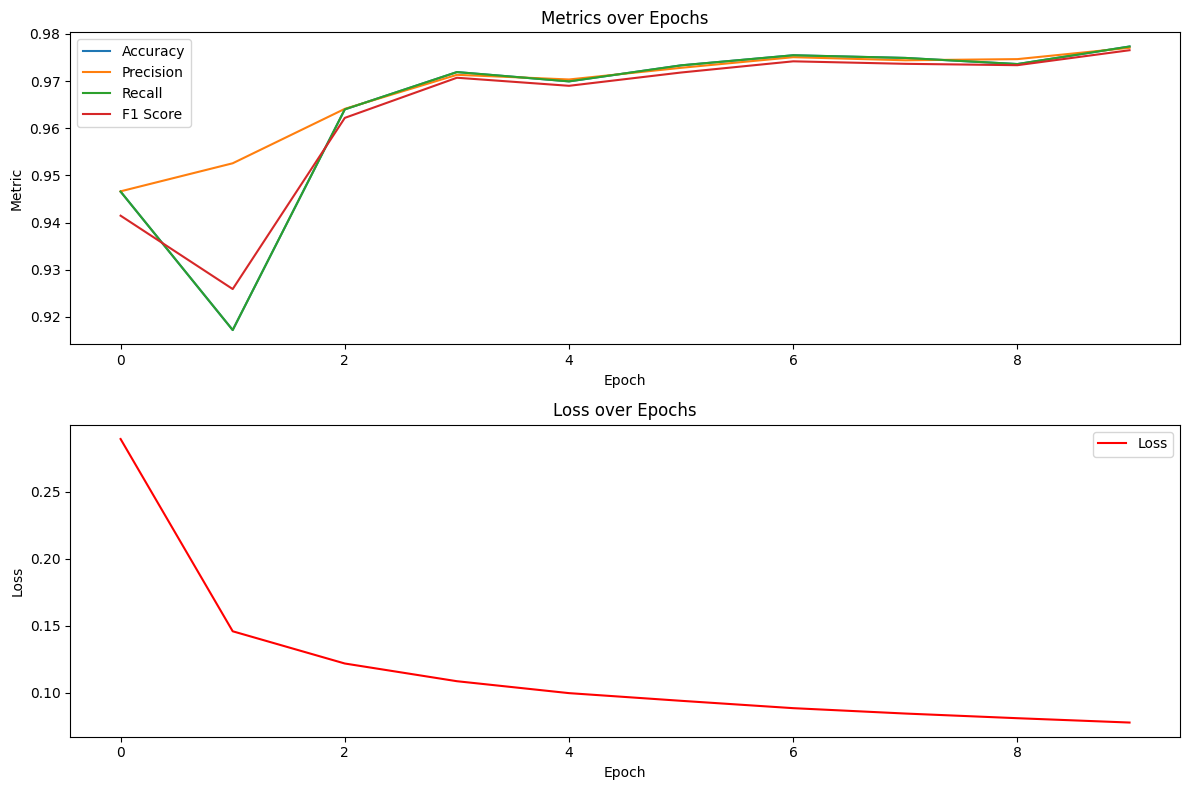

In [11]:
plot_metrics(epoch_acc, epoch_prc, epoch_rec, epoch_f1, epoch_losses, "lstmfcn_metrics")

# LSTMFCN with Attention Experiment
### Description
Use the ECG dataset and stratified k-fold cross validation to train the LSTMFCN+Attention model and evaluate its performance.

### Steps
1. set up the LSTMFCN+Attention model
1. train the LSTMFCN+Attention model
1. evaluate performance with accuracy, F1 score, precision, recall

In [12]:
epoch_acc, epoch_prc, epoch_rec, epoch_f1, epoch_losses = [], [], [], [], []

for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset, dataset_y)):
    print(f"FOLD {fold}")
    print("--------------------------------")

    # store metrics of each fold
    accuracies, precisions, recalls, f1_scores, losses = [], [], [], [], []

    # split data
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)

    # data loaders for training and testing data in this fold
    train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_subsampler)
    test_loader = DataLoader(dataset, batch_size=batch_size, sampler=test_subsampler)

    # set parameters
    input_dim = 1         # ECG data is univariate, so the input dimension is 1
    hidden_dim = 128
    num_layers = 2
    num_classes = 5

    # initialize model for this fold
    model = AttentionLSTMFCN(input_dim, hidden_dim, num_layers, num_classes)
    model.to(device)
    print(model)

    # loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)


    # train
    for epoch in range(num_epochs):
        model.train()
        batch_losses = []

        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            batch_losses.append(loss.item())

            if (i+1) % 100 == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}")

        # store metrics
        accuracy, precision, recall, f1, _, _ = evaluate(model, test_loader)
        accuracies.append(accuracy)
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)

        # Accumulate metrics for each epoch across folds
        if fold == 0:
            # Initialize lists in the first fold
            epoch_acc.append(accuracy)
            epoch_prc.append(precision)
            epoch_rec.append(recall)
            epoch_f1.append(f1)
            epoch_losses.append(batch_losses)
        else:
            # Add to existing totals for subsequent folds
            epoch_acc[epoch] += accuracy
            epoch_prc[epoch] += precision
            epoch_rec[epoch] += recall
            epoch_f1[epoch] += f1
            epoch_losses[epoch].extend(batch_losses)

# Average metrics across all folds for each epoch
epoch_acc = [x / k_folds for x in epoch_acc]
epoch_prc = [x / k_folds for x in epoch_prc]
epoch_rec = [x / k_folds for x in epoch_rec]
epoch_f1 = [x / k_folds for x in epoch_f1]
epoch_losses = [sum(x) / len(x) for x in epoch_losses]

# Print average metrics for each epoch
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1} - Avg Accuracy: {epoch_acc[epoch]}, Avg Precision: {epoch_prc[epoch]}, Avg Recall: {epoch_rec[epoch]}, Avg F1 Score: {epoch_f1[epoch]}, Avg Loss: {epoch_losses[epoch]}")

FOLD 0
--------------------------------
AttentionLSTMFCN(
  (lstm): LSTM(1, 2, batch_first=True)
  (attention): SelfAttention(
    (query): Linear(in_features=2, out_features=2, bias=True)
    (key): Linear(in_features=2, out_features=2, bias=True)
    (value): Linear(in_features=2, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.8, inplace=False)
  (conv1): Conv1d(1, 128, kernel_size=(8,), stride=(1,), padding=same)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(128, 256, kernel_size=(5,), stride=(1,), padding=same)
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv1d(256, 128, kernel_size=(3,), stride=(1,), padding=same)
  (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (global_avg_pooling): AdaptiveAvgPool1d(output_size=1)
  (fc): Linear(in_features=130, out_features=128, bias=True)
)
Epoch [1/10], Step [100/3079], Loss

2023-12-09 00:12:41,801 - root - INFO - Accuracy: 95.81%
2023-12-09 00:12:41,802 - root - INFO - Precision: 0.9571
2023-12-09 00:12:41,803 - root - INFO - Recall: 0.9581
2023-12-09 00:12:41,804 - root - INFO - F1 Score: 0.9514


Epoch [2/10], Step [100/3079], Loss: 0.0707
Epoch [2/10], Step [200/3079], Loss: 0.1182
Epoch [2/10], Step [300/3079], Loss: 0.0879
Epoch [2/10], Step [400/3079], Loss: 0.2685
Epoch [2/10], Step [500/3079], Loss: 0.3509
Epoch [2/10], Step [600/3079], Loss: 0.7508
Epoch [2/10], Step [700/3079], Loss: 0.0538
Epoch [2/10], Step [800/3079], Loss: 0.0784
Epoch [2/10], Step [900/3079], Loss: 0.1159
Epoch [2/10], Step [1000/3079], Loss: 0.2004
Epoch [2/10], Step [1100/3079], Loss: 0.0992
Epoch [2/10], Step [1200/3079], Loss: 0.1301
Epoch [2/10], Step [1300/3079], Loss: 0.1962
Epoch [2/10], Step [1400/3079], Loss: 0.0250
Epoch [2/10], Step [1500/3079], Loss: 0.0529
Epoch [2/10], Step [1600/3079], Loss: 0.1956
Epoch [2/10], Step [1700/3079], Loss: 0.0866
Epoch [2/10], Step [1800/3079], Loss: 0.0995
Epoch [2/10], Step [1900/3079], Loss: 0.1079
Epoch [2/10], Step [2000/3079], Loss: 0.0491
Epoch [2/10], Step [2100/3079], Loss: 0.2148
Epoch [2/10], Step [2200/3079], Loss: 0.1517
Epoch [2/10], Step 

2023-12-09 00:13:01,038 - root - INFO - Accuracy: 96.68%
2023-12-09 00:13:01,039 - root - INFO - Precision: 0.9663
2023-12-09 00:13:01,040 - root - INFO - Recall: 0.9668
2023-12-09 00:13:01,041 - root - INFO - F1 Score: 0.9653


Epoch [3/10], Step [100/3079], Loss: 0.0425
Epoch [3/10], Step [200/3079], Loss: 0.1266
Epoch [3/10], Step [300/3079], Loss: 0.0416
Epoch [3/10], Step [400/3079], Loss: 0.2332
Epoch [3/10], Step [500/3079], Loss: 0.0209
Epoch [3/10], Step [600/3079], Loss: 0.0349
Epoch [3/10], Step [700/3079], Loss: 0.0240
Epoch [3/10], Step [800/3079], Loss: 0.1211
Epoch [3/10], Step [900/3079], Loss: 0.1560
Epoch [3/10], Step [1000/3079], Loss: 0.1085
Epoch [3/10], Step [1100/3079], Loss: 0.0928
Epoch [3/10], Step [1200/3079], Loss: 0.0571
Epoch [3/10], Step [1300/3079], Loss: 0.2013
Epoch [3/10], Step [1400/3079], Loss: 0.0377
Epoch [3/10], Step [1500/3079], Loss: 0.1045
Epoch [3/10], Step [1600/3079], Loss: 0.0338
Epoch [3/10], Step [1700/3079], Loss: 0.6927
Epoch [3/10], Step [1800/3079], Loss: 0.0210
Epoch [3/10], Step [1900/3079], Loss: 0.0600
Epoch [3/10], Step [2000/3079], Loss: 0.0177
Epoch [3/10], Step [2100/3079], Loss: 0.1160
Epoch [3/10], Step [2200/3079], Loss: 0.1340
Epoch [3/10], Step 

2023-12-09 00:13:20,329 - root - INFO - Accuracy: 96.89%
2023-12-09 00:13:20,330 - root - INFO - Precision: 0.9691
2023-12-09 00:13:20,331 - root - INFO - Recall: 0.9689
2023-12-09 00:13:20,332 - root - INFO - F1 Score: 0.9661


Epoch [4/10], Step [100/3079], Loss: 0.0726
Epoch [4/10], Step [200/3079], Loss: 0.0166
Epoch [4/10], Step [300/3079], Loss: 0.1417
Epoch [4/10], Step [400/3079], Loss: 0.1248
Epoch [4/10], Step [500/3079], Loss: 0.1343
Epoch [4/10], Step [600/3079], Loss: 0.0122
Epoch [4/10], Step [700/3079], Loss: 0.1448
Epoch [4/10], Step [800/3079], Loss: 0.1056
Epoch [4/10], Step [900/3079], Loss: 0.0408
Epoch [4/10], Step [1000/3079], Loss: 0.2780
Epoch [4/10], Step [1100/3079], Loss: 0.0469
Epoch [4/10], Step [1200/3079], Loss: 0.2890
Epoch [4/10], Step [1300/3079], Loss: 0.0682
Epoch [4/10], Step [1400/3079], Loss: 0.0202
Epoch [4/10], Step [1500/3079], Loss: 0.0503
Epoch [4/10], Step [1600/3079], Loss: 0.0468
Epoch [4/10], Step [1700/3079], Loss: 0.0228
Epoch [4/10], Step [1800/3079], Loss: 0.0715
Epoch [4/10], Step [1900/3079], Loss: 0.1382
Epoch [4/10], Step [2000/3079], Loss: 0.0211
Epoch [4/10], Step [2100/3079], Loss: 0.1083
Epoch [4/10], Step [2200/3079], Loss: 0.1915
Epoch [4/10], Step 

2023-12-09 00:13:39,342 - root - INFO - Accuracy: 97.05%
2023-12-09 00:13:39,344 - root - INFO - Precision: 0.9706
2023-12-09 00:13:39,345 - root - INFO - Recall: 0.9705
2023-12-09 00:13:39,346 - root - INFO - F1 Score: 0.9699


Epoch [5/10], Step [100/3079], Loss: 0.2049
Epoch [5/10], Step [200/3079], Loss: 0.0419
Epoch [5/10], Step [300/3079], Loss: 0.1670
Epoch [5/10], Step [400/3079], Loss: 0.0204
Epoch [5/10], Step [500/3079], Loss: 0.1087
Epoch [5/10], Step [600/3079], Loss: 0.0189
Epoch [5/10], Step [700/3079], Loss: 0.0382
Epoch [5/10], Step [800/3079], Loss: 0.2677
Epoch [5/10], Step [900/3079], Loss: 0.1376
Epoch [5/10], Step [1000/3079], Loss: 0.1560
Epoch [5/10], Step [1100/3079], Loss: 0.0286
Epoch [5/10], Step [1200/3079], Loss: 0.0305
Epoch [5/10], Step [1300/3079], Loss: 0.0299
Epoch [5/10], Step [1400/3079], Loss: 0.0358
Epoch [5/10], Step [1500/3079], Loss: 0.0616
Epoch [5/10], Step [1600/3079], Loss: 0.1308
Epoch [5/10], Step [1700/3079], Loss: 0.0446
Epoch [5/10], Step [1800/3079], Loss: 0.1599
Epoch [5/10], Step [1900/3079], Loss: 0.0672
Epoch [5/10], Step [2000/3079], Loss: 0.0431
Epoch [5/10], Step [2100/3079], Loss: 0.2067
Epoch [5/10], Step [2200/3079], Loss: 0.1757
Epoch [5/10], Step 

2023-12-09 00:13:58,720 - root - INFO - Accuracy: 97.51%
2023-12-09 00:13:58,721 - root - INFO - Precision: 0.9745
2023-12-09 00:13:58,722 - root - INFO - Recall: 0.9751
2023-12-09 00:13:58,722 - root - INFO - F1 Score: 0.9734


Epoch [6/10], Step [100/3079], Loss: 0.0460
Epoch [6/10], Step [200/3079], Loss: 0.0219
Epoch [6/10], Step [300/3079], Loss: 0.0368
Epoch [6/10], Step [400/3079], Loss: 0.0323
Epoch [6/10], Step [500/3079], Loss: 0.1333
Epoch [6/10], Step [600/3079], Loss: 0.2317
Epoch [6/10], Step [700/3079], Loss: 0.0471
Epoch [6/10], Step [800/3079], Loss: 0.1912
Epoch [6/10], Step [900/3079], Loss: 0.3052
Epoch [6/10], Step [1000/3079], Loss: 0.0340
Epoch [6/10], Step [1100/3079], Loss: 0.0165
Epoch [6/10], Step [1200/3079], Loss: 0.0377
Epoch [6/10], Step [1300/3079], Loss: 0.0335
Epoch [6/10], Step [1400/3079], Loss: 0.0252
Epoch [6/10], Step [1500/3079], Loss: 0.0486
Epoch [6/10], Step [1600/3079], Loss: 0.0971
Epoch [6/10], Step [1700/3079], Loss: 0.1518
Epoch [6/10], Step [1800/3079], Loss: 0.0618
Epoch [6/10], Step [1900/3079], Loss: 0.1978
Epoch [6/10], Step [2000/3079], Loss: 0.0232
Epoch [6/10], Step [2100/3079], Loss: 0.0302
Epoch [6/10], Step [2200/3079], Loss: 0.0600
Epoch [6/10], Step 

2023-12-09 00:14:18,070 - root - INFO - Accuracy: 97.75%
2023-12-09 00:14:18,071 - root - INFO - Precision: 0.9767
2023-12-09 00:14:18,072 - root - INFO - Recall: 0.9775
2023-12-09 00:14:18,073 - root - INFO - F1 Score: 0.9767


Epoch [7/10], Step [100/3079], Loss: 0.1092
Epoch [7/10], Step [200/3079], Loss: 0.0632
Epoch [7/10], Step [300/3079], Loss: 0.2814
Epoch [7/10], Step [400/3079], Loss: 0.0490
Epoch [7/10], Step [500/3079], Loss: 0.1080
Epoch [7/10], Step [600/3079], Loss: 0.1157
Epoch [7/10], Step [700/3079], Loss: 0.0247
Epoch [7/10], Step [800/3079], Loss: 0.2282
Epoch [7/10], Step [900/3079], Loss: 0.0120
Epoch [7/10], Step [1000/3079], Loss: 0.3631
Epoch [7/10], Step [1100/3079], Loss: 0.1239
Epoch [7/10], Step [1200/3079], Loss: 0.1916
Epoch [7/10], Step [1300/3079], Loss: 0.0133
Epoch [7/10], Step [1400/3079], Loss: 0.0838
Epoch [7/10], Step [1500/3079], Loss: 0.0593
Epoch [7/10], Step [1600/3079], Loss: 0.0126
Epoch [7/10], Step [1700/3079], Loss: 0.0244
Epoch [7/10], Step [1800/3079], Loss: 0.0188
Epoch [7/10], Step [1900/3079], Loss: 0.1427
Epoch [7/10], Step [2000/3079], Loss: 0.0117
Epoch [7/10], Step [2100/3079], Loss: 0.0214
Epoch [7/10], Step [2200/3079], Loss: 0.0064
Epoch [7/10], Step 

2023-12-09 00:14:37,622 - root - INFO - Accuracy: 96.76%
2023-12-09 00:14:37,623 - root - INFO - Precision: 0.9681
2023-12-09 00:14:37,624 - root - INFO - Recall: 0.9676
2023-12-09 00:14:37,625 - root - INFO - F1 Score: 0.9625


Epoch [8/10], Step [100/3079], Loss: 0.2093
Epoch [8/10], Step [200/3079], Loss: 0.0288
Epoch [8/10], Step [300/3079], Loss: 0.0086
Epoch [8/10], Step [400/3079], Loss: 0.0807
Epoch [8/10], Step [500/3079], Loss: 0.1711
Epoch [8/10], Step [600/3079], Loss: 0.0357
Epoch [8/10], Step [700/3079], Loss: 0.3816
Epoch [8/10], Step [800/3079], Loss: 0.0172
Epoch [8/10], Step [900/3079], Loss: 0.1241
Epoch [8/10], Step [1000/3079], Loss: 0.0202
Epoch [8/10], Step [1100/3079], Loss: 0.0504
Epoch [8/10], Step [1200/3079], Loss: 0.0812
Epoch [8/10], Step [1300/3079], Loss: 0.1588
Epoch [8/10], Step [1400/3079], Loss: 0.2255
Epoch [8/10], Step [1500/3079], Loss: 0.0111
Epoch [8/10], Step [1600/3079], Loss: 0.1843
Epoch [8/10], Step [1700/3079], Loss: 0.4200
Epoch [8/10], Step [1800/3079], Loss: 0.0533
Epoch [8/10], Step [1900/3079], Loss: 0.0190
Epoch [8/10], Step [2000/3079], Loss: 0.1343
Epoch [8/10], Step [2100/3079], Loss: 0.0775
Epoch [8/10], Step [2200/3079], Loss: 0.0226
Epoch [8/10], Step 

2023-12-09 00:14:56,994 - root - INFO - Accuracy: 97.87%
2023-12-09 00:14:56,996 - root - INFO - Precision: 0.9783
2023-12-09 00:14:56,997 - root - INFO - Recall: 0.9787
2023-12-09 00:14:56,998 - root - INFO - F1 Score: 0.9775


Epoch [9/10], Step [100/3079], Loss: 0.2140
Epoch [9/10], Step [200/3079], Loss: 0.0227
Epoch [9/10], Step [300/3079], Loss: 0.0440
Epoch [9/10], Step [400/3079], Loss: 0.1135
Epoch [9/10], Step [500/3079], Loss: 0.0105
Epoch [9/10], Step [600/3079], Loss: 0.0954
Epoch [9/10], Step [700/3079], Loss: 0.0987
Epoch [9/10], Step [800/3079], Loss: 0.0139
Epoch [9/10], Step [900/3079], Loss: 0.0120
Epoch [9/10], Step [1000/3079], Loss: 0.0096
Epoch [9/10], Step [1100/3079], Loss: 0.0242
Epoch [9/10], Step [1200/3079], Loss: 0.0375
Epoch [9/10], Step [1300/3079], Loss: 0.0175
Epoch [9/10], Step [1400/3079], Loss: 0.0804
Epoch [9/10], Step [1500/3079], Loss: 0.0347
Epoch [9/10], Step [1600/3079], Loss: 0.0858
Epoch [9/10], Step [1700/3079], Loss: 0.0668
Epoch [9/10], Step [1800/3079], Loss: 0.1096
Epoch [9/10], Step [1900/3079], Loss: 0.0227
Epoch [9/10], Step [2000/3079], Loss: 0.0657
Epoch [9/10], Step [2100/3079], Loss: 0.0672
Epoch [9/10], Step [2200/3079], Loss: 0.1904
Epoch [9/10], Step 

2023-12-09 00:15:16,419 - root - INFO - Accuracy: 97.30%
2023-12-09 00:15:16,420 - root - INFO - Precision: 0.9731
2023-12-09 00:15:16,421 - root - INFO - Recall: 0.9730
2023-12-09 00:15:16,422 - root - INFO - F1 Score: 0.9714


Epoch [10/10], Step [100/3079], Loss: 0.0634
Epoch [10/10], Step [200/3079], Loss: 0.0102
Epoch [10/10], Step [300/3079], Loss: 0.0482
Epoch [10/10], Step [400/3079], Loss: 0.0704
Epoch [10/10], Step [500/3079], Loss: 0.0066
Epoch [10/10], Step [600/3079], Loss: 0.0473
Epoch [10/10], Step [700/3079], Loss: 0.2727
Epoch [10/10], Step [800/3079], Loss: 0.0231
Epoch [10/10], Step [900/3079], Loss: 0.0168
Epoch [10/10], Step [1000/3079], Loss: 0.1253
Epoch [10/10], Step [1100/3079], Loss: 0.0268
Epoch [10/10], Step [1200/3079], Loss: 0.1013
Epoch [10/10], Step [1300/3079], Loss: 0.0124
Epoch [10/10], Step [1400/3079], Loss: 0.0082
Epoch [10/10], Step [1500/3079], Loss: 0.0854
Epoch [10/10], Step [1600/3079], Loss: 0.1056
Epoch [10/10], Step [1700/3079], Loss: 0.0179
Epoch [10/10], Step [1800/3079], Loss: 0.0618
Epoch [10/10], Step [1900/3079], Loss: 0.0198
Epoch [10/10], Step [2000/3079], Loss: 0.2735
Epoch [10/10], Step [2100/3079], Loss: 0.1030
Epoch [10/10], Step [2200/3079], Loss: 0.02

2023-12-09 00:15:35,527 - root - INFO - Accuracy: 98.03%
2023-12-09 00:15:35,528 - root - INFO - Precision: 0.9799
2023-12-09 00:15:35,529 - root - INFO - Recall: 0.9803
2023-12-09 00:15:35,530 - root - INFO - F1 Score: 0.9790


FOLD 1
--------------------------------
AttentionLSTMFCN(
  (lstm): LSTM(1, 2, batch_first=True)
  (attention): SelfAttention(
    (query): Linear(in_features=2, out_features=2, bias=True)
    (key): Linear(in_features=2, out_features=2, bias=True)
    (value): Linear(in_features=2, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.8, inplace=False)
  (conv1): Conv1d(1, 128, kernel_size=(8,), stride=(1,), padding=same)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(128, 256, kernel_size=(5,), stride=(1,), padding=same)
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv1d(256, 128, kernel_size=(3,), stride=(1,), padding=same)
  (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (global_avg_pooling): AdaptiveAvgPool1d(output_size=1)
  (fc): Linear(in_features=130, out_features=128, bias=True)
)
Epoch [1/10], Step [100/3079], Loss

2023-12-09 00:15:54,787 - root - INFO - Accuracy: 95.16%
2023-12-09 00:15:54,788 - root - INFO - Precision: 0.9501
2023-12-09 00:15:54,789 - root - INFO - Recall: 0.9516
2023-12-09 00:15:54,790 - root - INFO - F1 Score: 0.9459


Epoch [2/10], Step [100/3079], Loss: 0.0452
Epoch [2/10], Step [200/3079], Loss: 0.0513
Epoch [2/10], Step [300/3079], Loss: 0.1442
Epoch [2/10], Step [400/3079], Loss: 0.1800
Epoch [2/10], Step [500/3079], Loss: 0.2954
Epoch [2/10], Step [600/3079], Loss: 0.0410
Epoch [2/10], Step [700/3079], Loss: 0.2983
Epoch [2/10], Step [800/3079], Loss: 0.1845
Epoch [2/10], Step [900/3079], Loss: 0.2050
Epoch [2/10], Step [1000/3079], Loss: 0.0412
Epoch [2/10], Step [1100/3079], Loss: 0.0219
Epoch [2/10], Step [1200/3079], Loss: 0.1632
Epoch [2/10], Step [1300/3079], Loss: 0.0223
Epoch [2/10], Step [1400/3079], Loss: 0.1428
Epoch [2/10], Step [1500/3079], Loss: 0.1521
Epoch [2/10], Step [1600/3079], Loss: 0.0484
Epoch [2/10], Step [1700/3079], Loss: 0.0954
Epoch [2/10], Step [1800/3079], Loss: 0.0880
Epoch [2/10], Step [1900/3079], Loss: 0.1321
Epoch [2/10], Step [2000/3079], Loss: 0.1513
Epoch [2/10], Step [2100/3079], Loss: 0.1316
Epoch [2/10], Step [2200/3079], Loss: 0.2162
Epoch [2/10], Step 

2023-12-09 00:16:14,042 - root - INFO - Accuracy: 95.30%
2023-12-09 00:16:14,043 - root - INFO - Precision: 0.9528
2023-12-09 00:16:14,043 - root - INFO - Recall: 0.9530
2023-12-09 00:16:14,044 - root - INFO - F1 Score: 0.9474


Epoch [3/10], Step [100/3079], Loss: 0.0662
Epoch [3/10], Step [200/3079], Loss: 0.1909
Epoch [3/10], Step [300/3079], Loss: 0.2202
Epoch [3/10], Step [400/3079], Loss: 0.2043
Epoch [3/10], Step [500/3079], Loss: 0.3372
Epoch [3/10], Step [600/3079], Loss: 0.0846
Epoch [3/10], Step [700/3079], Loss: 0.0728
Epoch [3/10], Step [800/3079], Loss: 0.0449
Epoch [3/10], Step [900/3079], Loss: 0.2027
Epoch [3/10], Step [1000/3079], Loss: 0.2076
Epoch [3/10], Step [1100/3079], Loss: 0.1217
Epoch [3/10], Step [1200/3079], Loss: 0.0364
Epoch [3/10], Step [1300/3079], Loss: 0.0545
Epoch [3/10], Step [1400/3079], Loss: 0.0472
Epoch [3/10], Step [1500/3079], Loss: 0.0622
Epoch [3/10], Step [1600/3079], Loss: 0.0522
Epoch [3/10], Step [1700/3079], Loss: 0.0745
Epoch [3/10], Step [1800/3079], Loss: 0.1310
Epoch [3/10], Step [1900/3079], Loss: 0.3230
Epoch [3/10], Step [2000/3079], Loss: 0.1367
Epoch [3/10], Step [2100/3079], Loss: 0.1185
Epoch [3/10], Step [2200/3079], Loss: 0.2848
Epoch [3/10], Step 

2023-12-09 00:16:33,116 - root - INFO - Accuracy: 97.37%
2023-12-09 00:16:33,117 - root - INFO - Precision: 0.9729
2023-12-09 00:16:33,118 - root - INFO - Recall: 0.9737
2023-12-09 00:16:33,119 - root - INFO - F1 Score: 0.9722


Epoch [4/10], Step [100/3079], Loss: 0.1409
Epoch [4/10], Step [200/3079], Loss: 0.2124
Epoch [4/10], Step [300/3079], Loss: 0.1419
Epoch [4/10], Step [400/3079], Loss: 0.1061
Epoch [4/10], Step [500/3079], Loss: 0.0264
Epoch [4/10], Step [600/3079], Loss: 0.0714
Epoch [4/10], Step [700/3079], Loss: 0.0970
Epoch [4/10], Step [800/3079], Loss: 0.0153
Epoch [4/10], Step [900/3079], Loss: 0.1702
Epoch [4/10], Step [1000/3079], Loss: 0.0255
Epoch [4/10], Step [1100/3079], Loss: 0.0383
Epoch [4/10], Step [1200/3079], Loss: 0.0409
Epoch [4/10], Step [1300/3079], Loss: 0.0148
Epoch [4/10], Step [1400/3079], Loss: 0.0319
Epoch [4/10], Step [1500/3079], Loss: 0.0398
Epoch [4/10], Step [1600/3079], Loss: 0.0795
Epoch [4/10], Step [1700/3079], Loss: 0.1936
Epoch [4/10], Step [1800/3079], Loss: 0.0160
Epoch [4/10], Step [1900/3079], Loss: 0.1731
Epoch [4/10], Step [2000/3079], Loss: 0.0790
Epoch [4/10], Step [2100/3079], Loss: 0.0579
Epoch [4/10], Step [2200/3079], Loss: 0.0477
Epoch [4/10], Step 

2023-12-09 00:16:52,008 - root - INFO - Accuracy: 97.32%
2023-12-09 00:16:52,009 - root - INFO - Precision: 0.9723
2023-12-09 00:16:52,010 - root - INFO - Recall: 0.9732
2023-12-09 00:16:52,012 - root - INFO - F1 Score: 0.9720


Epoch [5/10], Step [100/3079], Loss: 0.0319
Epoch [5/10], Step [200/3079], Loss: 0.0346
Epoch [5/10], Step [300/3079], Loss: 0.1034
Epoch [5/10], Step [400/3079], Loss: 0.0124
Epoch [5/10], Step [500/3079], Loss: 0.1704
Epoch [5/10], Step [600/3079], Loss: 0.3201
Epoch [5/10], Step [700/3079], Loss: 0.2552
Epoch [5/10], Step [800/3079], Loss: 0.0172
Epoch [5/10], Step [900/3079], Loss: 0.0097
Epoch [5/10], Step [1000/3079], Loss: 0.0102
Epoch [5/10], Step [1100/3079], Loss: 0.2669
Epoch [5/10], Step [1200/3079], Loss: 0.0353
Epoch [5/10], Step [1300/3079], Loss: 0.0930
Epoch [5/10], Step [1400/3079], Loss: 0.1806
Epoch [5/10], Step [1500/3079], Loss: 0.3142
Epoch [5/10], Step [1600/3079], Loss: 0.1364
Epoch [5/10], Step [1700/3079], Loss: 0.1868
Epoch [5/10], Step [1800/3079], Loss: 0.0334
Epoch [5/10], Step [1900/3079], Loss: 0.0704
Epoch [5/10], Step [2000/3079], Loss: 0.0563
Epoch [5/10], Step [2100/3079], Loss: 0.1144
Epoch [5/10], Step [2200/3079], Loss: 0.0143
Epoch [5/10], Step 

2023-12-09 00:17:10,996 - root - INFO - Accuracy: 97.51%
2023-12-09 00:17:10,997 - root - INFO - Precision: 0.9744
2023-12-09 00:17:10,998 - root - INFO - Recall: 0.9751
2023-12-09 00:17:10,999 - root - INFO - F1 Score: 0.9746


Epoch [6/10], Step [100/3079], Loss: 0.2314
Epoch [6/10], Step [200/3079], Loss: 0.0410
Epoch [6/10], Step [300/3079], Loss: 0.1785
Epoch [6/10], Step [400/3079], Loss: 0.0302
Epoch [6/10], Step [500/3079], Loss: 0.1790
Epoch [6/10], Step [600/3079], Loss: 0.0653
Epoch [6/10], Step [700/3079], Loss: 0.2309
Epoch [6/10], Step [800/3079], Loss: 0.0312
Epoch [6/10], Step [900/3079], Loss: 0.0463
Epoch [6/10], Step [1000/3079], Loss: 0.0110
Epoch [6/10], Step [1100/3079], Loss: 0.0356
Epoch [6/10], Step [1200/3079], Loss: 0.1081
Epoch [6/10], Step [1300/3079], Loss: 0.3024
Epoch [6/10], Step [1400/3079], Loss: 0.0173
Epoch [6/10], Step [1500/3079], Loss: 0.0287
Epoch [6/10], Step [1600/3079], Loss: 0.1790
Epoch [6/10], Step [1700/3079], Loss: 0.0504
Epoch [6/10], Step [1800/3079], Loss: 0.3970
Epoch [6/10], Step [1900/3079], Loss: 0.0120
Epoch [6/10], Step [2000/3079], Loss: 0.1058
Epoch [6/10], Step [2100/3079], Loss: 0.0363
Epoch [6/10], Step [2200/3079], Loss: 0.0465
Epoch [6/10], Step 

2023-12-09 00:17:29,741 - root - INFO - Accuracy: 97.09%
2023-12-09 00:17:29,742 - root - INFO - Precision: 0.9700
2023-12-09 00:17:29,743 - root - INFO - Recall: 0.9709
2023-12-09 00:17:29,744 - root - INFO - F1 Score: 0.9697


Epoch [7/10], Step [100/3079], Loss: 0.0736
Epoch [7/10], Step [200/3079], Loss: 0.0248
Epoch [7/10], Step [300/3079], Loss: 0.0101
Epoch [7/10], Step [400/3079], Loss: 0.0185
Epoch [7/10], Step [500/3079], Loss: 0.0535
Epoch [7/10], Step [600/3079], Loss: 0.0411
Epoch [7/10], Step [700/3079], Loss: 0.0606
Epoch [7/10], Step [800/3079], Loss: 0.2227
Epoch [7/10], Step [900/3079], Loss: 0.1669
Epoch [7/10], Step [1000/3079], Loss: 0.1208
Epoch [7/10], Step [1100/3079], Loss: 0.0091
Epoch [7/10], Step [1200/3079], Loss: 0.0452
Epoch [7/10], Step [1300/3079], Loss: 0.0324
Epoch [7/10], Step [1400/3079], Loss: 0.1721
Epoch [7/10], Step [1500/3079], Loss: 0.0386
Epoch [7/10], Step [1600/3079], Loss: 0.0521
Epoch [7/10], Step [1700/3079], Loss: 0.0305
Epoch [7/10], Step [1800/3079], Loss: 0.1842
Epoch [7/10], Step [1900/3079], Loss: 0.0436
Epoch [7/10], Step [2000/3079], Loss: 0.0135
Epoch [7/10], Step [2100/3079], Loss: 0.1066
Epoch [7/10], Step [2200/3079], Loss: 0.0319
Epoch [7/10], Step 

2023-12-09 00:17:48,559 - root - INFO - Accuracy: 97.36%
2023-12-09 00:17:48,560 - root - INFO - Precision: 0.9729
2023-12-09 00:17:48,561 - root - INFO - Recall: 0.9736
2023-12-09 00:17:48,562 - root - INFO - F1 Score: 0.9723


Epoch [8/10], Step [100/3079], Loss: 0.1713
Epoch [8/10], Step [200/3079], Loss: 0.0688
Epoch [8/10], Step [300/3079], Loss: 0.0256
Epoch [8/10], Step [400/3079], Loss: 0.0391
Epoch [8/10], Step [500/3079], Loss: 0.0274
Epoch [8/10], Step [600/3079], Loss: 0.0414
Epoch [8/10], Step [700/3079], Loss: 0.1125
Epoch [8/10], Step [800/3079], Loss: 0.0854
Epoch [8/10], Step [900/3079], Loss: 0.0131
Epoch [8/10], Step [1000/3079], Loss: 0.0396
Epoch [8/10], Step [1100/3079], Loss: 0.0333
Epoch [8/10], Step [1200/3079], Loss: 0.0761
Epoch [8/10], Step [1300/3079], Loss: 0.0494
Epoch [8/10], Step [1400/3079], Loss: 0.0194
Epoch [8/10], Step [1500/3079], Loss: 0.0315
Epoch [8/10], Step [1600/3079], Loss: 0.0224
Epoch [8/10], Step [1700/3079], Loss: 0.0306
Epoch [8/10], Step [1800/3079], Loss: 0.0266
Epoch [8/10], Step [1900/3079], Loss: 0.0862
Epoch [8/10], Step [2000/3079], Loss: 0.0340
Epoch [8/10], Step [2100/3079], Loss: 0.0215
Epoch [8/10], Step [2200/3079], Loss: 0.0487
Epoch [8/10], Step 

2023-12-09 00:18:07,444 - root - INFO - Accuracy: 97.90%
2023-12-09 00:18:07,445 - root - INFO - Precision: 0.9787
2023-12-09 00:18:07,446 - root - INFO - Recall: 0.9790
2023-12-09 00:18:07,446 - root - INFO - F1 Score: 0.9787


Epoch [9/10], Step [100/3079], Loss: 0.0121
Epoch [9/10], Step [200/3079], Loss: 0.2511
Epoch [9/10], Step [300/3079], Loss: 0.0277
Epoch [9/10], Step [400/3079], Loss: 0.0582
Epoch [9/10], Step [500/3079], Loss: 0.1129
Epoch [9/10], Step [600/3079], Loss: 0.2771
Epoch [9/10], Step [700/3079], Loss: 0.0382
Epoch [9/10], Step [800/3079], Loss: 0.2034
Epoch [9/10], Step [900/3079], Loss: 0.0110
Epoch [9/10], Step [1000/3079], Loss: 0.0106
Epoch [9/10], Step [1100/3079], Loss: 0.0086
Epoch [9/10], Step [1200/3079], Loss: 0.0421
Epoch [9/10], Step [1300/3079], Loss: 0.0201
Epoch [9/10], Step [1400/3079], Loss: 0.0361
Epoch [9/10], Step [1500/3079], Loss: 0.0265
Epoch [9/10], Step [1600/3079], Loss: 0.0127
Epoch [9/10], Step [1700/3079], Loss: 0.1458
Epoch [9/10], Step [1800/3079], Loss: 0.0585
Epoch [9/10], Step [1900/3079], Loss: 0.0135
Epoch [9/10], Step [2000/3079], Loss: 0.0361
Epoch [9/10], Step [2100/3079], Loss: 0.0558
Epoch [9/10], Step [2200/3079], Loss: 0.0428
Epoch [9/10], Step 

2023-12-09 00:18:26,191 - root - INFO - Accuracy: 97.78%
2023-12-09 00:18:26,193 - root - INFO - Precision: 0.9776
2023-12-09 00:18:26,193 - root - INFO - Recall: 0.9778
2023-12-09 00:18:26,194 - root - INFO - F1 Score: 0.9771


Epoch [10/10], Step [100/3079], Loss: 0.0544
Epoch [10/10], Step [200/3079], Loss: 0.0550
Epoch [10/10], Step [300/3079], Loss: 0.1594
Epoch [10/10], Step [400/3079], Loss: 0.1718
Epoch [10/10], Step [500/3079], Loss: 0.0339
Epoch [10/10], Step [600/3079], Loss: 0.1148
Epoch [10/10], Step [700/3079], Loss: 0.0884
Epoch [10/10], Step [800/3079], Loss: 0.3545
Epoch [10/10], Step [900/3079], Loss: 0.3961
Epoch [10/10], Step [1000/3079], Loss: 0.0330
Epoch [10/10], Step [1100/3079], Loss: 0.0126
Epoch [10/10], Step [1200/3079], Loss: 0.2282
Epoch [10/10], Step [1300/3079], Loss: 0.1136
Epoch [10/10], Step [1400/3079], Loss: 0.2372
Epoch [10/10], Step [1500/3079], Loss: 0.0056
Epoch [10/10], Step [1600/3079], Loss: 0.0221
Epoch [10/10], Step [1700/3079], Loss: 0.0184
Epoch [10/10], Step [1800/3079], Loss: 0.1519
Epoch [10/10], Step [1900/3079], Loss: 0.0348
Epoch [10/10], Step [2000/3079], Loss: 0.0157
Epoch [10/10], Step [2100/3079], Loss: 0.0064
Epoch [10/10], Step [2200/3079], Loss: 0.02

2023-12-09 00:18:44,637 - root - INFO - Accuracy: 97.98%
2023-12-09 00:18:44,638 - root - INFO - Precision: 0.9794
2023-12-09 00:18:44,638 - root - INFO - Recall: 0.9798
2023-12-09 00:18:44,639 - root - INFO - F1 Score: 0.9789


FOLD 2
--------------------------------
AttentionLSTMFCN(
  (lstm): LSTM(1, 2, batch_first=True)
  (attention): SelfAttention(
    (query): Linear(in_features=2, out_features=2, bias=True)
    (key): Linear(in_features=2, out_features=2, bias=True)
    (value): Linear(in_features=2, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.8, inplace=False)
  (conv1): Conv1d(1, 128, kernel_size=(8,), stride=(1,), padding=same)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(128, 256, kernel_size=(5,), stride=(1,), padding=same)
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv1d(256, 128, kernel_size=(3,), stride=(1,), padding=same)
  (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (global_avg_pooling): AdaptiveAvgPool1d(output_size=1)
  (fc): Linear(in_features=130, out_features=128, bias=True)
)
Epoch [1/10], Step [100/3079], Loss

2023-12-09 00:19:03,311 - root - INFO - Accuracy: 95.38%
2023-12-09 00:19:03,312 - root - INFO - Precision: 0.9527
2023-12-09 00:19:03,313 - root - INFO - Recall: 0.9538
2023-12-09 00:19:03,315 - root - INFO - F1 Score: 0.9506


Epoch [2/10], Step [100/3079], Loss: 0.0423
Epoch [2/10], Step [200/3079], Loss: 0.0783
Epoch [2/10], Step [300/3079], Loss: 0.1725
Epoch [2/10], Step [400/3079], Loss: 0.1675
Epoch [2/10], Step [500/3079], Loss: 0.1975
Epoch [2/10], Step [600/3079], Loss: 0.0916
Epoch [2/10], Step [700/3079], Loss: 0.0966
Epoch [2/10], Step [800/3079], Loss: 0.1332
Epoch [2/10], Step [900/3079], Loss: 0.1841
Epoch [2/10], Step [1000/3079], Loss: 0.0479
Epoch [2/10], Step [1100/3079], Loss: 0.0439
Epoch [2/10], Step [1200/3079], Loss: 0.1961
Epoch [2/10], Step [1300/3079], Loss: 0.1809
Epoch [2/10], Step [1400/3079], Loss: 0.1865
Epoch [2/10], Step [1500/3079], Loss: 0.0336
Epoch [2/10], Step [1600/3079], Loss: 0.0850
Epoch [2/10], Step [1700/3079], Loss: 0.0339
Epoch [2/10], Step [1800/3079], Loss: 0.2375
Epoch [2/10], Step [1900/3079], Loss: 0.0746
Epoch [2/10], Step [2000/3079], Loss: 0.0210
Epoch [2/10], Step [2100/3079], Loss: 0.0480
Epoch [2/10], Step [2200/3079], Loss: 0.0629
Epoch [2/10], Step 

2023-12-09 00:19:22,200 - root - INFO - Accuracy: 95.97%
2023-12-09 00:19:22,201 - root - INFO - Precision: 0.9611
2023-12-09 00:19:22,201 - root - INFO - Recall: 0.9597
2023-12-09 00:19:22,202 - root - INFO - F1 Score: 0.9574


Epoch [3/10], Step [100/3079], Loss: 0.0397
Epoch [3/10], Step [200/3079], Loss: 0.0817
Epoch [3/10], Step [300/3079], Loss: 0.0421
Epoch [3/10], Step [400/3079], Loss: 0.0567
Epoch [3/10], Step [500/3079], Loss: 0.0872
Epoch [3/10], Step [600/3079], Loss: 0.0271
Epoch [3/10], Step [700/3079], Loss: 0.0394
Epoch [3/10], Step [800/3079], Loss: 0.0757
Epoch [3/10], Step [900/3079], Loss: 0.2594
Epoch [3/10], Step [1000/3079], Loss: 0.0206
Epoch [3/10], Step [1100/3079], Loss: 0.1446
Epoch [3/10], Step [1200/3079], Loss: 0.0519
Epoch [3/10], Step [1300/3079], Loss: 0.2379
Epoch [3/10], Step [1400/3079], Loss: 0.0570
Epoch [3/10], Step [1500/3079], Loss: 0.0503
Epoch [3/10], Step [1600/3079], Loss: 0.0749
Epoch [3/10], Step [1700/3079], Loss: 0.0216
Epoch [3/10], Step [1800/3079], Loss: 0.0384
Epoch [3/10], Step [1900/3079], Loss: 0.0607
Epoch [3/10], Step [2000/3079], Loss: 0.1499
Epoch [3/10], Step [2100/3079], Loss: 0.2939
Epoch [3/10], Step [2200/3079], Loss: 0.0319
Epoch [3/10], Step 

2023-12-09 00:19:41,131 - root - INFO - Accuracy: 96.87%
2023-12-09 00:19:41,132 - root - INFO - Precision: 0.9674
2023-12-09 00:19:41,133 - root - INFO - Recall: 0.9687
2023-12-09 00:19:41,133 - root - INFO - F1 Score: 0.9662


Epoch [4/10], Step [100/3079], Loss: 0.0828
Epoch [4/10], Step [200/3079], Loss: 0.1100
Epoch [4/10], Step [300/3079], Loss: 0.2126
Epoch [4/10], Step [400/3079], Loss: 0.2551
Epoch [4/10], Step [500/3079], Loss: 0.1338
Epoch [4/10], Step [600/3079], Loss: 0.0289
Epoch [4/10], Step [700/3079], Loss: 0.0531
Epoch [4/10], Step [800/3079], Loss: 0.4482
Epoch [4/10], Step [900/3079], Loss: 0.1554
Epoch [4/10], Step [1000/3079], Loss: 0.0622
Epoch [4/10], Step [1100/3079], Loss: 0.1875
Epoch [4/10], Step [1200/3079], Loss: 0.2020
Epoch [4/10], Step [1300/3079], Loss: 0.1669
Epoch [4/10], Step [1400/3079], Loss: 0.1413
Epoch [4/10], Step [1500/3079], Loss: 0.0457
Epoch [4/10], Step [1600/3079], Loss: 0.0150
Epoch [4/10], Step [1700/3079], Loss: 0.2385
Epoch [4/10], Step [1800/3079], Loss: 0.2428
Epoch [4/10], Step [1900/3079], Loss: 0.0253
Epoch [4/10], Step [2000/3079], Loss: 0.0422
Epoch [4/10], Step [2100/3079], Loss: 0.2204
Epoch [4/10], Step [2200/3079], Loss: 0.1494
Epoch [4/10], Step 

2023-12-09 00:19:59,938 - root - INFO - Accuracy: 96.99%
2023-12-09 00:19:59,939 - root - INFO - Precision: 0.9687
2023-12-09 00:19:59,940 - root - INFO - Recall: 0.9699
2023-12-09 00:19:59,941 - root - INFO - F1 Score: 0.9681


Epoch [5/10], Step [100/3079], Loss: 0.0284
Epoch [5/10], Step [200/3079], Loss: 0.0204
Epoch [5/10], Step [300/3079], Loss: 0.1130
Epoch [5/10], Step [400/3079], Loss: 0.0704
Epoch [5/10], Step [500/3079], Loss: 0.2159
Epoch [5/10], Step [600/3079], Loss: 0.0173
Epoch [5/10], Step [700/3079], Loss: 0.0419
Epoch [5/10], Step [800/3079], Loss: 0.1435
Epoch [5/10], Step [900/3079], Loss: 0.0231
Epoch [5/10], Step [1000/3079], Loss: 0.0984
Epoch [5/10], Step [1100/3079], Loss: 0.1187
Epoch [5/10], Step [1200/3079], Loss: 0.2284
Epoch [5/10], Step [1300/3079], Loss: 0.0415
Epoch [5/10], Step [1400/3079], Loss: 0.0244
Epoch [5/10], Step [1500/3079], Loss: 0.0643
Epoch [5/10], Step [1600/3079], Loss: 0.0174
Epoch [5/10], Step [1700/3079], Loss: 0.0998
Epoch [5/10], Step [1800/3079], Loss: 0.1031
Epoch [5/10], Step [1900/3079], Loss: 0.3735
Epoch [5/10], Step [2000/3079], Loss: 0.0742
Epoch [5/10], Step [2100/3079], Loss: 0.0164
Epoch [5/10], Step [2200/3079], Loss: 0.0292
Epoch [5/10], Step 

2023-12-09 00:20:18,732 - root - INFO - Accuracy: 97.22%
2023-12-09 00:20:18,733 - root - INFO - Precision: 0.9715
2023-12-09 00:20:18,735 - root - INFO - Recall: 0.9722
2023-12-09 00:20:18,736 - root - INFO - F1 Score: 0.9703


Epoch [6/10], Step [100/3079], Loss: 0.1767
Epoch [6/10], Step [200/3079], Loss: 0.1311
Epoch [6/10], Step [300/3079], Loss: 0.0215
Epoch [6/10], Step [400/3079], Loss: 0.0802
Epoch [6/10], Step [500/3079], Loss: 0.1187
Epoch [6/10], Step [600/3079], Loss: 0.0846
Epoch [6/10], Step [700/3079], Loss: 0.0910
Epoch [6/10], Step [800/3079], Loss: 0.0394
Epoch [6/10], Step [900/3079], Loss: 0.0597
Epoch [6/10], Step [1000/3079], Loss: 0.1137
Epoch [6/10], Step [1100/3079], Loss: 0.0100
Epoch [6/10], Step [1200/3079], Loss: 0.0270
Epoch [6/10], Step [1300/3079], Loss: 0.0241
Epoch [6/10], Step [1400/3079], Loss: 0.0854
Epoch [6/10], Step [1500/3079], Loss: 0.1597
Epoch [6/10], Step [1600/3079], Loss: 0.0318
Epoch [6/10], Step [1700/3079], Loss: 0.0160
Epoch [6/10], Step [1800/3079], Loss: 0.2658
Epoch [6/10], Step [1900/3079], Loss: 0.0110
Epoch [6/10], Step [2000/3079], Loss: 0.0379
Epoch [6/10], Step [2100/3079], Loss: 0.1246
Epoch [6/10], Step [2200/3079], Loss: 0.0146
Epoch [6/10], Step 

2023-12-09 00:20:37,441 - root - INFO - Accuracy: 97.35%
2023-12-09 00:20:37,442 - root - INFO - Precision: 0.9726
2023-12-09 00:20:37,443 - root - INFO - Recall: 0.9735
2023-12-09 00:20:37,444 - root - INFO - F1 Score: 0.9727


Epoch [7/10], Step [100/3079], Loss: 0.0270
Epoch [7/10], Step [200/3079], Loss: 0.0314
Epoch [7/10], Step [300/3079], Loss: 0.3687
Epoch [7/10], Step [400/3079], Loss: 0.0485
Epoch [7/10], Step [500/3079], Loss: 0.1871
Epoch [7/10], Step [600/3079], Loss: 0.0127
Epoch [7/10], Step [700/3079], Loss: 0.0162
Epoch [7/10], Step [800/3079], Loss: 0.2097
Epoch [7/10], Step [900/3079], Loss: 0.0315
Epoch [7/10], Step [1000/3079], Loss: 0.1104
Epoch [7/10], Step [1100/3079], Loss: 0.0408
Epoch [7/10], Step [1200/3079], Loss: 0.0379
Epoch [7/10], Step [1300/3079], Loss: 0.1676
Epoch [7/10], Step [1400/3079], Loss: 0.0107
Epoch [7/10], Step [1500/3079], Loss: 0.0428
Epoch [7/10], Step [1600/3079], Loss: 0.1395
Epoch [7/10], Step [1700/3079], Loss: 0.0142
Epoch [7/10], Step [1800/3079], Loss: 0.0516
Epoch [7/10], Step [1900/3079], Loss: 0.0087
Epoch [7/10], Step [2000/3079], Loss: 0.2063
Epoch [7/10], Step [2100/3079], Loss: 0.0096
Epoch [7/10], Step [2200/3079], Loss: 0.0284
Epoch [7/10], Step 

2023-12-09 00:20:56,367 - root - INFO - Accuracy: 97.45%
2023-12-09 00:20:56,368 - root - INFO - Precision: 0.9736
2023-12-09 00:20:56,369 - root - INFO - Recall: 0.9745
2023-12-09 00:20:56,370 - root - INFO - F1 Score: 0.9735


Epoch [8/10], Step [100/3079], Loss: 0.0262
Epoch [8/10], Step [200/3079], Loss: 0.0760
Epoch [8/10], Step [300/3079], Loss: 0.0271
Epoch [8/10], Step [400/3079], Loss: 0.1062
Epoch [8/10], Step [500/3079], Loss: 0.0687
Epoch [8/10], Step [600/3079], Loss: 0.4636
Epoch [8/10], Step [700/3079], Loss: 0.0237
Epoch [8/10], Step [800/3079], Loss: 0.0103
Epoch [8/10], Step [900/3079], Loss: 0.1600
Epoch [8/10], Step [1000/3079], Loss: 0.0390
Epoch [8/10], Step [1100/3079], Loss: 0.0291
Epoch [8/10], Step [1200/3079], Loss: 0.1422
Epoch [8/10], Step [1300/3079], Loss: 0.0934
Epoch [8/10], Step [1400/3079], Loss: 0.1809
Epoch [8/10], Step [1500/3079], Loss: 0.0404
Epoch [8/10], Step [1600/3079], Loss: 0.0767
Epoch [8/10], Step [1700/3079], Loss: 0.1082
Epoch [8/10], Step [1800/3079], Loss: 0.1187
Epoch [8/10], Step [1900/3079], Loss: 0.2209
Epoch [8/10], Step [2000/3079], Loss: 0.0284
Epoch [8/10], Step [2100/3079], Loss: 0.0090
Epoch [8/10], Step [2200/3079], Loss: 0.0064
Epoch [8/10], Step 

2023-12-09 00:21:15,091 - root - INFO - Accuracy: 97.14%
2023-12-09 00:21:15,092 - root - INFO - Precision: 0.9707
2023-12-09 00:21:15,093 - root - INFO - Recall: 0.9714
2023-12-09 00:21:15,093 - root - INFO - F1 Score: 0.9691


Epoch [9/10], Step [100/3079], Loss: 0.0390
Epoch [9/10], Step [200/3079], Loss: 0.2391
Epoch [9/10], Step [300/3079], Loss: 0.2768
Epoch [9/10], Step [400/3079], Loss: 0.0292
Epoch [9/10], Step [500/3079], Loss: 0.0916
Epoch [9/10], Step [600/3079], Loss: 0.0895
Epoch [9/10], Step [700/3079], Loss: 0.0376
Epoch [9/10], Step [800/3079], Loss: 0.0094
Epoch [9/10], Step [900/3079], Loss: 0.1751
Epoch [9/10], Step [1000/3079], Loss: 0.0374
Epoch [9/10], Step [1100/3079], Loss: 0.0695
Epoch [9/10], Step [1200/3079], Loss: 0.0638
Epoch [9/10], Step [1300/3079], Loss: 0.0138
Epoch [9/10], Step [1400/3079], Loss: 0.0254
Epoch [9/10], Step [1500/3079], Loss: 0.0316
Epoch [9/10], Step [1600/3079], Loss: 0.0183
Epoch [9/10], Step [1700/3079], Loss: 0.0273
Epoch [9/10], Step [1800/3079], Loss: 0.0096
Epoch [9/10], Step [1900/3079], Loss: 0.0260
Epoch [9/10], Step [2000/3079], Loss: 0.0189
Epoch [9/10], Step [2100/3079], Loss: 0.1578
Epoch [9/10], Step [2200/3079], Loss: 0.0115
Epoch [9/10], Step 

2023-12-09 00:21:33,837 - root - INFO - Accuracy: 97.53%
2023-12-09 00:21:33,839 - root - INFO - Precision: 0.9745
2023-12-09 00:21:33,839 - root - INFO - Recall: 0.9753
2023-12-09 00:21:33,840 - root - INFO - F1 Score: 0.9734


Epoch [10/10], Step [100/3079], Loss: 0.0092
Epoch [10/10], Step [200/3079], Loss: 0.0118
Epoch [10/10], Step [300/3079], Loss: 0.2663
Epoch [10/10], Step [400/3079], Loss: 0.0122
Epoch [10/10], Step [500/3079], Loss: 0.0220
Epoch [10/10], Step [600/3079], Loss: 0.0188
Epoch [10/10], Step [700/3079], Loss: 0.0441
Epoch [10/10], Step [800/3079], Loss: 0.0193
Epoch [10/10], Step [900/3079], Loss: 0.2472
Epoch [10/10], Step [1000/3079], Loss: 0.1428
Epoch [10/10], Step [1100/3079], Loss: 0.2510
Epoch [10/10], Step [1200/3079], Loss: 0.2934
Epoch [10/10], Step [1300/3079], Loss: 0.1878
Epoch [10/10], Step [1400/3079], Loss: 0.3449
Epoch [10/10], Step [1500/3079], Loss: 0.0491
Epoch [10/10], Step [1600/3079], Loss: 0.0188
Epoch [10/10], Step [1700/3079], Loss: 0.1845
Epoch [10/10], Step [1800/3079], Loss: 0.0674
Epoch [10/10], Step [1900/3079], Loss: 0.0846
Epoch [10/10], Step [2000/3079], Loss: 0.0207
Epoch [10/10], Step [2100/3079], Loss: 0.0283
Epoch [10/10], Step [2200/3079], Loss: 0.04

2023-12-09 00:21:52,540 - root - INFO - Accuracy: 97.72%
2023-12-09 00:21:52,541 - root - INFO - Precision: 0.9768
2023-12-09 00:21:52,542 - root - INFO - Recall: 0.9772
2023-12-09 00:21:52,543 - root - INFO - F1 Score: 0.9759


FOLD 3
--------------------------------
AttentionLSTMFCN(
  (lstm): LSTM(1, 2, batch_first=True)
  (attention): SelfAttention(
    (query): Linear(in_features=2, out_features=2, bias=True)
    (key): Linear(in_features=2, out_features=2, bias=True)
    (value): Linear(in_features=2, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.8, inplace=False)
  (conv1): Conv1d(1, 128, kernel_size=(8,), stride=(1,), padding=same)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(128, 256, kernel_size=(5,), stride=(1,), padding=same)
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv1d(256, 128, kernel_size=(3,), stride=(1,), padding=same)
  (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (global_avg_pooling): AdaptiveAvgPool1d(output_size=1)
  (fc): Linear(in_features=130, out_features=128, bias=True)
)
Epoch [1/10], Step [100/3079], Loss

2023-12-09 00:22:11,351 - root - INFO - Accuracy: 94.80%
2023-12-09 00:22:11,353 - root - INFO - Precision: 0.9487
2023-12-09 00:22:11,353 - root - INFO - Recall: 0.9480
2023-12-09 00:22:11,354 - root - INFO - F1 Score: 0.9431


Epoch [2/10], Step [100/3079], Loss: 0.0883
Epoch [2/10], Step [200/3079], Loss: 0.0358
Epoch [2/10], Step [300/3079], Loss: 0.1670
Epoch [2/10], Step [400/3079], Loss: 0.0964
Epoch [2/10], Step [500/3079], Loss: 0.0384
Epoch [2/10], Step [600/3079], Loss: 0.2136
Epoch [2/10], Step [700/3079], Loss: 0.1716
Epoch [2/10], Step [800/3079], Loss: 0.0221
Epoch [2/10], Step [900/3079], Loss: 0.0363
Epoch [2/10], Step [1000/3079], Loss: 0.1409
Epoch [2/10], Step [1100/3079], Loss: 0.1389
Epoch [2/10], Step [1200/3079], Loss: 0.3743
Epoch [2/10], Step [1300/3079], Loss: 0.0659
Epoch [2/10], Step [1400/3079], Loss: 0.1854
Epoch [2/10], Step [1500/3079], Loss: 0.1085
Epoch [2/10], Step [1600/3079], Loss: 0.2344
Epoch [2/10], Step [1700/3079], Loss: 0.0825
Epoch [2/10], Step [1800/3079], Loss: 0.1033
Epoch [2/10], Step [1900/3079], Loss: 0.1378
Epoch [2/10], Step [2000/3079], Loss: 0.0509
Epoch [2/10], Step [2100/3079], Loss: 0.1048
Epoch [2/10], Step [2200/3079], Loss: 0.0214
Epoch [2/10], Step 

2023-12-09 00:22:29,983 - root - INFO - Accuracy: 96.33%
2023-12-09 00:22:29,984 - root - INFO - Precision: 0.9632
2023-12-09 00:22:29,985 - root - INFO - Recall: 0.9633
2023-12-09 00:22:29,986 - root - INFO - F1 Score: 0.9617


Epoch [3/10], Step [100/3079], Loss: 0.0213
Epoch [3/10], Step [200/3079], Loss: 0.0945
Epoch [3/10], Step [300/3079], Loss: 0.1341
Epoch [3/10], Step [400/3079], Loss: 0.0809
Epoch [3/10], Step [500/3079], Loss: 0.2016
Epoch [3/10], Step [600/3079], Loss: 0.3521
Epoch [3/10], Step [700/3079], Loss: 0.0795
Epoch [3/10], Step [800/3079], Loss: 0.0337
Epoch [3/10], Step [900/3079], Loss: 0.2947
Epoch [3/10], Step [1000/3079], Loss: 0.0859
Epoch [3/10], Step [1100/3079], Loss: 0.1434
Epoch [3/10], Step [1200/3079], Loss: 0.0490
Epoch [3/10], Step [1300/3079], Loss: 0.0744
Epoch [3/10], Step [1400/3079], Loss: 0.0440
Epoch [3/10], Step [1500/3079], Loss: 0.0234
Epoch [3/10], Step [1600/3079], Loss: 0.0702
Epoch [3/10], Step [1700/3079], Loss: 0.3040
Epoch [3/10], Step [1800/3079], Loss: 0.2291
Epoch [3/10], Step [1900/3079], Loss: 0.2963
Epoch [3/10], Step [2000/3079], Loss: 0.0417
Epoch [3/10], Step [2100/3079], Loss: 0.0482
Epoch [3/10], Step [2200/3079], Loss: 0.0781
Epoch [3/10], Step 

2023-12-09 00:22:48,594 - root - INFO - Accuracy: 96.75%
2023-12-09 00:22:48,595 - root - INFO - Precision: 0.9677
2023-12-09 00:22:48,596 - root - INFO - Recall: 0.9675
2023-12-09 00:22:48,597 - root - INFO - F1 Score: 0.9644


Epoch [4/10], Step [100/3079], Loss: 0.0560
Epoch [4/10], Step [200/3079], Loss: 0.1597
Epoch [4/10], Step [300/3079], Loss: 0.0146
Epoch [4/10], Step [400/3079], Loss: 0.1935
Epoch [4/10], Step [500/3079], Loss: 0.1032
Epoch [4/10], Step [600/3079], Loss: 0.0398
Epoch [4/10], Step [700/3079], Loss: 0.0745
Epoch [4/10], Step [800/3079], Loss: 0.1908
Epoch [4/10], Step [900/3079], Loss: 0.1370
Epoch [4/10], Step [1000/3079], Loss: 0.0331
Epoch [4/10], Step [1100/3079], Loss: 0.2365
Epoch [4/10], Step [1200/3079], Loss: 0.0751
Epoch [4/10], Step [1300/3079], Loss: 0.1166
Epoch [4/10], Step [1400/3079], Loss: 0.4862
Epoch [4/10], Step [1500/3079], Loss: 0.0231
Epoch [4/10], Step [1600/3079], Loss: 0.1095
Epoch [4/10], Step [1700/3079], Loss: 0.1047
Epoch [4/10], Step [1800/3079], Loss: 0.1134
Epoch [4/10], Step [1900/3079], Loss: 0.0510
Epoch [4/10], Step [2000/3079], Loss: 0.0351
Epoch [4/10], Step [2100/3079], Loss: 0.2457
Epoch [4/10], Step [2200/3079], Loss: 0.0115
Epoch [4/10], Step 

2023-12-09 00:23:07,221 - root - INFO - Accuracy: 96.87%
2023-12-09 00:23:07,222 - root - INFO - Precision: 0.9694
2023-12-09 00:23:07,223 - root - INFO - Recall: 0.9687
2023-12-09 00:23:07,224 - root - INFO - F1 Score: 0.9674


Epoch [5/10], Step [100/3079], Loss: 0.0090
Epoch [5/10], Step [200/3079], Loss: 0.0371
Epoch [5/10], Step [300/3079], Loss: 0.2545
Epoch [5/10], Step [400/3079], Loss: 0.0772
Epoch [5/10], Step [500/3079], Loss: 0.1998
Epoch [5/10], Step [600/3079], Loss: 0.0185
Epoch [5/10], Step [700/3079], Loss: 0.3659
Epoch [5/10], Step [800/3079], Loss: 0.0521
Epoch [5/10], Step [900/3079], Loss: 0.0214
Epoch [5/10], Step [1000/3079], Loss: 0.3143
Epoch [5/10], Step [1100/3079], Loss: 0.2244
Epoch [5/10], Step [1200/3079], Loss: 0.0980
Epoch [5/10], Step [1300/3079], Loss: 0.0602
Epoch [5/10], Step [1400/3079], Loss: 0.0519
Epoch [5/10], Step [1500/3079], Loss: 0.0738
Epoch [5/10], Step [1600/3079], Loss: 0.1818
Epoch [5/10], Step [1700/3079], Loss: 0.0200
Epoch [5/10], Step [1800/3079], Loss: 0.0184
Epoch [5/10], Step [1900/3079], Loss: 0.1199
Epoch [5/10], Step [2000/3079], Loss: 0.1591
Epoch [5/10], Step [2100/3079], Loss: 0.0190
Epoch [5/10], Step [2200/3079], Loss: 0.0456
Epoch [5/10], Step 

2023-12-09 00:23:26,133 - root - INFO - Accuracy: 96.68%
2023-12-09 00:23:26,134 - root - INFO - Precision: 0.9664
2023-12-09 00:23:26,135 - root - INFO - Recall: 0.9668
2023-12-09 00:23:26,136 - root - INFO - F1 Score: 0.9637


Epoch [6/10], Step [100/3079], Loss: 0.0132
Epoch [6/10], Step [200/3079], Loss: 0.0364
Epoch [6/10], Step [300/3079], Loss: 0.0741
Epoch [6/10], Step [400/3079], Loss: 0.0171
Epoch [6/10], Step [500/3079], Loss: 0.0465
Epoch [6/10], Step [600/3079], Loss: 0.0725
Epoch [6/10], Step [700/3079], Loss: 0.0662
Epoch [6/10], Step [800/3079], Loss: 0.0247
Epoch [6/10], Step [900/3079], Loss: 0.1861
Epoch [6/10], Step [1000/3079], Loss: 0.2382
Epoch [6/10], Step [1100/3079], Loss: 0.1936
Epoch [6/10], Step [1200/3079], Loss: 0.0958
Epoch [6/10], Step [1300/3079], Loss: 0.1856
Epoch [6/10], Step [1400/3079], Loss: 0.3079
Epoch [6/10], Step [1500/3079], Loss: 0.0362
Epoch [6/10], Step [1600/3079], Loss: 0.0415
Epoch [6/10], Step [1700/3079], Loss: 0.1028
Epoch [6/10], Step [1800/3079], Loss: 0.0481
Epoch [6/10], Step [1900/3079], Loss: 0.0331
Epoch [6/10], Step [2000/3079], Loss: 0.0318
Epoch [6/10], Step [2100/3079], Loss: 0.0077
Epoch [6/10], Step [2200/3079], Loss: 0.1155
Epoch [6/10], Step 

2023-12-09 00:23:44,945 - root - INFO - Accuracy: 96.69%
2023-12-09 00:23:44,946 - root - INFO - Precision: 0.9670
2023-12-09 00:23:44,947 - root - INFO - Recall: 0.9669
2023-12-09 00:23:44,948 - root - INFO - F1 Score: 0.9666


Epoch [7/10], Step [100/3079], Loss: 0.0309
Epoch [7/10], Step [200/3079], Loss: 0.1251
Epoch [7/10], Step [300/3079], Loss: 0.0168
Epoch [7/10], Step [400/3079], Loss: 0.1021
Epoch [7/10], Step [500/3079], Loss: 0.0087
Epoch [7/10], Step [600/3079], Loss: 0.0143
Epoch [7/10], Step [700/3079], Loss: 0.0407
Epoch [7/10], Step [800/3079], Loss: 0.0991
Epoch [7/10], Step [900/3079], Loss: 0.1181
Epoch [7/10], Step [1000/3079], Loss: 0.0401
Epoch [7/10], Step [1100/3079], Loss: 0.0208
Epoch [7/10], Step [1200/3079], Loss: 0.0224
Epoch [7/10], Step [1300/3079], Loss: 0.1031
Epoch [7/10], Step [1400/3079], Loss: 0.0279
Epoch [7/10], Step [1500/3079], Loss: 0.0735
Epoch [7/10], Step [1600/3079], Loss: 0.0384
Epoch [7/10], Step [1700/3079], Loss: 0.0238
Epoch [7/10], Step [1800/3079], Loss: 0.0270
Epoch [7/10], Step [1900/3079], Loss: 0.0294
Epoch [7/10], Step [2000/3079], Loss: 0.1074
Epoch [7/10], Step [2100/3079], Loss: 0.0402
Epoch [7/10], Step [2200/3079], Loss: 0.0558
Epoch [7/10], Step 

2023-12-09 00:24:03,587 - root - INFO - Accuracy: 97.55%
2023-12-09 00:24:03,588 - root - INFO - Precision: 0.9746
2023-12-09 00:24:03,589 - root - INFO - Recall: 0.9755
2023-12-09 00:24:03,590 - root - INFO - F1 Score: 0.9747


Epoch [8/10], Step [100/3079], Loss: 0.2026
Epoch [8/10], Step [200/3079], Loss: 0.0914
Epoch [8/10], Step [300/3079], Loss: 0.0159
Epoch [8/10], Step [400/3079], Loss: 0.0181
Epoch [8/10], Step [500/3079], Loss: 0.0088
Epoch [8/10], Step [600/3079], Loss: 0.0210
Epoch [8/10], Step [700/3079], Loss: 0.0751
Epoch [8/10], Step [800/3079], Loss: 0.2987
Epoch [8/10], Step [900/3079], Loss: 0.0997
Epoch [8/10], Step [1000/3079], Loss: 0.0702
Epoch [8/10], Step [1100/3079], Loss: 0.0314
Epoch [8/10], Step [1200/3079], Loss: 0.0907
Epoch [8/10], Step [1300/3079], Loss: 0.0487
Epoch [8/10], Step [1400/3079], Loss: 0.1351
Epoch [8/10], Step [1500/3079], Loss: 0.0432
Epoch [8/10], Step [1600/3079], Loss: 0.0290
Epoch [8/10], Step [1700/3079], Loss: 0.0357
Epoch [8/10], Step [1800/3079], Loss: 0.0109
Epoch [8/10], Step [1900/3079], Loss: 0.0214
Epoch [8/10], Step [2000/3079], Loss: 0.0901
Epoch [8/10], Step [2100/3079], Loss: 0.0731
Epoch [8/10], Step [2200/3079], Loss: 0.0414
Epoch [8/10], Step 

2023-12-09 00:24:22,442 - root - INFO - Accuracy: 97.51%
2023-12-09 00:24:22,443 - root - INFO - Precision: 0.9747
2023-12-09 00:24:22,443 - root - INFO - Recall: 0.9751
2023-12-09 00:24:22,444 - root - INFO - F1 Score: 0.9735


Epoch [9/10], Step [100/3079], Loss: 0.1067
Epoch [9/10], Step [200/3079], Loss: 0.2237
Epoch [9/10], Step [300/3079], Loss: 0.0321
Epoch [9/10], Step [400/3079], Loss: 0.0188
Epoch [9/10], Step [500/3079], Loss: 0.0587
Epoch [9/10], Step [600/3079], Loss: 0.0381
Epoch [9/10], Step [700/3079], Loss: 0.0163
Epoch [9/10], Step [800/3079], Loss: 0.0650
Epoch [9/10], Step [900/3079], Loss: 0.0159
Epoch [9/10], Step [1000/3079], Loss: 0.0823
Epoch [9/10], Step [1100/3079], Loss: 0.1571
Epoch [9/10], Step [1200/3079], Loss: 0.0322
Epoch [9/10], Step [1300/3079], Loss: 0.0736
Epoch [9/10], Step [1400/3079], Loss: 0.0243
Epoch [9/10], Step [1500/3079], Loss: 0.0811
Epoch [9/10], Step [1600/3079], Loss: 0.0934
Epoch [9/10], Step [1700/3079], Loss: 0.1654
Epoch [9/10], Step [1800/3079], Loss: 0.0360
Epoch [9/10], Step [1900/3079], Loss: 0.1513
Epoch [9/10], Step [2000/3079], Loss: 0.0774
Epoch [9/10], Step [2100/3079], Loss: 0.0310
Epoch [9/10], Step [2200/3079], Loss: 0.0279
Epoch [9/10], Step 

2023-12-09 00:24:41,321 - root - INFO - Accuracy: 97.44%
2023-12-09 00:24:41,322 - root - INFO - Precision: 0.9739
2023-12-09 00:24:41,323 - root - INFO - Recall: 0.9744
2023-12-09 00:24:41,324 - root - INFO - F1 Score: 0.9729


Epoch [10/10], Step [100/3079], Loss: 0.0343
Epoch [10/10], Step [200/3079], Loss: 0.1057
Epoch [10/10], Step [300/3079], Loss: 0.0352
Epoch [10/10], Step [400/3079], Loss: 0.2351
Epoch [10/10], Step [500/3079], Loss: 0.0254
Epoch [10/10], Step [600/3079], Loss: 0.1695
Epoch [10/10], Step [700/3079], Loss: 0.1926
Epoch [10/10], Step [800/3079], Loss: 0.0404
Epoch [10/10], Step [900/3079], Loss: 0.1143
Epoch [10/10], Step [1000/3079], Loss: 0.0084
Epoch [10/10], Step [1100/3079], Loss: 0.0325
Epoch [10/10], Step [1200/3079], Loss: 0.0150
Epoch [10/10], Step [1300/3079], Loss: 0.0079
Epoch [10/10], Step [1400/3079], Loss: 0.2221
Epoch [10/10], Step [1500/3079], Loss: 0.0024
Epoch [10/10], Step [1600/3079], Loss: 0.0118
Epoch [10/10], Step [1700/3079], Loss: 0.0338
Epoch [10/10], Step [1800/3079], Loss: 0.0394
Epoch [10/10], Step [1900/3079], Loss: 0.0124
Epoch [10/10], Step [2000/3079], Loss: 0.0314
Epoch [10/10], Step [2100/3079], Loss: 0.0829
Epoch [10/10], Step [2200/3079], Loss: 0.16

2023-12-09 00:25:00,059 - root - INFO - Accuracy: 97.45%
2023-12-09 00:25:00,060 - root - INFO - Precision: 0.9738
2023-12-09 00:25:00,061 - root - INFO - Recall: 0.9745
2023-12-09 00:25:00,063 - root - INFO - F1 Score: 0.9737


FOLD 4
--------------------------------
AttentionLSTMFCN(
  (lstm): LSTM(1, 2, batch_first=True)
  (attention): SelfAttention(
    (query): Linear(in_features=2, out_features=2, bias=True)
    (key): Linear(in_features=2, out_features=2, bias=True)
    (value): Linear(in_features=2, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.8, inplace=False)
  (conv1): Conv1d(1, 128, kernel_size=(8,), stride=(1,), padding=same)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(128, 256, kernel_size=(5,), stride=(1,), padding=same)
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv1d(256, 128, kernel_size=(3,), stride=(1,), padding=same)
  (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (global_avg_pooling): AdaptiveAvgPool1d(output_size=1)
  (fc): Linear(in_features=130, out_features=128, bias=True)
)
Epoch [1/10], Step [100/3079], Loss

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
2023-12-09 00:25:19,050 - root - INFO - Accuracy: 95.17%
2023-12-09 00:25:19,051 - root - INFO - Precision: 0.9426
2023-12-09 00:25:19,052 - root - INFO - Recall: 0.9517
2023-12-09 00:25:19,053 - root - INFO - F1 Score: 0.9463


Epoch [2/10], Step [100/3079], Loss: 0.1844
Epoch [2/10], Step [200/3079], Loss: 0.1006
Epoch [2/10], Step [300/3079], Loss: 0.0630
Epoch [2/10], Step [400/3079], Loss: 0.1356
Epoch [2/10], Step [500/3079], Loss: 0.1269
Epoch [2/10], Step [600/3079], Loss: 0.1848
Epoch [2/10], Step [700/3079], Loss: 0.0688
Epoch [2/10], Step [800/3079], Loss: 0.0349
Epoch [2/10], Step [900/3079], Loss: 0.0568
Epoch [2/10], Step [1000/3079], Loss: 0.3665
Epoch [2/10], Step [1100/3079], Loss: 0.0501
Epoch [2/10], Step [1200/3079], Loss: 0.2947
Epoch [2/10], Step [1300/3079], Loss: 0.0390
Epoch [2/10], Step [1400/3079], Loss: 0.2069
Epoch [2/10], Step [1500/3079], Loss: 0.0628
Epoch [2/10], Step [1600/3079], Loss: 0.1135
Epoch [2/10], Step [1700/3079], Loss: 0.1284
Epoch [2/10], Step [1800/3079], Loss: 0.0957
Epoch [2/10], Step [1900/3079], Loss: 0.0506
Epoch [2/10], Step [2000/3079], Loss: 0.0592
Epoch [2/10], Step [2100/3079], Loss: 0.0299
Epoch [2/10], Step [2200/3079], Loss: 0.0566
Epoch [2/10], Step 

2023-12-09 00:25:37,846 - root - INFO - Accuracy: 96.51%
2023-12-09 00:25:37,848 - root - INFO - Precision: 0.9635
2023-12-09 00:25:37,848 - root - INFO - Recall: 0.9651
2023-12-09 00:25:37,849 - root - INFO - F1 Score: 0.9637


Epoch [3/10], Step [100/3079], Loss: 0.1289
Epoch [3/10], Step [200/3079], Loss: 0.1800
Epoch [3/10], Step [300/3079], Loss: 0.1154
Epoch [3/10], Step [400/3079], Loss: 0.0597
Epoch [3/10], Step [500/3079], Loss: 0.2587
Epoch [3/10], Step [600/3079], Loss: 0.0875
Epoch [3/10], Step [700/3079], Loss: 0.0280
Epoch [3/10], Step [800/3079], Loss: 0.0364
Epoch [3/10], Step [900/3079], Loss: 0.0555
Epoch [3/10], Step [1000/3079], Loss: 0.0457
Epoch [3/10], Step [1100/3079], Loss: 0.0454
Epoch [3/10], Step [1200/3079], Loss: 0.0772
Epoch [3/10], Step [1300/3079], Loss: 0.2806
Epoch [3/10], Step [1400/3079], Loss: 0.0690
Epoch [3/10], Step [1500/3079], Loss: 0.0190
Epoch [3/10], Step [1600/3079], Loss: 0.0952
Epoch [3/10], Step [1700/3079], Loss: 0.0589
Epoch [3/10], Step [1800/3079], Loss: 0.0210
Epoch [3/10], Step [1900/3079], Loss: 0.1723
Epoch [3/10], Step [2000/3079], Loss: 0.1771
Epoch [3/10], Step [2100/3079], Loss: 0.0527
Epoch [3/10], Step [2200/3079], Loss: 0.1938
Epoch [3/10], Step 

2023-12-09 00:25:56,933 - root - INFO - Accuracy: 96.15%
2023-12-09 00:25:56,934 - root - INFO - Precision: 0.9605
2023-12-09 00:25:56,936 - root - INFO - Recall: 0.9615
2023-12-09 00:25:56,937 - root - INFO - F1 Score: 0.9582


Epoch [4/10], Step [100/3079], Loss: 0.3583
Epoch [4/10], Step [200/3079], Loss: 0.1867
Epoch [4/10], Step [300/3079], Loss: 0.0831
Epoch [4/10], Step [400/3079], Loss: 0.0284
Epoch [4/10], Step [500/3079], Loss: 0.0387
Epoch [4/10], Step [600/3079], Loss: 0.0151
Epoch [4/10], Step [700/3079], Loss: 0.2148
Epoch [4/10], Step [800/3079], Loss: 0.0342
Epoch [4/10], Step [900/3079], Loss: 0.0998
Epoch [4/10], Step [1000/3079], Loss: 0.1112
Epoch [4/10], Step [1100/3079], Loss: 0.0772
Epoch [4/10], Step [1200/3079], Loss: 0.0770
Epoch [4/10], Step [1300/3079], Loss: 0.0243
Epoch [4/10], Step [1400/3079], Loss: 0.0670
Epoch [4/10], Step [1500/3079], Loss: 0.0328
Epoch [4/10], Step [1600/3079], Loss: 0.0988
Epoch [4/10], Step [1700/3079], Loss: 0.0336
Epoch [4/10], Step [1800/3079], Loss: 0.0251
Epoch [4/10], Step [1900/3079], Loss: 0.2570
Epoch [4/10], Step [2000/3079], Loss: 0.0843
Epoch [4/10], Step [2100/3079], Loss: 0.0224
Epoch [4/10], Step [2200/3079], Loss: 0.0967
Epoch [4/10], Step 

2023-12-09 00:26:16,299 - root - INFO - Accuracy: 95.89%
2023-12-09 00:26:16,300 - root - INFO - Precision: 0.9650
2023-12-09 00:26:16,300 - root - INFO - Recall: 0.9589
2023-12-09 00:26:16,301 - root - INFO - F1 Score: 0.9612


Epoch [5/10], Step [100/3079], Loss: 0.0463
Epoch [5/10], Step [200/3079], Loss: 0.0157
Epoch [5/10], Step [300/3079], Loss: 0.0926
Epoch [5/10], Step [400/3079], Loss: 0.2010
Epoch [5/10], Step [500/3079], Loss: 0.1820
Epoch [5/10], Step [600/3079], Loss: 0.1152
Epoch [5/10], Step [700/3079], Loss: 0.0458
Epoch [5/10], Step [800/3079], Loss: 0.2634
Epoch [5/10], Step [900/3079], Loss: 0.0197
Epoch [5/10], Step [1000/3079], Loss: 0.1906
Epoch [5/10], Step [1100/3079], Loss: 0.0191
Epoch [5/10], Step [1200/3079], Loss: 0.1101
Epoch [5/10], Step [1300/3079], Loss: 0.2577
Epoch [5/10], Step [1400/3079], Loss: 0.0338
Epoch [5/10], Step [1500/3079], Loss: 0.0692
Epoch [5/10], Step [1600/3079], Loss: 0.3296
Epoch [5/10], Step [1700/3079], Loss: 0.0219
Epoch [5/10], Step [1800/3079], Loss: 0.0213
Epoch [5/10], Step [1900/3079], Loss: 0.0163
Epoch [5/10], Step [2000/3079], Loss: 0.1516
Epoch [5/10], Step [2100/3079], Loss: 0.0697
Epoch [5/10], Step [2200/3079], Loss: 0.4349
Epoch [5/10], Step 

2023-12-09 00:26:35,715 - root - INFO - Accuracy: 97.34%
2023-12-09 00:26:35,716 - root - INFO - Precision: 0.9728
2023-12-09 00:26:35,717 - root - INFO - Recall: 0.9734
2023-12-09 00:26:35,718 - root - INFO - F1 Score: 0.9728


Epoch [6/10], Step [100/3079], Loss: 0.0302
Epoch [6/10], Step [200/3079], Loss: 0.1401
Epoch [6/10], Step [300/3079], Loss: 0.0451
Epoch [6/10], Step [400/3079], Loss: 0.0756
Epoch [6/10], Step [500/3079], Loss: 0.0654
Epoch [6/10], Step [600/3079], Loss: 0.0258
Epoch [6/10], Step [700/3079], Loss: 0.2593
Epoch [6/10], Step [800/3079], Loss: 0.0360
Epoch [6/10], Step [900/3079], Loss: 0.0258
Epoch [6/10], Step [1000/3079], Loss: 0.0218
Epoch [6/10], Step [1100/3079], Loss: 0.1047
Epoch [6/10], Step [1200/3079], Loss: 0.0439
Epoch [6/10], Step [1300/3079], Loss: 0.0755
Epoch [6/10], Step [1400/3079], Loss: 0.0259
Epoch [6/10], Step [1500/3079], Loss: 0.1568
Epoch [6/10], Step [1600/3079], Loss: 0.1883
Epoch [6/10], Step [1700/3079], Loss: 0.0127
Epoch [6/10], Step [1800/3079], Loss: 0.0299
Epoch [6/10], Step [1900/3079], Loss: 0.0920
Epoch [6/10], Step [2000/3079], Loss: 0.0388
Epoch [6/10], Step [2100/3079], Loss: 0.0268
Epoch [6/10], Step [2200/3079], Loss: 0.0214
Epoch [6/10], Step 

2023-12-09 00:26:55,019 - root - INFO - Accuracy: 97.45%
2023-12-09 00:26:55,020 - root - INFO - Precision: 0.9734
2023-12-09 00:26:55,021 - root - INFO - Recall: 0.9745
2023-12-09 00:26:55,021 - root - INFO - F1 Score: 0.9731


Epoch [7/10], Step [100/3079], Loss: 0.0149
Epoch [7/10], Step [200/3079], Loss: 0.0143
Epoch [7/10], Step [300/3079], Loss: 0.2084
Epoch [7/10], Step [400/3079], Loss: 0.0893
Epoch [7/10], Step [500/3079], Loss: 0.0179
Epoch [7/10], Step [600/3079], Loss: 0.1998
Epoch [7/10], Step [700/3079], Loss: 0.0569
Epoch [7/10], Step [800/3079], Loss: 0.0189
Epoch [7/10], Step [900/3079], Loss: 0.0972
Epoch [7/10], Step [1000/3079], Loss: 0.1164
Epoch [7/10], Step [1100/3079], Loss: 0.0218
Epoch [7/10], Step [1200/3079], Loss: 0.1613
Epoch [7/10], Step [1300/3079], Loss: 0.0316
Epoch [7/10], Step [1400/3079], Loss: 0.1249
Epoch [7/10], Step [1500/3079], Loss: 0.0855
Epoch [7/10], Step [1600/3079], Loss: 0.0341
Epoch [7/10], Step [1700/3079], Loss: 0.1147
Epoch [7/10], Step [1800/3079], Loss: 0.3284
Epoch [7/10], Step [1900/3079], Loss: 0.1713
Epoch [7/10], Step [2000/3079], Loss: 0.0254
Epoch [7/10], Step [2100/3079], Loss: 0.0783
Epoch [7/10], Step [2200/3079], Loss: 0.0099
Epoch [7/10], Step 

2023-12-09 00:27:15,121 - root - INFO - Accuracy: 97.19%
2023-12-09 00:27:15,122 - root - INFO - Precision: 0.9721
2023-12-09 00:27:15,123 - root - INFO - Recall: 0.9719
2023-12-09 00:27:15,124 - root - INFO - F1 Score: 0.9719


Epoch [8/10], Step [100/3079], Loss: 0.0504
Epoch [8/10], Step [200/3079], Loss: 0.1174
Epoch [8/10], Step [300/3079], Loss: 0.0192
Epoch [8/10], Step [400/3079], Loss: 0.0713
Epoch [8/10], Step [500/3079], Loss: 0.0851
Epoch [8/10], Step [600/3079], Loss: 0.1625
Epoch [8/10], Step [700/3079], Loss: 0.1831
Epoch [8/10], Step [800/3079], Loss: 0.1152
Epoch [8/10], Step [900/3079], Loss: 0.0826
Epoch [8/10], Step [1000/3079], Loss: 0.0685
Epoch [8/10], Step [1100/3079], Loss: 0.0082
Epoch [8/10], Step [1200/3079], Loss: 0.0484
Epoch [8/10], Step [1300/3079], Loss: 0.0063
Epoch [8/10], Step [1400/3079], Loss: 0.2878
Epoch [8/10], Step [1500/3079], Loss: 0.0198
Epoch [8/10], Step [1600/3079], Loss: 0.1427
Epoch [8/10], Step [1700/3079], Loss: 0.2515
Epoch [8/10], Step [1800/3079], Loss: 0.0468
Epoch [8/10], Step [1900/3079], Loss: 0.0213
Epoch [8/10], Step [2000/3079], Loss: 0.0352
Epoch [8/10], Step [2100/3079], Loss: 0.2001
Epoch [8/10], Step [2200/3079], Loss: 0.0276
Epoch [8/10], Step 

2023-12-09 00:27:35,280 - root - INFO - Accuracy: 96.77%
2023-12-09 00:27:35,281 - root - INFO - Precision: 0.9666
2023-12-09 00:27:35,281 - root - INFO - Recall: 0.9677
2023-12-09 00:27:35,282 - root - INFO - F1 Score: 0.9658


Epoch [9/10], Step [100/3079], Loss: 0.0117
Epoch [9/10], Step [200/3079], Loss: 0.0175
Epoch [9/10], Step [300/3079], Loss: 0.2117
Epoch [9/10], Step [400/3079], Loss: 0.0191
Epoch [9/10], Step [500/3079], Loss: 0.0427
Epoch [9/10], Step [600/3079], Loss: 0.0086
Epoch [9/10], Step [700/3079], Loss: 0.0547
Epoch [9/10], Step [800/3079], Loss: 0.0322
Epoch [9/10], Step [900/3079], Loss: 0.1201
Epoch [9/10], Step [1000/3079], Loss: 0.1101
Epoch [9/10], Step [1100/3079], Loss: 0.0650
Epoch [9/10], Step [1200/3079], Loss: 0.0668
Epoch [9/10], Step [1300/3079], Loss: 0.0194
Epoch [9/10], Step [1400/3079], Loss: 0.0433
Epoch [9/10], Step [1500/3079], Loss: 0.0702
Epoch [9/10], Step [1600/3079], Loss: 0.1467
Epoch [9/10], Step [1700/3079], Loss: 0.0216
Epoch [9/10], Step [1800/3079], Loss: 0.0229
Epoch [9/10], Step [1900/3079], Loss: 0.0243
Epoch [9/10], Step [2000/3079], Loss: 0.0423
Epoch [9/10], Step [2100/3079], Loss: 0.0555
Epoch [9/10], Step [2200/3079], Loss: 0.0921
Epoch [9/10], Step 

2023-12-09 00:27:54,653 - root - INFO - Accuracy: 97.64%
2023-12-09 00:27:54,655 - root - INFO - Precision: 0.9754
2023-12-09 00:27:54,656 - root - INFO - Recall: 0.9764
2023-12-09 00:27:54,657 - root - INFO - F1 Score: 0.9755


Epoch [10/10], Step [100/3079], Loss: 0.1446
Epoch [10/10], Step [200/3079], Loss: 0.1262
Epoch [10/10], Step [300/3079], Loss: 0.0778
Epoch [10/10], Step [400/3079], Loss: 0.1031
Epoch [10/10], Step [500/3079], Loss: 0.0112
Epoch [10/10], Step [600/3079], Loss: 0.0665
Epoch [10/10], Step [700/3079], Loss: 0.0746
Epoch [10/10], Step [800/3079], Loss: 0.0293
Epoch [10/10], Step [900/3079], Loss: 0.0187
Epoch [10/10], Step [1000/3079], Loss: 0.0083
Epoch [10/10], Step [1100/3079], Loss: 0.0090
Epoch [10/10], Step [1200/3079], Loss: 0.0195
Epoch [10/10], Step [1300/3079], Loss: 0.0087
Epoch [10/10], Step [1400/3079], Loss: 0.0101
Epoch [10/10], Step [1500/3079], Loss: 0.0157
Epoch [10/10], Step [1600/3079], Loss: 0.1157
Epoch [10/10], Step [1700/3079], Loss: 0.1459
Epoch [10/10], Step [1800/3079], Loss: 0.0991
Epoch [10/10], Step [1900/3079], Loss: 0.1197
Epoch [10/10], Step [2000/3079], Loss: 0.0062
Epoch [10/10], Step [2100/3079], Loss: 0.1168
Epoch [10/10], Step [2200/3079], Loss: 0.05

2023-12-09 00:28:13,904 - root - INFO - Accuracy: 97.73%
2023-12-09 00:28:13,905 - root - INFO - Precision: 0.9766
2023-12-09 00:28:13,905 - root - INFO - Recall: 0.9773
2023-12-09 00:28:13,906 - root - INFO - F1 Score: 0.9759


FOLD 5
--------------------------------
AttentionLSTMFCN(
  (lstm): LSTM(1, 2, batch_first=True)
  (attention): SelfAttention(
    (query): Linear(in_features=2, out_features=2, bias=True)
    (key): Linear(in_features=2, out_features=2, bias=True)
    (value): Linear(in_features=2, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.8, inplace=False)
  (conv1): Conv1d(1, 128, kernel_size=(8,), stride=(1,), padding=same)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(128, 256, kernel_size=(5,), stride=(1,), padding=same)
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv1d(256, 128, kernel_size=(3,), stride=(1,), padding=same)
  (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (global_avg_pooling): AdaptiveAvgPool1d(output_size=1)
  (fc): Linear(in_features=130, out_features=128, bias=True)
)
Epoch [1/10], Step [100/3079], Loss

2023-12-09 00:28:33,342 - root - INFO - Accuracy: 95.28%
2023-12-09 00:28:33,343 - root - INFO - Precision: 0.9527
2023-12-09 00:28:33,344 - root - INFO - Recall: 0.9528
2023-12-09 00:28:33,345 - root - INFO - F1 Score: 0.9485


Epoch [2/10], Step [100/3079], Loss: 0.1997
Epoch [2/10], Step [200/3079], Loss: 0.0440
Epoch [2/10], Step [300/3079], Loss: 0.1063
Epoch [2/10], Step [400/3079], Loss: 0.0771
Epoch [2/10], Step [500/3079], Loss: 0.2286
Epoch [2/10], Step [600/3079], Loss: 0.3019
Epoch [2/10], Step [700/3079], Loss: 0.1291
Epoch [2/10], Step [800/3079], Loss: 0.0898
Epoch [2/10], Step [900/3079], Loss: 0.0653
Epoch [2/10], Step [1000/3079], Loss: 0.0394
Epoch [2/10], Step [1100/3079], Loss: 0.4051
Epoch [2/10], Step [1200/3079], Loss: 0.2738
Epoch [2/10], Step [1300/3079], Loss: 0.4096
Epoch [2/10], Step [1400/3079], Loss: 0.0376
Epoch [2/10], Step [1500/3079], Loss: 0.0231
Epoch [2/10], Step [1600/3079], Loss: 0.2068
Epoch [2/10], Step [1700/3079], Loss: 0.0412
Epoch [2/10], Step [1800/3079], Loss: 0.0250
Epoch [2/10], Step [1900/3079], Loss: 0.0639
Epoch [2/10], Step [2000/3079], Loss: 0.3617
Epoch [2/10], Step [2100/3079], Loss: 0.3203
Epoch [2/10], Step [2200/3079], Loss: 0.0754
Epoch [2/10], Step 

2023-12-09 00:28:52,614 - root - INFO - Accuracy: 95.75%
2023-12-09 00:28:52,615 - root - INFO - Precision: 0.9565
2023-12-09 00:28:52,616 - root - INFO - Recall: 0.9575
2023-12-09 00:28:52,616 - root - INFO - F1 Score: 0.9492


Epoch [3/10], Step [100/3079], Loss: 0.1411
Epoch [3/10], Step [200/3079], Loss: 0.1360
Epoch [3/10], Step [300/3079], Loss: 0.3085
Epoch [3/10], Step [400/3079], Loss: 0.2096
Epoch [3/10], Step [500/3079], Loss: 0.0660
Epoch [3/10], Step [600/3079], Loss: 0.1006
Epoch [3/10], Step [700/3079], Loss: 0.0599
Epoch [3/10], Step [800/3079], Loss: 0.0585
Epoch [3/10], Step [900/3079], Loss: 0.3867
Epoch [3/10], Step [1000/3079], Loss: 0.1275
Epoch [3/10], Step [1100/3079], Loss: 0.4095
Epoch [3/10], Step [1200/3079], Loss: 0.0904
Epoch [3/10], Step [1300/3079], Loss: 0.2308
Epoch [3/10], Step [1400/3079], Loss: 0.0630
Epoch [3/10], Step [1500/3079], Loss: 0.0940
Epoch [3/10], Step [1600/3079], Loss: 0.0530
Epoch [3/10], Step [1700/3079], Loss: 0.0811
Epoch [3/10], Step [1800/3079], Loss: 0.0197
Epoch [3/10], Step [1900/3079], Loss: 0.2916
Epoch [3/10], Step [2000/3079], Loss: 0.0875
Epoch [3/10], Step [2100/3079], Loss: 0.0892
Epoch [3/10], Step [2200/3079], Loss: 0.1038
Epoch [3/10], Step 

2023-12-09 00:29:12,056 - root - INFO - Accuracy: 96.33%
2023-12-09 00:29:12,057 - root - INFO - Precision: 0.9645
2023-12-09 00:29:12,059 - root - INFO - Recall: 0.9633
2023-12-09 00:29:12,060 - root - INFO - F1 Score: 0.9633


Epoch [4/10], Step [100/3079], Loss: 0.0330
Epoch [4/10], Step [200/3079], Loss: 0.0804
Epoch [4/10], Step [300/3079], Loss: 0.1796
Epoch [4/10], Step [400/3079], Loss: 0.0258
Epoch [4/10], Step [500/3079], Loss: 0.0400
Epoch [4/10], Step [600/3079], Loss: 0.0280
Epoch [4/10], Step [700/3079], Loss: 0.1735
Epoch [4/10], Step [800/3079], Loss: 0.0214
Epoch [4/10], Step [900/3079], Loss: 0.0298
Epoch [4/10], Step [1000/3079], Loss: 0.1826
Epoch [4/10], Step [1100/3079], Loss: 0.0619
Epoch [4/10], Step [1200/3079], Loss: 0.0873
Epoch [4/10], Step [1300/3079], Loss: 0.1058
Epoch [4/10], Step [1400/3079], Loss: 0.0618
Epoch [4/10], Step [1500/3079], Loss: 0.1897
Epoch [4/10], Step [1600/3079], Loss: 0.0770
Epoch [4/10], Step [1700/3079], Loss: 0.0820
Epoch [4/10], Step [1800/3079], Loss: 0.0088
Epoch [4/10], Step [1900/3079], Loss: 0.1958
Epoch [4/10], Step [2000/3079], Loss: 0.0464
Epoch [4/10], Step [2100/3079], Loss: 0.0646
Epoch [4/10], Step [2200/3079], Loss: 0.0422
Epoch [4/10], Step 

2023-12-09 00:29:31,333 - root - INFO - Accuracy: 96.40%
2023-12-09 00:29:31,334 - root - INFO - Precision: 0.9643
2023-12-09 00:29:31,335 - root - INFO - Recall: 0.9640
2023-12-09 00:29:31,338 - root - INFO - F1 Score: 0.9638


Epoch [5/10], Step [100/3079], Loss: 0.0917
Epoch [5/10], Step [200/3079], Loss: 0.0328
Epoch [5/10], Step [300/3079], Loss: 0.0124
Epoch [5/10], Step [400/3079], Loss: 0.1144
Epoch [5/10], Step [500/3079], Loss: 0.0832
Epoch [5/10], Step [600/3079], Loss: 0.0215
Epoch [5/10], Step [700/3079], Loss: 0.0187
Epoch [5/10], Step [800/3079], Loss: 0.0682
Epoch [5/10], Step [900/3079], Loss: 0.0221
Epoch [5/10], Step [1000/3079], Loss: 0.0119
Epoch [5/10], Step [1100/3079], Loss: 0.1827
Epoch [5/10], Step [1200/3079], Loss: 0.2786
Epoch [5/10], Step [1300/3079], Loss: 0.0156
Epoch [5/10], Step [1400/3079], Loss: 0.1014
Epoch [5/10], Step [1500/3079], Loss: 0.0414
Epoch [5/10], Step [1600/3079], Loss: 0.0601
Epoch [5/10], Step [1700/3079], Loss: 0.0468
Epoch [5/10], Step [1800/3079], Loss: 0.1645
Epoch [5/10], Step [1900/3079], Loss: 0.0790
Epoch [5/10], Step [2000/3079], Loss: 0.0281
Epoch [5/10], Step [2100/3079], Loss: 0.1347
Epoch [5/10], Step [2200/3079], Loss: 0.0278
Epoch [5/10], Step 

2023-12-09 00:29:50,551 - root - INFO - Accuracy: 96.38%
2023-12-09 00:29:50,552 - root - INFO - Precision: 0.9649
2023-12-09 00:29:50,553 - root - INFO - Recall: 0.9638
2023-12-09 00:29:50,553 - root - INFO - F1 Score: 0.9641


Epoch [6/10], Step [100/3079], Loss: 0.2259
Epoch [6/10], Step [200/3079], Loss: 0.1258
Epoch [6/10], Step [300/3079], Loss: 0.0165
Epoch [6/10], Step [400/3079], Loss: 0.0178
Epoch [6/10], Step [500/3079], Loss: 0.1948
Epoch [6/10], Step [600/3079], Loss: 0.0505
Epoch [6/10], Step [700/3079], Loss: 0.0190
Epoch [6/10], Step [800/3079], Loss: 0.1523
Epoch [6/10], Step [900/3079], Loss: 0.0513
Epoch [6/10], Step [1000/3079], Loss: 0.3218
Epoch [6/10], Step [1100/3079], Loss: 0.0703
Epoch [6/10], Step [1200/3079], Loss: 0.0809
Epoch [6/10], Step [1300/3079], Loss: 0.0090
Epoch [6/10], Step [1400/3079], Loss: 0.2630
Epoch [6/10], Step [1500/3079], Loss: 0.2602
Epoch [6/10], Step [1600/3079], Loss: 0.0216
Epoch [6/10], Step [1700/3079], Loss: 0.0287
Epoch [6/10], Step [1800/3079], Loss: 0.0162
Epoch [6/10], Step [1900/3079], Loss: 0.0876
Epoch [6/10], Step [2000/3079], Loss: 0.0222
Epoch [6/10], Step [2100/3079], Loss: 0.0157
Epoch [6/10], Step [2200/3079], Loss: 0.0531
Epoch [6/10], Step 

2023-12-09 00:30:09,942 - root - INFO - Accuracy: 94.76%
2023-12-09 00:30:09,943 - root - INFO - Precision: 0.9553
2023-12-09 00:30:09,944 - root - INFO - Recall: 0.9476
2023-12-09 00:30:09,945 - root - INFO - F1 Score: 0.9498


Epoch [7/10], Step [100/3079], Loss: 0.0131
Epoch [7/10], Step [200/3079], Loss: 0.0252
Epoch [7/10], Step [300/3079], Loss: 0.0304
Epoch [7/10], Step [400/3079], Loss: 0.0309
Epoch [7/10], Step [500/3079], Loss: 0.0664
Epoch [7/10], Step [600/3079], Loss: 0.0238
Epoch [7/10], Step [700/3079], Loss: 0.0103
Epoch [7/10], Step [800/3079], Loss: 0.0538
Epoch [7/10], Step [900/3079], Loss: 0.0323
Epoch [7/10], Step [1000/3079], Loss: 0.1723
Epoch [7/10], Step [1100/3079], Loss: 0.1989
Epoch [7/10], Step [1200/3079], Loss: 0.1141
Epoch [7/10], Step [1300/3079], Loss: 0.1177
Epoch [7/10], Step [1400/3079], Loss: 0.1813
Epoch [7/10], Step [1500/3079], Loss: 0.0127
Epoch [7/10], Step [1600/3079], Loss: 0.0547
Epoch [7/10], Step [1700/3079], Loss: 0.1276
Epoch [7/10], Step [1800/3079], Loss: 0.0418
Epoch [7/10], Step [1900/3079], Loss: 0.0655
Epoch [7/10], Step [2000/3079], Loss: 0.0612
Epoch [7/10], Step [2100/3079], Loss: 0.0765
Epoch [7/10], Step [2200/3079], Loss: 0.0428
Epoch [7/10], Step 

2023-12-09 00:30:29,340 - root - INFO - Accuracy: 97.29%
2023-12-09 00:30:29,341 - root - INFO - Precision: 0.9721
2023-12-09 00:30:29,342 - root - INFO - Recall: 0.9729
2023-12-09 00:30:29,343 - root - INFO - F1 Score: 0.9721


Epoch [8/10], Step [100/3079], Loss: 0.0201
Epoch [8/10], Step [200/3079], Loss: 0.1431
Epoch [8/10], Step [300/3079], Loss: 0.1994
Epoch [8/10], Step [400/3079], Loss: 0.1161
Epoch [8/10], Step [500/3079], Loss: 0.0484
Epoch [8/10], Step [600/3079], Loss: 0.1717
Epoch [8/10], Step [700/3079], Loss: 0.0313
Epoch [8/10], Step [800/3079], Loss: 0.0152
Epoch [8/10], Step [900/3079], Loss: 0.0826
Epoch [8/10], Step [1000/3079], Loss: 0.1389
Epoch [8/10], Step [1100/3079], Loss: 0.0212
Epoch [8/10], Step [1200/3079], Loss: 0.3273
Epoch [8/10], Step [1300/3079], Loss: 0.0278
Epoch [8/10], Step [1400/3079], Loss: 0.0132
Epoch [8/10], Step [1500/3079], Loss: 0.0056
Epoch [8/10], Step [1600/3079], Loss: 0.2396
Epoch [8/10], Step [1700/3079], Loss: 0.0192
Epoch [8/10], Step [1800/3079], Loss: 0.0743
Epoch [8/10], Step [1900/3079], Loss: 0.0307
Epoch [8/10], Step [2000/3079], Loss: 0.0227
Epoch [8/10], Step [2100/3079], Loss: 0.0240
Epoch [8/10], Step [2200/3079], Loss: 0.0527
Epoch [8/10], Step 

2023-12-09 00:30:48,711 - root - INFO - Accuracy: 97.62%
2023-12-09 00:30:48,712 - root - INFO - Precision: 0.9757
2023-12-09 00:30:48,713 - root - INFO - Recall: 0.9762
2023-12-09 00:30:48,714 - root - INFO - F1 Score: 0.9745


Epoch [9/10], Step [100/3079], Loss: 0.1774
Epoch [9/10], Step [200/3079], Loss: 0.1304
Epoch [9/10], Step [300/3079], Loss: 0.0196
Epoch [9/10], Step [400/3079], Loss: 0.1300
Epoch [9/10], Step [500/3079], Loss: 0.0676
Epoch [9/10], Step [600/3079], Loss: 0.0301
Epoch [9/10], Step [700/3079], Loss: 0.0150
Epoch [9/10], Step [800/3079], Loss: 0.1051
Epoch [9/10], Step [900/3079], Loss: 0.0252
Epoch [9/10], Step [1000/3079], Loss: 0.0927
Epoch [9/10], Step [1100/3079], Loss: 0.0553
Epoch [9/10], Step [1200/3079], Loss: 0.0047
Epoch [9/10], Step [1300/3079], Loss: 0.0078
Epoch [9/10], Step [1400/3079], Loss: 0.0087
Epoch [9/10], Step [1500/3079], Loss: 0.0372
Epoch [9/10], Step [1600/3079], Loss: 0.0783
Epoch [9/10], Step [1700/3079], Loss: 0.0164
Epoch [9/10], Step [1800/3079], Loss: 0.1488
Epoch [9/10], Step [1900/3079], Loss: 0.0225
Epoch [9/10], Step [2000/3079], Loss: 0.0404
Epoch [9/10], Step [2100/3079], Loss: 0.0355
Epoch [9/10], Step [2200/3079], Loss: 0.0126
Epoch [9/10], Step 

2023-12-09 00:31:08,012 - root - INFO - Accuracy: 97.76%
2023-12-09 00:31:08,013 - root - INFO - Precision: 0.9768
2023-12-09 00:31:08,014 - root - INFO - Recall: 0.9776
2023-12-09 00:31:08,015 - root - INFO - F1 Score: 0.9766


Epoch [10/10], Step [100/3079], Loss: 0.1285
Epoch [10/10], Step [200/3079], Loss: 0.4190
Epoch [10/10], Step [300/3079], Loss: 0.0607
Epoch [10/10], Step [400/3079], Loss: 0.0101
Epoch [10/10], Step [500/3079], Loss: 0.0760
Epoch [10/10], Step [600/3079], Loss: 0.0346
Epoch [10/10], Step [700/3079], Loss: 0.0412
Epoch [10/10], Step [800/3079], Loss: 0.1031
Epoch [10/10], Step [900/3079], Loss: 0.0636
Epoch [10/10], Step [1000/3079], Loss: 0.0146
Epoch [10/10], Step [1100/3079], Loss: 0.0934
Epoch [10/10], Step [1200/3079], Loss: 0.0965
Epoch [10/10], Step [1300/3079], Loss: 0.0048
Epoch [10/10], Step [1400/3079], Loss: 0.1107
Epoch [10/10], Step [1500/3079], Loss: 0.0816
Epoch [10/10], Step [1600/3079], Loss: 0.3201
Epoch [10/10], Step [1700/3079], Loss: 0.2059
Epoch [10/10], Step [1800/3079], Loss: 0.0945
Epoch [10/10], Step [1900/3079], Loss: 0.0276
Epoch [10/10], Step [2000/3079], Loss: 0.0158
Epoch [10/10], Step [2100/3079], Loss: 0.0083
Epoch [10/10], Step [2200/3079], Loss: 0.11

2023-12-09 00:31:27,269 - root - INFO - Accuracy: 97.80%
2023-12-09 00:31:27,270 - root - INFO - Precision: 0.9777
2023-12-09 00:31:27,271 - root - INFO - Recall: 0.9780
2023-12-09 00:31:27,272 - root - INFO - F1 Score: 0.9766


FOLD 6
--------------------------------
AttentionLSTMFCN(
  (lstm): LSTM(1, 2, batch_first=True)
  (attention): SelfAttention(
    (query): Linear(in_features=2, out_features=2, bias=True)
    (key): Linear(in_features=2, out_features=2, bias=True)
    (value): Linear(in_features=2, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.8, inplace=False)
  (conv1): Conv1d(1, 128, kernel_size=(8,), stride=(1,), padding=same)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(128, 256, kernel_size=(5,), stride=(1,), padding=same)
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv1d(256, 128, kernel_size=(3,), stride=(1,), padding=same)
  (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (global_avg_pooling): AdaptiveAvgPool1d(output_size=1)
  (fc): Linear(in_features=130, out_features=128, bias=True)
)
Epoch [1/10], Step [100/3079], Loss

2023-12-09 00:31:46,814 - root - INFO - Accuracy: 95.26%
2023-12-09 00:31:46,815 - root - INFO - Precision: 0.9516
2023-12-09 00:31:46,816 - root - INFO - Recall: 0.9526
2023-12-09 00:31:46,817 - root - INFO - F1 Score: 0.9484


Epoch [2/10], Step [100/3079], Loss: 0.1390
Epoch [2/10], Step [200/3079], Loss: 0.1219
Epoch [2/10], Step [300/3079], Loss: 0.5076
Epoch [2/10], Step [400/3079], Loss: 0.0277
Epoch [2/10], Step [500/3079], Loss: 0.2733
Epoch [2/10], Step [600/3079], Loss: 0.3239
Epoch [2/10], Step [700/3079], Loss: 0.0193
Epoch [2/10], Step [800/3079], Loss: 0.0678
Epoch [2/10], Step [900/3079], Loss: 0.0608
Epoch [2/10], Step [1000/3079], Loss: 0.0936
Epoch [2/10], Step [1100/3079], Loss: 0.0402
Epoch [2/10], Step [1200/3079], Loss: 0.4021
Epoch [2/10], Step [1300/3079], Loss: 0.0880
Epoch [2/10], Step [1400/3079], Loss: 0.2019
Epoch [2/10], Step [1500/3079], Loss: 0.7263
Epoch [2/10], Step [1600/3079], Loss: 0.2462
Epoch [2/10], Step [1700/3079], Loss: 0.3329
Epoch [2/10], Step [1800/3079], Loss: 0.2571
Epoch [2/10], Step [1900/3079], Loss: 0.2183
Epoch [2/10], Step [2000/3079], Loss: 0.0172
Epoch [2/10], Step [2100/3079], Loss: 0.0437
Epoch [2/10], Step [2200/3079], Loss: 0.1904
Epoch [2/10], Step 

2023-12-09 00:32:06,498 - root - INFO - Accuracy: 96.39%
2023-12-09 00:32:06,500 - root - INFO - Precision: 0.9621
2023-12-09 00:32:06,500 - root - INFO - Recall: 0.9639
2023-12-09 00:32:06,501 - root - INFO - F1 Score: 0.9614


Epoch [3/10], Step [100/3079], Loss: 0.1092
Epoch [3/10], Step [200/3079], Loss: 0.2158
Epoch [3/10], Step [300/3079], Loss: 0.2769
Epoch [3/10], Step [400/3079], Loss: 0.0665
Epoch [3/10], Step [500/3079], Loss: 0.0257
Epoch [3/10], Step [600/3079], Loss: 0.2835
Epoch [3/10], Step [700/3079], Loss: 0.2639
Epoch [3/10], Step [800/3079], Loss: 0.2414
Epoch [3/10], Step [900/3079], Loss: 0.0485
Epoch [3/10], Step [1000/3079], Loss: 0.0239
Epoch [3/10], Step [1100/3079], Loss: 0.0359
Epoch [3/10], Step [1200/3079], Loss: 0.0469
Epoch [3/10], Step [1300/3079], Loss: 0.1306
Epoch [3/10], Step [1400/3079], Loss: 0.0289
Epoch [3/10], Step [1500/3079], Loss: 0.3351
Epoch [3/10], Step [1600/3079], Loss: 0.1253
Epoch [3/10], Step [1700/3079], Loss: 0.3302
Epoch [3/10], Step [1800/3079], Loss: 0.0978
Epoch [3/10], Step [1900/3079], Loss: 0.1400
Epoch [3/10], Step [2000/3079], Loss: 0.0859
Epoch [3/10], Step [2100/3079], Loss: 0.0348
Epoch [3/10], Step [2200/3079], Loss: 0.2017
Epoch [3/10], Step 

2023-12-09 00:32:25,755 - root - INFO - Accuracy: 95.73%
2023-12-09 00:32:25,756 - root - INFO - Precision: 0.9558
2023-12-09 00:32:25,757 - root - INFO - Recall: 0.9573
2023-12-09 00:32:25,758 - root - INFO - F1 Score: 0.9531


Epoch [4/10], Step [100/3079], Loss: 0.0458
Epoch [4/10], Step [200/3079], Loss: 0.2085
Epoch [4/10], Step [300/3079], Loss: 0.2798
Epoch [4/10], Step [400/3079], Loss: 0.0676
Epoch [4/10], Step [500/3079], Loss: 0.0166
Epoch [4/10], Step [600/3079], Loss: 0.0344
Epoch [4/10], Step [700/3079], Loss: 0.0885
Epoch [4/10], Step [800/3079], Loss: 0.1291
Epoch [4/10], Step [900/3079], Loss: 0.1191
Epoch [4/10], Step [1000/3079], Loss: 0.2433
Epoch [4/10], Step [1100/3079], Loss: 0.1844
Epoch [4/10], Step [1200/3079], Loss: 0.1312
Epoch [4/10], Step [1300/3079], Loss: 0.0244
Epoch [4/10], Step [1400/3079], Loss: 0.2093
Epoch [4/10], Step [1500/3079], Loss: 0.0349
Epoch [4/10], Step [1600/3079], Loss: 0.1556
Epoch [4/10], Step [1700/3079], Loss: 0.0482
Epoch [4/10], Step [1800/3079], Loss: 0.0787
Epoch [4/10], Step [1900/3079], Loss: 0.0148
Epoch [4/10], Step [2000/3079], Loss: 0.0282
Epoch [4/10], Step [2100/3079], Loss: 0.0245
Epoch [4/10], Step [2200/3079], Loss: 0.1023
Epoch [4/10], Step 

2023-12-09 00:32:44,838 - root - INFO - Accuracy: 97.19%
2023-12-09 00:32:44,839 - root - INFO - Precision: 0.9713
2023-12-09 00:32:44,840 - root - INFO - Recall: 0.9719
2023-12-09 00:32:44,841 - root - INFO - F1 Score: 0.9713


Epoch [5/10], Step [100/3079], Loss: 0.0187
Epoch [5/10], Step [200/3079], Loss: 0.1806
Epoch [5/10], Step [300/3079], Loss: 0.1139
Epoch [5/10], Step [400/3079], Loss: 0.0656
Epoch [5/10], Step [500/3079], Loss: 0.0176
Epoch [5/10], Step [600/3079], Loss: 0.5292
Epoch [5/10], Step [700/3079], Loss: 0.1926
Epoch [5/10], Step [800/3079], Loss: 0.0440
Epoch [5/10], Step [900/3079], Loss: 0.0458
Epoch [5/10], Step [1000/3079], Loss: 0.0642
Epoch [5/10], Step [1100/3079], Loss: 0.2114
Epoch [5/10], Step [1200/3079], Loss: 0.0416
Epoch [5/10], Step [1300/3079], Loss: 0.0696
Epoch [5/10], Step [1400/3079], Loss: 0.0360
Epoch [5/10], Step [1500/3079], Loss: 0.0086
Epoch [5/10], Step [1600/3079], Loss: 0.0374
Epoch [5/10], Step [1700/3079], Loss: 0.0379
Epoch [5/10], Step [1800/3079], Loss: 0.0315
Epoch [5/10], Step [1900/3079], Loss: 0.0828
Epoch [5/10], Step [2000/3079], Loss: 0.0225
Epoch [5/10], Step [2100/3079], Loss: 0.0304
Epoch [5/10], Step [2200/3079], Loss: 0.1600
Epoch [5/10], Step 

2023-12-09 00:33:04,033 - root - INFO - Accuracy: 97.03%
2023-12-09 00:33:04,034 - root - INFO - Precision: 0.9694
2023-12-09 00:33:04,035 - root - INFO - Recall: 0.9703
2023-12-09 00:33:04,036 - root - INFO - F1 Score: 0.9686


Epoch [6/10], Step [100/3079], Loss: 0.1160
Epoch [6/10], Step [200/3079], Loss: 0.0187
Epoch [6/10], Step [300/3079], Loss: 0.0413
Epoch [6/10], Step [400/3079], Loss: 0.1107
Epoch [6/10], Step [500/3079], Loss: 0.0239
Epoch [6/10], Step [600/3079], Loss: 0.0437
Epoch [6/10], Step [700/3079], Loss: 0.0127
Epoch [6/10], Step [800/3079], Loss: 0.1186
Epoch [6/10], Step [900/3079], Loss: 0.0148
Epoch [6/10], Step [1000/3079], Loss: 0.0155
Epoch [6/10], Step [1100/3079], Loss: 0.1602
Epoch [6/10], Step [1200/3079], Loss: 0.0759
Epoch [6/10], Step [1300/3079], Loss: 0.2376
Epoch [6/10], Step [1400/3079], Loss: 0.0241
Epoch [6/10], Step [1500/3079], Loss: 0.0658
Epoch [6/10], Step [1600/3079], Loss: 0.0175
Epoch [6/10], Step [1700/3079], Loss: 0.2799
Epoch [6/10], Step [1800/3079], Loss: 0.0463
Epoch [6/10], Step [1900/3079], Loss: 0.0697
Epoch [6/10], Step [2000/3079], Loss: 0.2429
Epoch [6/10], Step [2100/3079], Loss: 0.0316
Epoch [6/10], Step [2200/3079], Loss: 0.0676
Epoch [6/10], Step 

2023-12-09 00:33:23,469 - root - INFO - Accuracy: 97.17%
2023-12-09 00:33:23,470 - root - INFO - Precision: 0.9724
2023-12-09 00:33:23,471 - root - INFO - Recall: 0.9717
2023-12-09 00:33:23,473 - root - INFO - F1 Score: 0.9720


Epoch [7/10], Step [100/3079], Loss: 0.1936
Epoch [7/10], Step [200/3079], Loss: 0.0224
Epoch [7/10], Step [300/3079], Loss: 0.0172
Epoch [7/10], Step [400/3079], Loss: 0.1274
Epoch [7/10], Step [500/3079], Loss: 0.0553
Epoch [7/10], Step [600/3079], Loss: 0.0268
Epoch [7/10], Step [700/3079], Loss: 0.0205
Epoch [7/10], Step [800/3079], Loss: 0.0848
Epoch [7/10], Step [900/3079], Loss: 0.0412
Epoch [7/10], Step [1000/3079], Loss: 0.0437
Epoch [7/10], Step [1100/3079], Loss: 0.3001
Epoch [7/10], Step [1200/3079], Loss: 0.0716
Epoch [7/10], Step [1300/3079], Loss: 0.0114
Epoch [7/10], Step [1400/3079], Loss: 0.3002
Epoch [7/10], Step [1500/3079], Loss: 0.1125
Epoch [7/10], Step [1600/3079], Loss: 0.0240
Epoch [7/10], Step [1700/3079], Loss: 0.0738
Epoch [7/10], Step [1800/3079], Loss: 0.0643
Epoch [7/10], Step [1900/3079], Loss: 0.0784
Epoch [7/10], Step [2000/3079], Loss: 0.0164
Epoch [7/10], Step [2100/3079], Loss: 0.0375
Epoch [7/10], Step [2200/3079], Loss: 0.0225
Epoch [7/10], Step 

2023-12-09 00:33:42,839 - root - INFO - Accuracy: 96.93%
2023-12-09 00:33:42,840 - root - INFO - Precision: 0.9689
2023-12-09 00:33:42,841 - root - INFO - Recall: 0.9693
2023-12-09 00:33:42,842 - root - INFO - F1 Score: 0.9679


Epoch [8/10], Step [100/3079], Loss: 0.0357
Epoch [8/10], Step [200/3079], Loss: 0.1558
Epoch [8/10], Step [300/3079], Loss: 0.0121
Epoch [8/10], Step [400/3079], Loss: 0.0269
Epoch [8/10], Step [500/3079], Loss: 0.1213
Epoch [8/10], Step [600/3079], Loss: 0.0785
Epoch [8/10], Step [700/3079], Loss: 0.0325
Epoch [8/10], Step [800/3079], Loss: 0.0557
Epoch [8/10], Step [900/3079], Loss: 0.1351
Epoch [8/10], Step [1000/3079], Loss: 0.0306
Epoch [8/10], Step [1100/3079], Loss: 0.0096
Epoch [8/10], Step [1200/3079], Loss: 0.0994
Epoch [8/10], Step [1300/3079], Loss: 0.0592
Epoch [8/10], Step [1400/3079], Loss: 0.1772
Epoch [8/10], Step [1500/3079], Loss: 0.0064
Epoch [8/10], Step [1600/3079], Loss: 0.0135
Epoch [8/10], Step [1700/3079], Loss: 0.1544
Epoch [8/10], Step [1800/3079], Loss: 0.0412
Epoch [8/10], Step [1900/3079], Loss: 0.0344
Epoch [8/10], Step [2000/3079], Loss: 0.1079
Epoch [8/10], Step [2100/3079], Loss: 0.0625
Epoch [8/10], Step [2200/3079], Loss: 0.0332
Epoch [8/10], Step 

2023-12-09 00:34:02,091 - root - INFO - Accuracy: 97.61%
2023-12-09 00:34:02,092 - root - INFO - Precision: 0.9752
2023-12-09 00:34:02,093 - root - INFO - Recall: 0.9761
2023-12-09 00:34:02,094 - root - INFO - F1 Score: 0.9753


Epoch [9/10], Step [100/3079], Loss: 0.1752
Epoch [9/10], Step [200/3079], Loss: 0.0185
Epoch [9/10], Step [300/3079], Loss: 0.2773
Epoch [9/10], Step [400/3079], Loss: 0.0220
Epoch [9/10], Step [500/3079], Loss: 0.1437
Epoch [9/10], Step [600/3079], Loss: 0.0056
Epoch [9/10], Step [700/3079], Loss: 0.1155
Epoch [9/10], Step [800/3079], Loss: 0.0093
Epoch [9/10], Step [900/3079], Loss: 0.1320
Epoch [9/10], Step [1000/3079], Loss: 0.0555
Epoch [9/10], Step [1100/3079], Loss: 0.0330
Epoch [9/10], Step [1200/3079], Loss: 0.0155
Epoch [9/10], Step [1300/3079], Loss: 0.1014
Epoch [9/10], Step [1400/3079], Loss: 0.0171
Epoch [9/10], Step [1500/3079], Loss: 0.0578
Epoch [9/10], Step [1600/3079], Loss: 0.2114
Epoch [9/10], Step [1700/3079], Loss: 0.2347
Epoch [9/10], Step [1800/3079], Loss: 0.1893
Epoch [9/10], Step [1900/3079], Loss: 0.2683
Epoch [9/10], Step [2000/3079], Loss: 0.1873
Epoch [9/10], Step [2100/3079], Loss: 0.0670
Epoch [9/10], Step [2200/3079], Loss: 0.0230
Epoch [9/10], Step 

2023-12-09 00:34:21,244 - root - INFO - Accuracy: 97.74%
2023-12-09 00:34:21,245 - root - INFO - Precision: 0.9766
2023-12-09 00:34:21,246 - root - INFO - Recall: 0.9774
2023-12-09 00:34:21,246 - root - INFO - F1 Score: 0.9764


Epoch [10/10], Step [100/3079], Loss: 0.1643
Epoch [10/10], Step [200/3079], Loss: 0.0098
Epoch [10/10], Step [300/3079], Loss: 0.0750
Epoch [10/10], Step [400/3079], Loss: 0.0351
Epoch [10/10], Step [500/3079], Loss: 0.0222
Epoch [10/10], Step [600/3079], Loss: 0.0066
Epoch [10/10], Step [700/3079], Loss: 0.0514
Epoch [10/10], Step [800/3079], Loss: 0.0133
Epoch [10/10], Step [900/3079], Loss: 0.1161
Epoch [10/10], Step [1000/3079], Loss: 0.1336
Epoch [10/10], Step [1100/3079], Loss: 0.1618
Epoch [10/10], Step [1200/3079], Loss: 0.1168
Epoch [10/10], Step [1300/3079], Loss: 0.0272
Epoch [10/10], Step [1400/3079], Loss: 0.1140
Epoch [10/10], Step [1500/3079], Loss: 0.0759
Epoch [10/10], Step [1600/3079], Loss: 0.0355
Epoch [10/10], Step [1700/3079], Loss: 0.0220
Epoch [10/10], Step [1800/3079], Loss: 0.1108
Epoch [10/10], Step [1900/3079], Loss: 0.1177
Epoch [10/10], Step [2000/3079], Loss: 0.1381
Epoch [10/10], Step [2100/3079], Loss: 0.0732
Epoch [10/10], Step [2200/3079], Loss: 0.00

2023-12-09 00:34:40,418 - root - INFO - Accuracy: 97.80%
2023-12-09 00:34:40,419 - root - INFO - Precision: 0.9774
2023-12-09 00:34:40,420 - root - INFO - Recall: 0.9780
2023-12-09 00:34:40,421 - root - INFO - F1 Score: 0.9774


FOLD 7
--------------------------------
AttentionLSTMFCN(
  (lstm): LSTM(1, 2, batch_first=True)
  (attention): SelfAttention(
    (query): Linear(in_features=2, out_features=2, bias=True)
    (key): Linear(in_features=2, out_features=2, bias=True)
    (value): Linear(in_features=2, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.8, inplace=False)
  (conv1): Conv1d(1, 128, kernel_size=(8,), stride=(1,), padding=same)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(128, 256, kernel_size=(5,), stride=(1,), padding=same)
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv1d(256, 128, kernel_size=(3,), stride=(1,), padding=same)
  (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (global_avg_pooling): AdaptiveAvgPool1d(output_size=1)
  (fc): Linear(in_features=130, out_features=128, bias=True)
)
Epoch [1/10], Step [100/3079], Loss

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
2023-12-09 00:34:59,771 - root - INFO - Accuracy: 94.83%
2023-12-09 00:34:59,772 - root - INFO - Precision: 0.9397
2023-12-09 00:34:59,773 - root - INFO - Recall: 0.9483
2023-12-09 00:34:59,774 - root - INFO - F1 Score: 0.9417


Epoch [2/10], Step [100/3079], Loss: 0.1620
Epoch [2/10], Step [200/3079], Loss: 0.0581
Epoch [2/10], Step [300/3079], Loss: 0.1333
Epoch [2/10], Step [400/3079], Loss: 0.2585
Epoch [2/10], Step [500/3079], Loss: 0.0397
Epoch [2/10], Step [600/3079], Loss: 0.1989
Epoch [2/10], Step [700/3079], Loss: 0.1196
Epoch [2/10], Step [800/3079], Loss: 0.2331
Epoch [2/10], Step [900/3079], Loss: 0.1194
Epoch [2/10], Step [1000/3079], Loss: 0.0225
Epoch [2/10], Step [1100/3079], Loss: 0.0513
Epoch [2/10], Step [1200/3079], Loss: 0.0522
Epoch [2/10], Step [1300/3079], Loss: 0.1955
Epoch [2/10], Step [1400/3079], Loss: 0.2513
Epoch [2/10], Step [1500/3079], Loss: 0.2622
Epoch [2/10], Step [1600/3079], Loss: 0.1826
Epoch [2/10], Step [1700/3079], Loss: 0.2789
Epoch [2/10], Step [1800/3079], Loss: 0.1066
Epoch [2/10], Step [1900/3079], Loss: 0.0736
Epoch [2/10], Step [2000/3079], Loss: 0.1877
Epoch [2/10], Step [2100/3079], Loss: 0.0729
Epoch [2/10], Step [2200/3079], Loss: 0.0348
Epoch [2/10], Step 

2023-12-09 00:35:19,079 - root - INFO - Accuracy: 96.39%
2023-12-09 00:35:19,080 - root - INFO - Precision: 0.9620
2023-12-09 00:35:19,081 - root - INFO - Recall: 0.9639
2023-12-09 00:35:19,082 - root - INFO - F1 Score: 0.9607


Epoch [3/10], Step [100/3079], Loss: 0.0653
Epoch [3/10], Step [200/3079], Loss: 0.0448
Epoch [3/10], Step [300/3079], Loss: 0.2630
Epoch [3/10], Step [400/3079], Loss: 0.2916
Epoch [3/10], Step [500/3079], Loss: 0.0529
Epoch [3/10], Step [600/3079], Loss: 0.0444
Epoch [3/10], Step [700/3079], Loss: 0.2274
Epoch [3/10], Step [800/3079], Loss: 0.0694
Epoch [3/10], Step [900/3079], Loss: 0.1585
Epoch [3/10], Step [1000/3079], Loss: 0.1623
Epoch [3/10], Step [1100/3079], Loss: 0.0908
Epoch [3/10], Step [1200/3079], Loss: 0.0777
Epoch [3/10], Step [1300/3079], Loss: 0.1281
Epoch [3/10], Step [1400/3079], Loss: 0.1164
Epoch [3/10], Step [1500/3079], Loss: 0.2484
Epoch [3/10], Step [1600/3079], Loss: 0.0660
Epoch [3/10], Step [1700/3079], Loss: 0.1380
Epoch [3/10], Step [1800/3079], Loss: 0.0433
Epoch [3/10], Step [1900/3079], Loss: 0.3287
Epoch [3/10], Step [2000/3079], Loss: 0.1204
Epoch [3/10], Step [2100/3079], Loss: 0.3739
Epoch [3/10], Step [2200/3079], Loss: 0.0337
Epoch [3/10], Step 

2023-12-09 00:35:38,324 - root - INFO - Accuracy: 96.25%
2023-12-09 00:35:38,325 - root - INFO - Precision: 0.9619
2023-12-09 00:35:38,326 - root - INFO - Recall: 0.9625
2023-12-09 00:35:38,326 - root - INFO - F1 Score: 0.9589


Epoch [4/10], Step [100/3079], Loss: 0.0388
Epoch [4/10], Step [200/3079], Loss: 0.0963
Epoch [4/10], Step [300/3079], Loss: 0.0144
Epoch [4/10], Step [400/3079], Loss: 0.0509
Epoch [4/10], Step [500/3079], Loss: 0.3741
Epoch [4/10], Step [600/3079], Loss: 0.1151
Epoch [4/10], Step [700/3079], Loss: 0.1404
Epoch [4/10], Step [800/3079], Loss: 0.2260
Epoch [4/10], Step [900/3079], Loss: 0.1663
Epoch [4/10], Step [1000/3079], Loss: 0.0910
Epoch [4/10], Step [1100/3079], Loss: 0.2416
Epoch [4/10], Step [1200/3079], Loss: 0.3695
Epoch [4/10], Step [1300/3079], Loss: 0.1498
Epoch [4/10], Step [1400/3079], Loss: 0.1157
Epoch [4/10], Step [1500/3079], Loss: 0.0731
Epoch [4/10], Step [1600/3079], Loss: 0.1008
Epoch [4/10], Step [1700/3079], Loss: 0.1909
Epoch [4/10], Step [1800/3079], Loss: 0.0326
Epoch [4/10], Step [1900/3079], Loss: 0.0440
Epoch [4/10], Step [2000/3079], Loss: 0.1114
Epoch [4/10], Step [2100/3079], Loss: 0.6778
Epoch [4/10], Step [2200/3079], Loss: 0.0589
Epoch [4/10], Step 

2023-12-09 00:35:57,580 - root - INFO - Accuracy: 96.98%
2023-12-09 00:35:57,582 - root - INFO - Precision: 0.9694
2023-12-09 00:35:57,582 - root - INFO - Recall: 0.9698
2023-12-09 00:35:57,583 - root - INFO - F1 Score: 0.9683


Epoch [5/10], Step [100/3079], Loss: 0.0338
Epoch [5/10], Step [200/3079], Loss: 0.4795
Epoch [5/10], Step [300/3079], Loss: 0.0257
Epoch [5/10], Step [400/3079], Loss: 0.0254
Epoch [5/10], Step [500/3079], Loss: 0.2540
Epoch [5/10], Step [600/3079], Loss: 0.0305
Epoch [5/10], Step [700/3079], Loss: 0.0412
Epoch [5/10], Step [800/3079], Loss: 0.0420
Epoch [5/10], Step [900/3079], Loss: 0.2626
Epoch [5/10], Step [1000/3079], Loss: 0.0143
Epoch [5/10], Step [1100/3079], Loss: 0.0458
Epoch [5/10], Step [1200/3079], Loss: 0.3358
Epoch [5/10], Step [1300/3079], Loss: 0.0626
Epoch [5/10], Step [1400/3079], Loss: 0.0222
Epoch [5/10], Step [1500/3079], Loss: 0.2737
Epoch [5/10], Step [1600/3079], Loss: 0.0328
Epoch [5/10], Step [1700/3079], Loss: 0.2435
Epoch [5/10], Step [1800/3079], Loss: 0.2145
Epoch [5/10], Step [1900/3079], Loss: 0.1807
Epoch [5/10], Step [2000/3079], Loss: 0.0123
Epoch [5/10], Step [2100/3079], Loss: 0.0219
Epoch [5/10], Step [2200/3079], Loss: 0.0868
Epoch [5/10], Step 

2023-12-09 00:36:17,029 - root - INFO - Accuracy: 97.15%
2023-12-09 00:36:17,030 - root - INFO - Precision: 0.9717
2023-12-09 00:36:17,031 - root - INFO - Recall: 0.9715
2023-12-09 00:36:17,032 - root - INFO - F1 Score: 0.9706


Epoch [6/10], Step [100/3079], Loss: 0.2454
Epoch [6/10], Step [200/3079], Loss: 0.0910
Epoch [6/10], Step [300/3079], Loss: 0.2270
Epoch [6/10], Step [400/3079], Loss: 0.0298
Epoch [6/10], Step [500/3079], Loss: 0.1820
Epoch [6/10], Step [600/3079], Loss: 0.0159
Epoch [6/10], Step [700/3079], Loss: 0.0103
Epoch [6/10], Step [800/3079], Loss: 0.1812
Epoch [6/10], Step [900/3079], Loss: 0.1143
Epoch [6/10], Step [1000/3079], Loss: 0.0507
Epoch [6/10], Step [1100/3079], Loss: 0.0948
Epoch [6/10], Step [1200/3079], Loss: 0.0227
Epoch [6/10], Step [1300/3079], Loss: 0.1550
Epoch [6/10], Step [1400/3079], Loss: 0.0355
Epoch [6/10], Step [1500/3079], Loss: 0.0646
Epoch [6/10], Step [1600/3079], Loss: 0.2269
Epoch [6/10], Step [1700/3079], Loss: 0.0278
Epoch [6/10], Step [1800/3079], Loss: 0.1978
Epoch [6/10], Step [1900/3079], Loss: 0.0889
Epoch [6/10], Step [2000/3079], Loss: 0.0108
Epoch [6/10], Step [2100/3079], Loss: 0.1205
Epoch [6/10], Step [2200/3079], Loss: 0.1384
Epoch [6/10], Step 

2023-12-09 00:36:36,662 - root - INFO - Accuracy: 97.18%
2023-12-09 00:36:36,663 - root - INFO - Precision: 0.9716
2023-12-09 00:36:36,664 - root - INFO - Recall: 0.9718
2023-12-09 00:36:36,665 - root - INFO - F1 Score: 0.9716


Epoch [7/10], Step [100/3079], Loss: 0.0203
Epoch [7/10], Step [200/3079], Loss: 0.0094
Epoch [7/10], Step [300/3079], Loss: 0.0621
Epoch [7/10], Step [400/3079], Loss: 0.0488
Epoch [7/10], Step [500/3079], Loss: 0.1477
Epoch [7/10], Step [600/3079], Loss: 0.1253
Epoch [7/10], Step [700/3079], Loss: 0.0495
Epoch [7/10], Step [800/3079], Loss: 0.0777
Epoch [7/10], Step [900/3079], Loss: 0.0304
Epoch [7/10], Step [1000/3079], Loss: 0.1604
Epoch [7/10], Step [1100/3079], Loss: 0.0894
Epoch [7/10], Step [1200/3079], Loss: 0.1865
Epoch [7/10], Step [1300/3079], Loss: 0.0445
Epoch [7/10], Step [1400/3079], Loss: 0.1170
Epoch [7/10], Step [1500/3079], Loss: 0.0245
Epoch [7/10], Step [1600/3079], Loss: 0.0130
Epoch [7/10], Step [1700/3079], Loss: 0.0150
Epoch [7/10], Step [1800/3079], Loss: 0.2210
Epoch [7/10], Step [1900/3079], Loss: 0.0209
Epoch [7/10], Step [2000/3079], Loss: 0.1866
Epoch [7/10], Step [2100/3079], Loss: 0.1434
Epoch [7/10], Step [2200/3079], Loss: 0.0627
Epoch [7/10], Step 

2023-12-09 00:36:55,878 - root - INFO - Accuracy: 97.63%
2023-12-09 00:36:55,879 - root - INFO - Precision: 0.9756
2023-12-09 00:36:55,880 - root - INFO - Recall: 0.9763
2023-12-09 00:36:55,882 - root - INFO - F1 Score: 0.9758


Epoch [8/10], Step [100/3079], Loss: 0.0414
Epoch [8/10], Step [200/3079], Loss: 0.0113
Epoch [8/10], Step [300/3079], Loss: 0.0330
Epoch [8/10], Step [400/3079], Loss: 0.0987
Epoch [8/10], Step [500/3079], Loss: 0.0128
Epoch [8/10], Step [600/3079], Loss: 0.1181
Epoch [8/10], Step [700/3079], Loss: 0.0408
Epoch [8/10], Step [800/3079], Loss: 0.0187
Epoch [8/10], Step [900/3079], Loss: 0.0191
Epoch [8/10], Step [1000/3079], Loss: 0.0401
Epoch [8/10], Step [1100/3079], Loss: 0.1054
Epoch [8/10], Step [1200/3079], Loss: 0.2746
Epoch [8/10], Step [1300/3079], Loss: 0.0806
Epoch [8/10], Step [1400/3079], Loss: 0.1882
Epoch [8/10], Step [1500/3079], Loss: 0.0132
Epoch [8/10], Step [1600/3079], Loss: 0.0500
Epoch [8/10], Step [1700/3079], Loss: 0.0316
Epoch [8/10], Step [1800/3079], Loss: 0.1594
Epoch [8/10], Step [1900/3079], Loss: 0.0152
Epoch [8/10], Step [2000/3079], Loss: 0.0535
Epoch [8/10], Step [2100/3079], Loss: 0.0318
Epoch [8/10], Step [2200/3079], Loss: 0.2513
Epoch [8/10], Step 

2023-12-09 00:37:15,651 - root - INFO - Accuracy: 97.83%
2023-12-09 00:37:15,652 - root - INFO - Precision: 0.9777
2023-12-09 00:37:15,653 - root - INFO - Recall: 0.9783
2023-12-09 00:37:15,656 - root - INFO - F1 Score: 0.9774


Epoch [9/10], Step [100/3079], Loss: 0.0172
Epoch [9/10], Step [200/3079], Loss: 0.0073
Epoch [9/10], Step [300/3079], Loss: 0.0882
Epoch [9/10], Step [400/3079], Loss: 0.3008
Epoch [9/10], Step [500/3079], Loss: 0.1417
Epoch [9/10], Step [600/3079], Loss: 0.0216
Epoch [9/10], Step [700/3079], Loss: 0.0268
Epoch [9/10], Step [800/3079], Loss: 0.0444
Epoch [9/10], Step [900/3079], Loss: 0.0683
Epoch [9/10], Step [1000/3079], Loss: 0.0990
Epoch [9/10], Step [1100/3079], Loss: 0.0702
Epoch [9/10], Step [1200/3079], Loss: 0.0473
Epoch [9/10], Step [1300/3079], Loss: 0.1791
Epoch [9/10], Step [1400/3079], Loss: 0.0059
Epoch [9/10], Step [1500/3079], Loss: 0.0132
Epoch [9/10], Step [1600/3079], Loss: 0.0196
Epoch [9/10], Step [1700/3079], Loss: 0.0119
Epoch [9/10], Step [1800/3079], Loss: 0.0649
Epoch [9/10], Step [1900/3079], Loss: 0.0404
Epoch [9/10], Step [2000/3079], Loss: 0.0205
Epoch [9/10], Step [2100/3079], Loss: 0.1224
Epoch [9/10], Step [2200/3079], Loss: 0.0145
Epoch [9/10], Step 

2023-12-09 00:37:36,879 - root - INFO - Accuracy: 97.56%
2023-12-09 00:37:36,881 - root - INFO - Precision: 0.9751
2023-12-09 00:37:36,882 - root - INFO - Recall: 0.9756
2023-12-09 00:37:36,883 - root - INFO - F1 Score: 0.9746


Epoch [10/10], Step [100/3079], Loss: 0.1229
Epoch [10/10], Step [200/3079], Loss: 0.0365
Epoch [10/10], Step [300/3079], Loss: 0.0982
Epoch [10/10], Step [400/3079], Loss: 0.0165
Epoch [10/10], Step [500/3079], Loss: 0.0169
Epoch [10/10], Step [600/3079], Loss: 0.1567
Epoch [10/10], Step [700/3079], Loss: 0.0283
Epoch [10/10], Step [800/3079], Loss: 0.0228
Epoch [10/10], Step [900/3079], Loss: 0.0358
Epoch [10/10], Step [1000/3079], Loss: 0.0342
Epoch [10/10], Step [1100/3079], Loss: 0.0133
Epoch [10/10], Step [1200/3079], Loss: 0.0271
Epoch [10/10], Step [1300/3079], Loss: 0.1485
Epoch [10/10], Step [1400/3079], Loss: 0.0047
Epoch [10/10], Step [1500/3079], Loss: 0.0665
Epoch [10/10], Step [1600/3079], Loss: 0.1022
Epoch [10/10], Step [1700/3079], Loss: 0.0828
Epoch [10/10], Step [1800/3079], Loss: 0.1010
Epoch [10/10], Step [1900/3079], Loss: 0.0139
Epoch [10/10], Step [2000/3079], Loss: 0.1439
Epoch [10/10], Step [2100/3079], Loss: 0.1730
Epoch [10/10], Step [2200/3079], Loss: 0.21

2023-12-09 00:37:56,580 - root - INFO - Accuracy: 97.36%
2023-12-09 00:37:56,582 - root - INFO - Precision: 0.9732
2023-12-09 00:37:56,583 - root - INFO - Recall: 0.9736
2023-12-09 00:37:56,584 - root - INFO - F1 Score: 0.9722


FOLD 8
--------------------------------
AttentionLSTMFCN(
  (lstm): LSTM(1, 2, batch_first=True)
  (attention): SelfAttention(
    (query): Linear(in_features=2, out_features=2, bias=True)
    (key): Linear(in_features=2, out_features=2, bias=True)
    (value): Linear(in_features=2, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.8, inplace=False)
  (conv1): Conv1d(1, 128, kernel_size=(8,), stride=(1,), padding=same)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(128, 256, kernel_size=(5,), stride=(1,), padding=same)
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv1d(256, 128, kernel_size=(3,), stride=(1,), padding=same)
  (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (global_avg_pooling): AdaptiveAvgPool1d(output_size=1)
  (fc): Linear(in_features=130, out_features=128, bias=True)
)
Epoch [1/10], Step [100/3079], Loss

2023-12-09 00:38:16,494 - root - INFO - Accuracy: 93.98%
2023-12-09 00:38:16,495 - root - INFO - Precision: 0.9449
2023-12-09 00:38:16,497 - root - INFO - Recall: 0.9398
2023-12-09 00:38:16,498 - root - INFO - F1 Score: 0.9385


Epoch [2/10], Step [100/3079], Loss: 0.0686
Epoch [2/10], Step [200/3079], Loss: 0.0766
Epoch [2/10], Step [300/3079], Loss: 0.0744
Epoch [2/10], Step [400/3079], Loss: 0.1803
Epoch [2/10], Step [500/3079], Loss: 0.1683
Epoch [2/10], Step [600/3079], Loss: 0.1105
Epoch [2/10], Step [700/3079], Loss: 0.1303
Epoch [2/10], Step [800/3079], Loss: 0.2097
Epoch [2/10], Step [900/3079], Loss: 0.1110
Epoch [2/10], Step [1000/3079], Loss: 0.0283
Epoch [2/10], Step [1100/3079], Loss: 0.2266
Epoch [2/10], Step [1200/3079], Loss: 0.0167
Epoch [2/10], Step [1300/3079], Loss: 0.0283
Epoch [2/10], Step [1400/3079], Loss: 0.2436
Epoch [2/10], Step [1500/3079], Loss: 0.1590
Epoch [2/10], Step [1600/3079], Loss: 0.1547
Epoch [2/10], Step [1700/3079], Loss: 0.0806
Epoch [2/10], Step [1800/3079], Loss: 0.0560
Epoch [2/10], Step [1900/3079], Loss: 0.2007
Epoch [2/10], Step [2000/3079], Loss: 0.1032
Epoch [2/10], Step [2100/3079], Loss: 0.0709
Epoch [2/10], Step [2200/3079], Loss: 0.1084
Epoch [2/10], Step 

2023-12-09 00:38:36,174 - root - INFO - Accuracy: 96.81%
2023-12-09 00:38:36,175 - root - INFO - Precision: 0.9673
2023-12-09 00:38:36,176 - root - INFO - Recall: 0.9681
2023-12-09 00:38:36,177 - root - INFO - F1 Score: 0.9652


Epoch [3/10], Step [100/3079], Loss: 0.2750
Epoch [3/10], Step [200/3079], Loss: 0.0615
Epoch [3/10], Step [300/3079], Loss: 0.2286
Epoch [3/10], Step [400/3079], Loss: 0.1722
Epoch [3/10], Step [500/3079], Loss: 0.2126
Epoch [3/10], Step [600/3079], Loss: 0.1779
Epoch [3/10], Step [700/3079], Loss: 0.2122
Epoch [3/10], Step [800/3079], Loss: 0.0720
Epoch [3/10], Step [900/3079], Loss: 0.0598
Epoch [3/10], Step [1000/3079], Loss: 0.0685
Epoch [3/10], Step [1100/3079], Loss: 0.1102
Epoch [3/10], Step [1200/3079], Loss: 0.4696
Epoch [3/10], Step [1300/3079], Loss: 0.1484
Epoch [3/10], Step [1400/3079], Loss: 0.0302
Epoch [3/10], Step [1500/3079], Loss: 0.1831
Epoch [3/10], Step [1600/3079], Loss: 0.1623
Epoch [3/10], Step [1700/3079], Loss: 0.2641
Epoch [3/10], Step [1800/3079], Loss: 0.0637
Epoch [3/10], Step [1900/3079], Loss: 0.0571
Epoch [3/10], Step [2000/3079], Loss: 0.0583
Epoch [3/10], Step [2100/3079], Loss: 0.1975
Epoch [3/10], Step [2200/3079], Loss: 0.0392
Epoch [3/10], Step 

2023-12-09 00:38:55,665 - root - INFO - Accuracy: 97.02%
2023-12-09 00:38:55,666 - root - INFO - Precision: 0.9692
2023-12-09 00:38:55,667 - root - INFO - Recall: 0.9702
2023-12-09 00:38:55,668 - root - INFO - F1 Score: 0.9691


Epoch [4/10], Step [100/3079], Loss: 0.3028
Epoch [4/10], Step [200/3079], Loss: 0.0244
Epoch [4/10], Step [300/3079], Loss: 0.1032
Epoch [4/10], Step [400/3079], Loss: 0.2138
Epoch [4/10], Step [500/3079], Loss: 0.0302
Epoch [4/10], Step [600/3079], Loss: 0.1309
Epoch [4/10], Step [700/3079], Loss: 0.0381
Epoch [4/10], Step [800/3079], Loss: 0.0188
Epoch [4/10], Step [900/3079], Loss: 0.2399
Epoch [4/10], Step [1000/3079], Loss: 0.2758
Epoch [4/10], Step [1100/3079], Loss: 0.0217
Epoch [4/10], Step [1200/3079], Loss: 0.1084
Epoch [4/10], Step [1300/3079], Loss: 0.0605
Epoch [4/10], Step [1400/3079], Loss: 0.3220
Epoch [4/10], Step [1500/3079], Loss: 0.0218
Epoch [4/10], Step [1600/3079], Loss: 0.0361
Epoch [4/10], Step [1700/3079], Loss: 0.1055
Epoch [4/10], Step [1800/3079], Loss: 0.0368
Epoch [4/10], Step [1900/3079], Loss: 0.0515
Epoch [4/10], Step [2000/3079], Loss: 0.1582
Epoch [4/10], Step [2100/3079], Loss: 0.4273
Epoch [4/10], Step [2200/3079], Loss: 0.1763
Epoch [4/10], Step 

2023-12-09 00:39:14,922 - root - INFO - Accuracy: 96.68%
2023-12-09 00:39:14,923 - root - INFO - Precision: 0.9677
2023-12-09 00:39:14,924 - root - INFO - Recall: 0.9668
2023-12-09 00:39:14,926 - root - INFO - F1 Score: 0.9646


Epoch [5/10], Step [100/3079], Loss: 0.4033
Epoch [5/10], Step [200/3079], Loss: 0.0274
Epoch [5/10], Step [300/3079], Loss: 0.0646
Epoch [5/10], Step [400/3079], Loss: 0.1985
Epoch [5/10], Step [500/3079], Loss: 0.1914
Epoch [5/10], Step [600/3079], Loss: 0.1173
Epoch [5/10], Step [700/3079], Loss: 0.0177
Epoch [5/10], Step [800/3079], Loss: 0.0721
Epoch [5/10], Step [900/3079], Loss: 0.0724
Epoch [5/10], Step [1000/3079], Loss: 0.0103
Epoch [5/10], Step [1100/3079], Loss: 0.0210
Epoch [5/10], Step [1200/3079], Loss: 0.0303
Epoch [5/10], Step [1300/3079], Loss: 0.0735
Epoch [5/10], Step [1400/3079], Loss: 0.0282
Epoch [5/10], Step [1500/3079], Loss: 0.0161
Epoch [5/10], Step [1600/3079], Loss: 0.0227
Epoch [5/10], Step [1700/3079], Loss: 0.0171
Epoch [5/10], Step [1800/3079], Loss: 0.1223
Epoch [5/10], Step [1900/3079], Loss: 0.0635
Epoch [5/10], Step [2000/3079], Loss: 0.0556
Epoch [5/10], Step [2100/3079], Loss: 0.0683
Epoch [5/10], Step [2200/3079], Loss: 0.1141
Epoch [5/10], Step 

2023-12-09 00:39:34,617 - root - INFO - Accuracy: 97.74%
2023-12-09 00:39:34,618 - root - INFO - Precision: 0.9771
2023-12-09 00:39:34,619 - root - INFO - Recall: 0.9774
2023-12-09 00:39:34,620 - root - INFO - F1 Score: 0.9757


Epoch [6/10], Step [100/3079], Loss: 0.0702
Epoch [6/10], Step [200/3079], Loss: 0.0734
Epoch [6/10], Step [300/3079], Loss: 0.1435
Epoch [6/10], Step [400/3079], Loss: 0.0189
Epoch [6/10], Step [500/3079], Loss: 0.0998
Epoch [6/10], Step [600/3079], Loss: 0.4353
Epoch [6/10], Step [700/3079], Loss: 0.0623
Epoch [6/10], Step [800/3079], Loss: 0.0243
Epoch [6/10], Step [900/3079], Loss: 0.3185
Epoch [6/10], Step [1000/3079], Loss: 0.0908
Epoch [6/10], Step [1100/3079], Loss: 0.1410
Epoch [6/10], Step [1200/3079], Loss: 0.2365
Epoch [6/10], Step [1300/3079], Loss: 0.1245
Epoch [6/10], Step [1400/3079], Loss: 0.0350
Epoch [6/10], Step [1500/3079], Loss: 0.1465
Epoch [6/10], Step [1600/3079], Loss: 0.2059
Epoch [6/10], Step [1700/3079], Loss: 0.0204
Epoch [6/10], Step [1800/3079], Loss: 0.1242
Epoch [6/10], Step [1900/3079], Loss: 0.0259
Epoch [6/10], Step [2000/3079], Loss: 0.0359
Epoch [6/10], Step [2100/3079], Loss: 0.0226
Epoch [6/10], Step [2200/3079], Loss: 0.1638
Epoch [6/10], Step 

2023-12-09 00:39:54,104 - root - INFO - Accuracy: 97.58%
2023-12-09 00:39:54,105 - root - INFO - Precision: 0.9754
2023-12-09 00:39:54,106 - root - INFO - Recall: 0.9758
2023-12-09 00:39:54,107 - root - INFO - F1 Score: 0.9742


Epoch [7/10], Step [100/3079], Loss: 0.1221
Epoch [7/10], Step [200/3079], Loss: 0.0199
Epoch [7/10], Step [300/3079], Loss: 0.0199
Epoch [7/10], Step [400/3079], Loss: 0.0579
Epoch [7/10], Step [500/3079], Loss: 0.3101
Epoch [7/10], Step [600/3079], Loss: 0.0637
Epoch [7/10], Step [700/3079], Loss: 0.0585
Epoch [7/10], Step [800/3079], Loss: 0.3075
Epoch [7/10], Step [900/3079], Loss: 0.0648
Epoch [7/10], Step [1000/3079], Loss: 0.0159
Epoch [7/10], Step [1100/3079], Loss: 0.0175
Epoch [7/10], Step [1200/3079], Loss: 0.0205
Epoch [7/10], Step [1300/3079], Loss: 0.2319
Epoch [7/10], Step [1400/3079], Loss: 0.0451
Epoch [7/10], Step [1500/3079], Loss: 0.3258
Epoch [7/10], Step [1600/3079], Loss: 0.2112
Epoch [7/10], Step [1700/3079], Loss: 0.0923
Epoch [7/10], Step [1800/3079], Loss: 0.0153
Epoch [7/10], Step [1900/3079], Loss: 0.2772
Epoch [7/10], Step [2000/3079], Loss: 0.0758
Epoch [7/10], Step [2100/3079], Loss: 0.1274
Epoch [7/10], Step [2200/3079], Loss: 0.0800
Epoch [7/10], Step 

2023-12-09 00:40:13,464 - root - INFO - Accuracy: 97.59%
2023-12-09 00:40:13,465 - root - INFO - Precision: 0.9757
2023-12-09 00:40:13,466 - root - INFO - Recall: 0.9759
2023-12-09 00:40:13,467 - root - INFO - F1 Score: 0.9755


Epoch [8/10], Step [100/3079], Loss: 0.0446
Epoch [8/10], Step [200/3079], Loss: 0.2093
Epoch [8/10], Step [300/3079], Loss: 0.0904
Epoch [8/10], Step [400/3079], Loss: 0.0234
Epoch [8/10], Step [500/3079], Loss: 0.0088
Epoch [8/10], Step [600/3079], Loss: 0.0399
Epoch [8/10], Step [700/3079], Loss: 0.0100
Epoch [8/10], Step [800/3079], Loss: 0.0986
Epoch [8/10], Step [900/3079], Loss: 0.0295
Epoch [8/10], Step [1000/3079], Loss: 0.0259
Epoch [8/10], Step [1100/3079], Loss: 0.0119
Epoch [8/10], Step [1200/3079], Loss: 0.0638
Epoch [8/10], Step [1300/3079], Loss: 0.0661
Epoch [8/10], Step [1400/3079], Loss: 0.0585
Epoch [8/10], Step [1500/3079], Loss: 0.0736
Epoch [8/10], Step [1600/3079], Loss: 0.2034
Epoch [8/10], Step [1700/3079], Loss: 0.1154
Epoch [8/10], Step [1800/3079], Loss: 0.0094
Epoch [8/10], Step [1900/3079], Loss: 0.0178
Epoch [8/10], Step [2000/3079], Loss: 0.3932
Epoch [8/10], Step [2100/3079], Loss: 0.0099
Epoch [8/10], Step [2200/3079], Loss: 0.0139
Epoch [8/10], Step 

2023-12-09 00:40:32,853 - root - INFO - Accuracy: 97.72%
2023-12-09 00:40:32,855 - root - INFO - Precision: 0.9765
2023-12-09 00:40:32,855 - root - INFO - Recall: 0.9772
2023-12-09 00:40:32,856 - root - INFO - F1 Score: 0.9763


Epoch [9/10], Step [100/3079], Loss: 0.0500
Epoch [9/10], Step [200/3079], Loss: 0.1159
Epoch [9/10], Step [300/3079], Loss: 0.0175
Epoch [9/10], Step [400/3079], Loss: 0.2952
Epoch [9/10], Step [500/3079], Loss: 0.1106
Epoch [9/10], Step [600/3079], Loss: 0.0163
Epoch [9/10], Step [700/3079], Loss: 0.1031
Epoch [9/10], Step [800/3079], Loss: 0.0861
Epoch [9/10], Step [900/3079], Loss: 0.0442
Epoch [9/10], Step [1000/3079], Loss: 0.0566
Epoch [9/10], Step [1100/3079], Loss: 0.1009
Epoch [9/10], Step [1200/3079], Loss: 0.1464
Epoch [9/10], Step [1300/3079], Loss: 0.0101
Epoch [9/10], Step [1400/3079], Loss: 0.0380
Epoch [9/10], Step [1500/3079], Loss: 0.1195
Epoch [9/10], Step [1600/3079], Loss: 0.0559
Epoch [9/10], Step [1700/3079], Loss: 0.0634
Epoch [9/10], Step [1800/3079], Loss: 0.0260
Epoch [9/10], Step [1900/3079], Loss: 0.0213
Epoch [9/10], Step [2000/3079], Loss: 0.1190
Epoch [9/10], Step [2100/3079], Loss: 0.0233
Epoch [9/10], Step [2200/3079], Loss: 0.0565
Epoch [9/10], Step 

2023-12-09 00:40:52,209 - root - INFO - Accuracy: 97.94%
2023-12-09 00:40:52,211 - root - INFO - Precision: 0.9791
2023-12-09 00:40:52,211 - root - INFO - Recall: 0.9794
2023-12-09 00:40:52,212 - root - INFO - F1 Score: 0.9781


Epoch [10/10], Step [100/3079], Loss: 0.1818
Epoch [10/10], Step [200/3079], Loss: 0.0471
Epoch [10/10], Step [300/3079], Loss: 0.0335
Epoch [10/10], Step [400/3079], Loss: 0.0294
Epoch [10/10], Step [500/3079], Loss: 0.0198
Epoch [10/10], Step [600/3079], Loss: 0.0762
Epoch [10/10], Step [700/3079], Loss: 0.1720
Epoch [10/10], Step [800/3079], Loss: 0.0082
Epoch [10/10], Step [900/3079], Loss: 0.1700
Epoch [10/10], Step [1000/3079], Loss: 0.1785
Epoch [10/10], Step [1100/3079], Loss: 0.0078
Epoch [10/10], Step [1200/3079], Loss: 0.0215
Epoch [10/10], Step [1300/3079], Loss: 0.0332
Epoch [10/10], Step [1400/3079], Loss: 0.0227
Epoch [10/10], Step [1500/3079], Loss: 0.1878
Epoch [10/10], Step [1600/3079], Loss: 0.0081
Epoch [10/10], Step [1700/3079], Loss: 0.0248
Epoch [10/10], Step [1800/3079], Loss: 0.0640
Epoch [10/10], Step [1900/3079], Loss: 0.0256
Epoch [10/10], Step [2000/3079], Loss: 0.0494
Epoch [10/10], Step [2100/3079], Loss: 0.0907
Epoch [10/10], Step [2200/3079], Loss: 0.14

2023-12-09 00:41:11,508 - root - INFO - Accuracy: 97.71%
2023-12-09 00:41:11,510 - root - INFO - Precision: 0.9775
2023-12-09 00:41:11,511 - root - INFO - Recall: 0.9771
2023-12-09 00:41:11,512 - root - INFO - F1 Score: 0.9772


FOLD 9
--------------------------------
AttentionLSTMFCN(
  (lstm): LSTM(1, 2, batch_first=True)
  (attention): SelfAttention(
    (query): Linear(in_features=2, out_features=2, bias=True)
    (key): Linear(in_features=2, out_features=2, bias=True)
    (value): Linear(in_features=2, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.8, inplace=False)
  (conv1): Conv1d(1, 128, kernel_size=(8,), stride=(1,), padding=same)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(128, 256, kernel_size=(5,), stride=(1,), padding=same)
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv1d(256, 128, kernel_size=(3,), stride=(1,), padding=same)
  (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (global_avg_pooling): AdaptiveAvgPool1d(output_size=1)
  (fc): Linear(in_features=130, out_features=128, bias=True)
)
Epoch [1/10], Step [100/3079], Loss

2023-12-09 00:41:30,889 - root - INFO - Accuracy: 94.66%
2023-12-09 00:41:30,890 - root - INFO - Precision: 0.9458
2023-12-09 00:41:30,891 - root - INFO - Recall: 0.9466
2023-12-09 00:41:30,892 - root - INFO - F1 Score: 0.9396


Epoch [2/10], Step [100/3079], Loss: 0.3042
Epoch [2/10], Step [200/3079], Loss: 0.1834
Epoch [2/10], Step [300/3079], Loss: 0.1862
Epoch [2/10], Step [400/3079], Loss: 0.2976
Epoch [2/10], Step [500/3079], Loss: 0.0390
Epoch [2/10], Step [600/3079], Loss: 0.2932
Epoch [2/10], Step [700/3079], Loss: 0.2482
Epoch [2/10], Step [800/3079], Loss: 0.0889
Epoch [2/10], Step [900/3079], Loss: 0.0322
Epoch [2/10], Step [1000/3079], Loss: 0.1998
Epoch [2/10], Step [1100/3079], Loss: 0.0253
Epoch [2/10], Step [1200/3079], Loss: 0.2142
Epoch [2/10], Step [1300/3079], Loss: 0.1498
Epoch [2/10], Step [1400/3079], Loss: 0.1032
Epoch [2/10], Step [1500/3079], Loss: 0.0340
Epoch [2/10], Step [1600/3079], Loss: 0.0519
Epoch [2/10], Step [1700/3079], Loss: 0.0638
Epoch [2/10], Step [1800/3079], Loss: 0.0735
Epoch [2/10], Step [1900/3079], Loss: 0.0734
Epoch [2/10], Step [2000/3079], Loss: 0.1742
Epoch [2/10], Step [2100/3079], Loss: 0.0986
Epoch [2/10], Step [2200/3079], Loss: 0.2623
Epoch [2/10], Step 

2023-12-09 00:41:49,998 - root - INFO - Accuracy: 96.05%
2023-12-09 00:41:49,999 - root - INFO - Precision: 0.9599
2023-12-09 00:41:50,000 - root - INFO - Recall: 0.9605
2023-12-09 00:41:50,001 - root - INFO - F1 Score: 0.9563


Epoch [3/10], Step [100/3079], Loss: 0.0497
Epoch [3/10], Step [200/3079], Loss: 0.0504
Epoch [3/10], Step [300/3079], Loss: 0.1306
Epoch [3/10], Step [400/3079], Loss: 0.1447
Epoch [3/10], Step [500/3079], Loss: 0.0877
Epoch [3/10], Step [600/3079], Loss: 0.1156
Epoch [3/10], Step [700/3079], Loss: 0.1341
Epoch [3/10], Step [800/3079], Loss: 0.0222
Epoch [3/10], Step [900/3079], Loss: 0.0453
Epoch [3/10], Step [1000/3079], Loss: 0.0482
Epoch [3/10], Step [1100/3079], Loss: 0.0844
Epoch [3/10], Step [1200/3079], Loss: 0.2860
Epoch [3/10], Step [1300/3079], Loss: 0.2360
Epoch [3/10], Step [1400/3079], Loss: 0.0347
Epoch [3/10], Step [1500/3079], Loss: 0.1044
Epoch [3/10], Step [1600/3079], Loss: 0.0926
Epoch [3/10], Step [1700/3079], Loss: 0.0756
Epoch [3/10], Step [1800/3079], Loss: 0.3001
Epoch [3/10], Step [1900/3079], Loss: 0.0444
Epoch [3/10], Step [2000/3079], Loss: 0.0187
Epoch [3/10], Step [2100/3079], Loss: 0.0145
Epoch [3/10], Step [2200/3079], Loss: 0.0695
Epoch [3/10], Step 

2023-12-09 00:42:09,598 - root - INFO - Accuracy: 97.26%
2023-12-09 00:42:09,599 - root - INFO - Precision: 0.9719
2023-12-09 00:42:09,600 - root - INFO - Recall: 0.9726
2023-12-09 00:42:09,601 - root - INFO - F1 Score: 0.9709


Epoch [4/10], Step [100/3079], Loss: 0.2785
Epoch [4/10], Step [200/3079], Loss: 0.0516
Epoch [4/10], Step [300/3079], Loss: 0.0750
Epoch [4/10], Step [400/3079], Loss: 0.0970
Epoch [4/10], Step [500/3079], Loss: 0.0515
Epoch [4/10], Step [600/3079], Loss: 0.0349
Epoch [4/10], Step [700/3079], Loss: 0.2368
Epoch [4/10], Step [800/3079], Loss: 0.0535
Epoch [4/10], Step [900/3079], Loss: 0.1445
Epoch [4/10], Step [1000/3079], Loss: 0.2373
Epoch [4/10], Step [1100/3079], Loss: 0.3574
Epoch [4/10], Step [1200/3079], Loss: 0.0927
Epoch [4/10], Step [1300/3079], Loss: 0.0414
Epoch [4/10], Step [1400/3079], Loss: 0.0090
Epoch [4/10], Step [1500/3079], Loss: 0.2385
Epoch [4/10], Step [1600/3079], Loss: 0.1328
Epoch [4/10], Step [1700/3079], Loss: 0.0495
Epoch [4/10], Step [1800/3079], Loss: 0.0196
Epoch [4/10], Step [1900/3079], Loss: 0.0584
Epoch [4/10], Step [2000/3079], Loss: 0.0355
Epoch [4/10], Step [2100/3079], Loss: 0.0188
Epoch [4/10], Step [2200/3079], Loss: 0.0574
Epoch [4/10], Step 

2023-12-09 00:42:29,110 - root - INFO - Accuracy: 97.06%
2023-12-09 00:42:29,111 - root - INFO - Precision: 0.9702
2023-12-09 00:42:29,112 - root - INFO - Recall: 0.9706
2023-12-09 00:42:29,113 - root - INFO - F1 Score: 0.9685


Epoch [5/10], Step [100/3079], Loss: 0.0351
Epoch [5/10], Step [200/3079], Loss: 0.0588
Epoch [5/10], Step [300/3079], Loss: 0.4971
Epoch [5/10], Step [400/3079], Loss: 0.0234
Epoch [5/10], Step [500/3079], Loss: 0.1398
Epoch [5/10], Step [600/3079], Loss: 0.0888
Epoch [5/10], Step [700/3079], Loss: 0.0995
Epoch [5/10], Step [800/3079], Loss: 0.1341
Epoch [5/10], Step [900/3079], Loss: 0.1274
Epoch [5/10], Step [1000/3079], Loss: 0.1761
Epoch [5/10], Step [1100/3079], Loss: 0.0690
Epoch [5/10], Step [1200/3079], Loss: 0.0328
Epoch [5/10], Step [1300/3079], Loss: 0.0572
Epoch [5/10], Step [1400/3079], Loss: 0.0343
Epoch [5/10], Step [1500/3079], Loss: 0.0980
Epoch [5/10], Step [1600/3079], Loss: 0.0330
Epoch [5/10], Step [1700/3079], Loss: 0.0915
Epoch [5/10], Step [1800/3079], Loss: 0.0538
Epoch [5/10], Step [1900/3079], Loss: 0.1250
Epoch [5/10], Step [2000/3079], Loss: 0.1457
Epoch [5/10], Step [2100/3079], Loss: 0.0357
Epoch [5/10], Step [2200/3079], Loss: 0.0229
Epoch [5/10], Step 

2023-12-09 00:42:48,449 - root - INFO - Accuracy: 96.74%
2023-12-09 00:42:48,450 - root - INFO - Precision: 0.9676
2023-12-09 00:42:48,451 - root - INFO - Recall: 0.9674
2023-12-09 00:42:48,453 - root - INFO - F1 Score: 0.9669


Epoch [6/10], Step [100/3079], Loss: 0.1269
Epoch [6/10], Step [200/3079], Loss: 0.0321
Epoch [6/10], Step [300/3079], Loss: 0.0799
Epoch [6/10], Step [400/3079], Loss: 0.0420
Epoch [6/10], Step [500/3079], Loss: 0.1073
Epoch [6/10], Step [600/3079], Loss: 0.0473
Epoch [6/10], Step [700/3079], Loss: 0.0744
Epoch [6/10], Step [800/3079], Loss: 0.0459
Epoch [6/10], Step [900/3079], Loss: 0.1191
Epoch [6/10], Step [1000/3079], Loss: 0.0415
Epoch [6/10], Step [1100/3079], Loss: 0.0433
Epoch [6/10], Step [1200/3079], Loss: 0.1866
Epoch [6/10], Step [1300/3079], Loss: 0.2463
Epoch [6/10], Step [1400/3079], Loss: 0.0838
Epoch [6/10], Step [1500/3079], Loss: 0.0310
Epoch [6/10], Step [1600/3079], Loss: 0.1711
Epoch [6/10], Step [1700/3079], Loss: 0.0103
Epoch [6/10], Step [1800/3079], Loss: 0.0214
Epoch [6/10], Step [1900/3079], Loss: 0.0175
Epoch [6/10], Step [2000/3079], Loss: 0.1377
Epoch [6/10], Step [2100/3079], Loss: 0.0738
Epoch [6/10], Step [2200/3079], Loss: 0.2067
Epoch [6/10], Step 

2023-12-09 00:43:07,925 - root - INFO - Accuracy: 97.46%
2023-12-09 00:43:07,926 - root - INFO - Precision: 0.9739
2023-12-09 00:43:07,927 - root - INFO - Recall: 0.9746
2023-12-09 00:43:07,928 - root - INFO - F1 Score: 0.9741


Epoch [7/10], Step [100/3079], Loss: 0.0270
Epoch [7/10], Step [200/3079], Loss: 0.0311
Epoch [7/10], Step [300/3079], Loss: 0.0554
Epoch [7/10], Step [400/3079], Loss: 0.0171
Epoch [7/10], Step [500/3079], Loss: 0.1124
Epoch [7/10], Step [600/3079], Loss: 0.0618
Epoch [7/10], Step [700/3079], Loss: 0.1829
Epoch [7/10], Step [800/3079], Loss: 0.3044
Epoch [7/10], Step [900/3079], Loss: 0.0382
Epoch [7/10], Step [1000/3079], Loss: 0.3246
Epoch [7/10], Step [1100/3079], Loss: 0.0809
Epoch [7/10], Step [1200/3079], Loss: 0.0439
Epoch [7/10], Step [1300/3079], Loss: 0.0090
Epoch [7/10], Step [1400/3079], Loss: 0.1992
Epoch [7/10], Step [1500/3079], Loss: 0.0470
Epoch [7/10], Step [1600/3079], Loss: 0.0224
Epoch [7/10], Step [1700/3079], Loss: 0.0327
Epoch [7/10], Step [1800/3079], Loss: 0.6105
Epoch [7/10], Step [1900/3079], Loss: 0.0353
Epoch [7/10], Step [2000/3079], Loss: 0.0420
Epoch [7/10], Step [2100/3079], Loss: 0.1536
Epoch [7/10], Step [2200/3079], Loss: 0.0090
Epoch [7/10], Step 

2023-12-09 00:43:27,118 - root - INFO - Accuracy: 97.71%
2023-12-09 00:43:27,119 - root - INFO - Precision: 0.9763
2023-12-09 00:43:27,120 - root - INFO - Recall: 0.9771
2023-12-09 00:43:27,121 - root - INFO - F1 Score: 0.9758


Epoch [8/10], Step [100/3079], Loss: 0.0738
Epoch [8/10], Step [200/3079], Loss: 0.1954
Epoch [8/10], Step [300/3079], Loss: 0.0175
Epoch [8/10], Step [400/3079], Loss: 0.0260
Epoch [8/10], Step [500/3079], Loss: 0.2615
Epoch [8/10], Step [600/3079], Loss: 0.3118
Epoch [8/10], Step [700/3079], Loss: 0.0220
Epoch [8/10], Step [800/3079], Loss: 0.0251
Epoch [8/10], Step [900/3079], Loss: 0.2171
Epoch [8/10], Step [1000/3079], Loss: 0.0559
Epoch [8/10], Step [1100/3079], Loss: 0.1439
Epoch [8/10], Step [1200/3079], Loss: 0.0083
Epoch [8/10], Step [1300/3079], Loss: 0.0379
Epoch [8/10], Step [1400/3079], Loss: 0.0517
Epoch [8/10], Step [1500/3079], Loss: 0.0130
Epoch [8/10], Step [1600/3079], Loss: 0.0259
Epoch [8/10], Step [1700/3079], Loss: 0.0289
Epoch [8/10], Step [1800/3079], Loss: 0.0070
Epoch [8/10], Step [1900/3079], Loss: 0.0966
Epoch [8/10], Step [2000/3079], Loss: 0.1241
Epoch [8/10], Step [2100/3079], Loss: 0.0837
Epoch [8/10], Step [2200/3079], Loss: 0.0218
Epoch [8/10], Step 

2023-12-09 00:43:46,459 - root - INFO - Accuracy: 97.82%
2023-12-09 00:43:46,460 - root - INFO - Precision: 0.9777
2023-12-09 00:43:46,461 - root - INFO - Recall: 0.9782
2023-12-09 00:43:46,463 - root - INFO - F1 Score: 0.9770


Epoch [9/10], Step [100/3079], Loss: 0.0283
Epoch [9/10], Step [200/3079], Loss: 0.0608
Epoch [9/10], Step [300/3079], Loss: 0.0407
Epoch [9/10], Step [400/3079], Loss: 0.0233
Epoch [9/10], Step [500/3079], Loss: 0.1118
Epoch [9/10], Step [600/3079], Loss: 0.0156
Epoch [9/10], Step [700/3079], Loss: 0.1676
Epoch [9/10], Step [800/3079], Loss: 0.1569
Epoch [9/10], Step [900/3079], Loss: 0.1563
Epoch [9/10], Step [1000/3079], Loss: 0.0326
Epoch [9/10], Step [1100/3079], Loss: 0.0205
Epoch [9/10], Step [1200/3079], Loss: 0.1185
Epoch [9/10], Step [1300/3079], Loss: 0.1880
Epoch [9/10], Step [1400/3079], Loss: 0.0233
Epoch [9/10], Step [1500/3079], Loss: 0.0345
Epoch [9/10], Step [1600/3079], Loss: 0.0280
Epoch [9/10], Step [1700/3079], Loss: 0.0620
Epoch [9/10], Step [1800/3079], Loss: 0.0302
Epoch [9/10], Step [1900/3079], Loss: 0.1142
Epoch [9/10], Step [2000/3079], Loss: 0.0410
Epoch [9/10], Step [2100/3079], Loss: 0.0237
Epoch [9/10], Step [2200/3079], Loss: 0.1729
Epoch [9/10], Step 

2023-12-09 00:44:05,763 - root - INFO - Accuracy: 97.57%
2023-12-09 00:44:05,764 - root - INFO - Precision: 0.9754
2023-12-09 00:44:05,765 - root - INFO - Recall: 0.9757
2023-12-09 00:44:05,766 - root - INFO - F1 Score: 0.9734


Epoch [10/10], Step [100/3079], Loss: 0.0272
Epoch [10/10], Step [200/3079], Loss: 0.0498
Epoch [10/10], Step [300/3079], Loss: 0.0331
Epoch [10/10], Step [400/3079], Loss: 0.0194
Epoch [10/10], Step [500/3079], Loss: 0.1641
Epoch [10/10], Step [600/3079], Loss: 0.0630
Epoch [10/10], Step [700/3079], Loss: 0.0910
Epoch [10/10], Step [800/3079], Loss: 0.0789
Epoch [10/10], Step [900/3079], Loss: 0.0441
Epoch [10/10], Step [1000/3079], Loss: 0.1244
Epoch [10/10], Step [1100/3079], Loss: 0.0433
Epoch [10/10], Step [1200/3079], Loss: 0.1205
Epoch [10/10], Step [1300/3079], Loss: 0.0324
Epoch [10/10], Step [1400/3079], Loss: 0.0191
Epoch [10/10], Step [1500/3079], Loss: 0.0182
Epoch [10/10], Step [1600/3079], Loss: 0.1114
Epoch [10/10], Step [1700/3079], Loss: 0.0969
Epoch [10/10], Step [1800/3079], Loss: 0.2200
Epoch [10/10], Step [1900/3079], Loss: 0.0165
Epoch [10/10], Step [2000/3079], Loss: 0.0753
Epoch [10/10], Step [2100/3079], Loss: 0.0087
Epoch [10/10], Step [2200/3079], Loss: 0.03

2023-12-09 00:44:24,983 - root - INFO - Accuracy: 97.62%
2023-12-09 00:44:24,984 - root - INFO - Precision: 0.9770
2023-12-09 00:44:24,985 - root - INFO - Recall: 0.9762
2023-12-09 00:44:24,986 - root - INFO - F1 Score: 0.9766


Epoch 1 - Avg Accuracy: 0.9503132688963157, Avg Precision: 0.9485828697843077, Avg Recall: 0.9503132688963157, Avg F1 Score: 0.9453902100868652, Avg Loss: 0.2899557547647108
Epoch 2 - Avg Accuracy: 0.962191470543841, Avg Precision: 0.9614686941046425, Avg Recall: 0.962191470543841, Avg F1 Score: 0.95882698187381, Avg Loss: 0.1451264152037462
Epoch 3 - Avg Accuracy: 0.9666227744584164, Avg Precision: 0.9660866685913501, Avg Recall: 0.9666227744584164, Avg F1 Score: 0.9642414910403934, Avg Loss: 0.1212416229886192
Epoch 4 - Avg Accuracy: 0.9684319699574425, Avg Precision: 0.9688809138392752, Avg Recall: 0.9684319699574425, Avg F1 Score: 0.9675147659616302, Avg Loss: 0.10792603022186766
Epoch 5 - Avg Accuracy: 0.9713100649112123, Avg Precision: 0.9710331792355641, Avg Recall: 0.9713100649112123, Avg F1 Score: 0.9700745559668673, Avg Loss: 0.0997757910035527
Epoch 6 - Avg Accuracy: 0.9704787009876602, Avg Precision: 0.9708284308017916, Avg Recall: 0.9704787009876602, Avg F1 Score: 0.970044

In [ ]:
plot_metrics(epoch_acc, epoch_prc, epoch_rec, epoch_f1, epoch_losses, "attention_lstmfcn_metrics")

In [14]:
import os
import zipfile
from google.colab import files

exclude_dirs = {
    "/content/.config",
    "/content/tsc_attention",
    "/content/.config",
    "/content/.ipynb_checkpoints",
    "/content/sample_data",
}
exclude_files = {
    "heartbeat.zip",
    "kaggle.json",
    "mitbih_test.csv",
    "mitbih_train.csv",
    "ptbdb_abnormal.csv",
    "ptbdb_normal.csv",
    "tsc_lstmfcn_skf.zip",
}

zip_filename = "/content/tsc_lstmfcn_skf.zip"
with zipfile.ZipFile(zip_filename, "w") as zipf:
    for root, dirs, files_ in os.walk("/content"):
        dirs[:] = [d for d in dirs if os.path.join(root, d) not in exclude_dirs]

        for file in files_:
            if file not in exclude_files:
                print(file)
                file_path = os.path.join(root, file)
                zipf.write(file_path)

files.download(zip_filename)

attention_lstmfcn_metrics.png
lstmfcn_metrics.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>